### A notebook to support academic question exploration and literature search / what do you do when you search the literature?

0. Define a research question e.g Is occupational **asbestos exposure** an underecognised **cause** of IPF? 
1. Consider the different possible ways of answering the question (methods). Different study designs and ways of measuring asbestos exposure e.g Epidemiological, observational, cross-sectional, cohort, case-control, post-mortem and explant studies, ecological, toxicology, animal models, molecular disease models, exposure assessment, occupational hygeinst measurements, minerologic analysis (tissue, BAL etc)
2. Generate search terms e.g "IPF", "case-control", "occupational", "asbestos" (? && mesh terms)
3. Carry out search using search terms and e.g pubmed, embase, google scholar, scopus, biorxiv, web of science, clinicaltrials.gov, ?google books, prepubmed.org
4. Search results == Candidate Papers
5. Extract title | journal | author | location | year | abstract | key words | full text && save result (as .bib) (prob want to export to jabref) https://stackoverflow.com/questions/30768745/is-there-a-reliable-python-library-for-taking-a-bibtex-entry-and-outputting-it-i
6. Review Candidate Papers to identify Relevant Papers 
7. Use Relevant Papers to identify more Candidate papers. Search also by author, cited by, cite, [triangle closing](https://en.wikipedia.org/wiki/Triadic_closure) e.g https://github.com/hinnefe2/bibcheck.py and other means (?tensorflow/scikit-learn,nltk), https://en.wikipedia.org/wiki/Jaccard_index, networkx?
8. Use the Relevant Papers collected for whatever it is they are relevant for (usually to help compose a written document in which they are cited). Including exporting to a nice table for LaTeX.
9. ?django app times

general discussion of the problem: 1. http://drugmonkey.scientopia.org/2010/09/28/on-keeping-abreast-of-the-literature-a-highly-loaded-poll-question/ 2. http://www.sciencemag.org/careers/2016/11/how-keep-scientific-literature

meta: github/stack exchange etc to check out other peoples search strategies. this is likely to be formulated as a machine learning problem somewhere.

#### interesting related I found includes: https://www.projectcredo.com/, http://citationexplorer.hoppmann.me/, lict from a previous nhshackday, https://github.com/jvoytek/pubmedbrain/blob/f5170a2e3540e0c2aa665559c86048dfb1583f16/documents/Voytek-brainSCANrPreprint.pdf, https://github.com/graeham/hackathon/blob/master/paperGraph.py

### search github for relevant stuff with the following 'webbit' 
> https://github.com/search?l=Python&q=http%3A%2F%2Feutils.ncbi.nlm.nih.gov%2Fentrez%2Feutils%2Fesearch.fcgi++stars%3A%3E5&ref=advsearch&type=Code&utf8=%E2%9C%93

gists and interwebs inc stackoverflow also helpful

tempting to dive into django a la https://github.com/afouchet/OpenReview but probably not essential and now is not optimal timing

https://github.com/gui11aume looks well documented, poss useful template
https://github.com/swcarpentry/2013-08-23-harvard/blob/b2097bc20833e0a58b2e73eecd1227d61bd5a00a/lessons/misc-biopython/eutils.md looks like nice intro to biopython utils and https://gist.github.com/bonzanini/5a4c39e4c02502a8451d, https://gist.github.com/ehazlett/1104507, https://gist.github.com/vtrubets/ef1dabb397ea6a05ce5b4e767ed15af9 (for use of icite), https://gist.github.com/mcfrank/c1ec74df1427278cbe53, http://stackoverflow.com/questions/17409107/obtaining-data-from-pubmed-using-python, https://github.com/bwallace/abstrackr-web/tree/master/abstrackr, http://www.billconnelly.net/?p=44

### let's tackle pubmed first

In [1]:
"""
Notebook to support academic question exploration and literature search.

Thanks to https://marcobonzanini.wordpress.com/2015/01/12/searching-pubmed-with-python/ and 
http://www.fredtrotter.com/2014/11/14/hacking-on-the-pubmed-api/ and vtrubets
https://gist.github.com/vtrubets/ef1dabb397ea6a05ce5b4e767ed15af9 

Pubmed advanced search is helpful for designing search/experimenting 
https://www.ncbi.nlm.nih.gov/pubmed/advanced

Docs for NCBI esearch:
https://www.ncbi.nlm.nih.gov/books/NBK25499/#chapter4.ESearch
https://www.nlm.nih.gov/bsd/mms/medlineelements.html
"""


'\nNotebook to support academic question exploration and literature search.\n\nThanks to https://marcobonzanini.wordpress.com/2015/01/12/searching-pubmed-with-python/ and \nhttp://www.fredtrotter.com/2014/11/14/hacking-on-the-pubmed-api/ and vtrubets\nhttps://gist.github.com/vtrubets/ef1dabb397ea6a05ce5b4e767ed15af9 \n\nPubmed advanced search is helpful for designing search/experimenting \nhttps://www.ncbi.nlm.nih.gov/pubmed/advanced\n\nDocs for NCBI esearch:\nhttps://www.ncbi.nlm.nih.gov/books/NBK25499/#chapter4.ESearch\nhttps://www.nlm.nih.gov/bsd/mms/medlineelements.html\n'

In [2]:
from Bio import Entrez
from Bio import Medline
from tqdm import tqdm
from collections import Counter, OrderedDict
import json
import requests
import re
import pandas as pd
import pickle 
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
def get_chunked_pmids(term, chunksize=50):
    """
    Return a list of Pubmed ids from pubmed search in chunks
    """
    Entrez.email = "carl.reynolds@imperial.ac.uk"
    count_handle = Entrez.esearch(db="pubmed",
                                  term=term,
                                  retmode="xml",
                                  rettype="count")
    count_results = Entrez.read(count_handle)
    count = int(count_results["Count"])

    retmax_requests = list(range(chunksize, count, chunksize))
    retmax_requests.append(count - retmax_requests[len(retmax_requests) - 1])

    for i, retmax in enumerate(retmax_requests):
        pmid_handle = Entrez.esearch(db="pubmed",
                                     term=term,
                                     sort="relevance",
                                     retmode="xml",
                                     usehistory='y',
                                     retstart=retmax,
                                     retmax=chunksize)
        results = Entrez.read(pmid_handle)
        yield results["IdList"]

In [4]:
def get_pubmed_summaries(pubmed_id):
    """
    Use the Pubmed API to return a json summary of a list of pmid strings 
    """
    pubmed_id = ','.join(pubmed_id) # citation api likes to take a single string

    Entrez.email = "carl.reynolds@imperial.ac.uk"
    handle = Entrez.esummary(db='pubmed', 
                             id=pubmed_id, 
                             retmode='json',
                             rettype='abstract')
    return json.loads(handle.read())['result']
  

In [5]:
def get_pubmed_keywords(pubmed_id):
    """
    Use the Pubmed API to return the medline record and extract the key words for each pmid in a
    a list of pmid strings. Returns {pmid:[list of keywords]}.
    """
    Entrez.email = "carl.reynolds@imperial.ac.uk"
    handle = Entrez.efetch(db='pubmed',
                           id=pubmed_id,
                           rettype='medline',
                           retmode='text')
    records = Medline.parse(handle)
    keywords = {}
    for record in records:
        pmid = record.get('PMID','?')
        mh = record.get('MH','?')
        keywords[pmid] = mh
    return keywords

In [6]:
def get_pubmed_abstracts(pubmed_id):
    """
    Use the Pubmed API to return the medline record and extract the abstract for each pmid in a list
    of pmid strings. Return {pmid:abstract}.
    """
    Entrez.email = "carl.reynolds@imperial.ac.uk"
    handle = Entrez.efetch(db='pubmed',
                           id=pubmed_id,
                           rettype='medline',
                           retmode='text')
    records = Medline.parse(handle)
    abstracts = {}
    for record in records:
        pmid = record.get('PMID','?')
        ab = record.get('AB','?')
        abstracts[pmid] = ab
    return abstracts

In [7]:
def get_pubmed_pubtypes(pubmed_id):
    """
    Use the Pubmed API to return the medline record and extract the publication type for each pmid
    in a list of pmid strings. Return {pmid:pubtype}.
    """
    Entrez.email = "carl.reynolds@imperial.ac.uk"
    handle = Entrez.efetch(db='pubmed',
                           id=pubmed_id,
                           rettype='medline',
                           retmode='text')
    records = Medline.parse(handle)
    pubtypes = {}
    for record in records:
        pmid = record.get('PMID','?')
        pt = record.get('PT','?')
        pubtypes[pmid] = pt
    return pubtypes

In [8]:
def get_citation_information(pubmed_id):
    """
    Use the special citation api to return relative citation ratios
    Takes a list of pmid strings. Returns {pmid:rcr}
    """
    pubmed_id = ','.join(pubmed_id) # citation api likes to take a single string
    citation_search = 'https://icite.od.nih.gov/api/pubs?pmids={0}'.format(pubmed_id)
    response = requests.get(citation_search).content
    str_response = response.decode('utf-8')
    
    try:
        data = json.loads(str_response)['data']
    except KeyError:
        data = False
         
    citations = {}
    
    if data:
        for record in data:
            pmid = record.get('pmid')
            rcr = record.get('relative_citation_ratio')
            citations[pmid] = rcr
    return citations
        

In [9]:
def get_pmids_for_papers_citing(pubmed_id):
    """
    Use the Pubmed API to return a list of pmids for a paper citing a *single pmid*
    Return list of citing pmids.
    see also https://www.ncbi.nlm.nih.gov/pmc/tools/cites-citedby/
    """
    Entrez.email = "carl.reynolds@imperial.ac.uk"
    handle = Entrez.elink(dbfrom="pubmed",
                          id=pubmed_id,
                          linkname="pubmed_pubmed_citedin")
    records = Entrez.read(handle)
    list_of_pmids_citing = []
    
    if records[0]["LinkSetDb"]:
        for link in records[0]["LinkSetDb"][0]["Link"]:
            list_of_pmids_citing.append(link["Id"]) 
  
    return list_of_pmids_citing 

In [10]:
def get_pmids_for_papers_cited(pubmed_id):
    """
    Use the Pubmed API to return a list of pmids for papers cited by a particular pmid
    Return list of pmids. *only works for papers in pubmed central*
    see also https://www.ncbi.nlm.nih.gov/pmc/tools/cites-citedby/
    """
    Entrez.email = "carl.reynolds@imperial.ac.uk"
    handle = Entrez.elink(dbfrom="pubmed",
                          id=pubmed_id,
                          linkname="pubmed_pubmed_refs")
    records = Entrez.read(handle)
    list_of_pmids_cited = []
    
    if records[0]["LinkSetDb"]:
        for link in records[0]["LinkSetDb"][0]["Link"]:
            list_of_pmids_cited.append(link["Id"]) 
    return list_of_pmids_cited

In [11]:
def get_cited_pmids(pubmed_id):
    """
    Use the Pubmed API to return a list of pmids for a paper cited by pmid
    in a list of pmids. Return {pmid:list_of_citing_pmids}
    Only works for papers in PMC
    """
    cited = {}
    for pmid in pubmed_id:
        cited[pmid] = get_pmids_for_papers_cited(pmid)
    return cited

In [12]:
def get_citing_pmids(pubmed_id):
    """
    Use the Pubmed API to return a list of pmids for a paper citing a pmid
    in a list of pmids
    Return {pmid:list_of_citing_pmids}
    """
    citing = {}
    for pmid in pubmed_id:
        citing[pmid] = get_pmids_for_papers_citing(pmid)
  
    return citing

In [13]:
def lit_fetch(pubmed_id):
    """
    Search pubmed for a list of pmid strings and return information about the results
    """
    result = {}
    result['summaries'] = get_pubmed_summaries(pubmed_id)
    result['pubtypes'] = get_pubmed_pubtypes(pubmed_id)
    result['abstracts'] = get_pubmed_abstracts(pubmed_id)
    result['keywords'] = get_pubmed_keywords(pubmed_id)
    result['rcrs'] = get_citation_information(pubmed_id)
    result['citing'] = get_citing_pmids(pubmed_id)
    result['cited'] = get_cited_pmids(pubmed_id)
    return result
        

In [14]:
def resultdf(r):
    df = pd.DataFrame(r['summaries']['uids'], columns=['pmid'])
    df['title'] = df['pmid'].map(lambda x: r['summaries'].get(x)['title'])
    df['firstauthor'] = df['pmid'].map(lambda x: r['summaries'].get(x)['sortfirstauthor'])
    df['lastauthor'] = df['pmid'].map(lambda x: r['summaries'].get(x)['lastauthor'])
    df['journal'] = df['pmid'].map(lambda x: r['summaries'].get(x)['source'])
    df['pubdate'] = df['pmid'].map(lambda x: r['summaries'].get(x)['sortpubdate'])
    df['pubtype'] = df['pmid'].map(lambda x: r['pubtypes'].get(x))
    df['abstract'] = df['pmid'].map(lambda x: r['abstracts'].get(x))
    df['keywords'] = df['pmid'].map(lambda x: r['keywords'].get(x))
    df['rcr'] = df['pmid'].astype(int).map(lambda x: r['rcrs'].get(x))
    df['citedby'] =  df['pmid'].map(lambda x: r['citing'].get(x))
    df['cites'] = df['pmid'].map(lambda x: r['cited'].get(x))
    pd.set_option('max_colwidth',300)
    return df

In [15]:
def save_df_as_csv(term, df):
    name = term.replace(" ", "-")
    df.to_csv(name+".csv")

In [16]:
def lit_search(term):
    """
    Search pubmed for a term and collect information about the results
    """
    pmid_blocks = get_chunked_pmids(term, chunksize=200)
    df_list = []
    for i, block in enumerate(pmid_blocks):
        if i < 1:
            print("Beginning block processing")
            result = lit_fetch(block)
            df = resultdf(result)
            df_list.append(df)
            print("Processed block {0}".format(i))
    df = pd.concat(df_list)
    save_df_as_csv(term, df)
    return df
        

In [17]:
def explore_result_dataframe(df):
    """
    Print some simple stats for result dataframe
    """
    print('Top first authors\n')
    print(df.firstauthor.value_counts().head())
    print('\nTop last authors\n')
    print(df.lastauthor.value_counts().head())
    print('\nTop journals\n')
    print(df.journal.value_counts().head())
    print('\nTop publication types\n')
    print(df.pubtype.astype(str).value_counts().head())
    print('\nPublications per year\n')
    df.pubdate = pd.to_datetime(df.pubdate)
    df.index = df.pubdate
    df.groupby(df.pubdate.map(lambda x: x.year)).pmid.count().plot(kind='bar')


Top first authors

Raghu G        44
Cottin V       42
Behr J         27
Selman M       27
Antoniou KM    24
Name: firstauthor, dtype: int64

Top last authors

Collard HR    46
Wells AU      43
Bouros D      42
Raghu G       41
King TE Jr    39
Name: lastauthor, dtype: int64

Top journals

Am J Respir Crit Care Med    397
Chest                        273
Eur Respir J                 268
Respir Med                   158
Thorax                       144
Name: journal, dtype: int64

Top publication types

['Journal Article']                                        1813
['Journal Article', "Research Support, Non-U.S. Gov't"]     929
['Journal Article', 'Review']                               729
['Case Reports', 'Journal Article']                         331
['English Abstract', 'Journal Article']                     251
Name: pubtype, dtype: int64

Publications per year



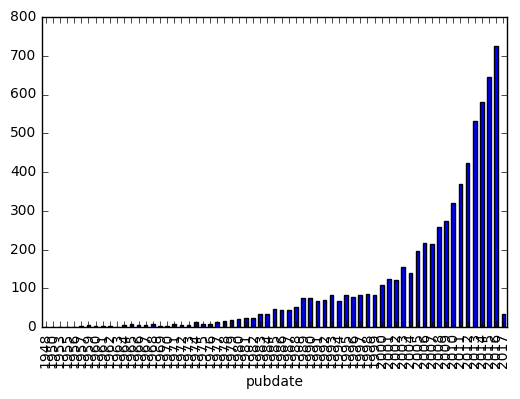

In [18]:
# df = lit_search('idiopathic pulmonary fibrosis')
df = pd.read_csv('idiopathic-pulmonary-fibrosis.csv')
explore_result_dataframe(df)

In [19]:
pmid_blocks = get_chunked_pmids('idiopathic pulmonary fibrosis', chunksize=200)


In [20]:
terms = ['idiopathic pulmonary fibrosis', 'cryptogenic fibrosing alveolitis',
        'usual interstitial pneumonia', 'asbestosis']

#?(idiopathic pulmonary fibrosis) AND (asbestos) 

def litsearch_terms(terms):
    """
    Search pubmed for the terms and return a df
    """
    df_list = []
    for term in terms:
        print ('searching for {0}'.format(term))
        df = lit_search(term)
        df_list.append(df)
        save_df_as_csv(term, df)
    df = pd.concat(df_list)
    return df

In [21]:
topic_collection = {"ipfjes_case_control_studies" : ['23022860', '10968375', '24413348', '19782552', '17628464', 
                                                     '10841131', '8569361', '8087336', '15640309', '9571528', 
                                                     '18507288', '23022860', '2249047'], 
                    "ipfjes_reviews" : ['25621562', '24348069', '10193340', '11816818', '15331187', '16733403']}


def litfetch_topics(topic_collection):
    """
    fetch info for pmids in a topic collection and save the result as a .csv
    """
    for topic in topic_collection:
        print('begining topic {0} analaysis'.format(topic))
        result = lit_fetch(topic_collection[topic])
        df = resultdf(result)
        save_df_as_csv(topic, df)
        print('csv of topic {0} saved'.format(topic))

In [22]:
df = pd.read_csv('idiopathic-pulmonary-fibrosis.csv', usecols=['pmid','title','firstauthor','lastauthor',
                                                             'journal','pubdate','pubtype',
                                                             'abstract', 'keywords', 'rcr'])

In [23]:
df = pd.read_csv('ipfjes_case_control_studies.csv', usecols=['pmid','title','firstauthor','lastauthor',
                                                             'journal','pubdate','pubtype',
                                                             'abstract', 'keywords', 'rcr', 'citedby', 'cites'])


In [24]:
df1 = pd.read_csv('idiopathic-pulmonary-fibrosis.csv', usecols=['pmid','title','firstauthor','lastauthor',
                                                             'journal','pubdate','pubtype',
                                                             'abstract', 'keywords', 'rcr', 'citedby'])

In [25]:
keywords = get_pubmed_keywords(topic_collection['ipfjes_case_control_studies'])

print ('Top pubmed keywords (mesh headings)',
       'for the {0} occupational IPF case-control studies found'.format(len(keywords)))

corpus = []
       
for record in keywords:
    corpus.append(keywords[record])
    
corpus = [item for sublist in corpus for item in sublist]

x = Counter(corpus)

top_keywords = [(l,k) for k,l in sorted([(j,i) for i,j in x.items()], reverse=True)]
top_keywords[:5]

Top pubmed keywords (mesh headings) for the 12 occupational IPF case-control studies found


[('Male', 12),
 ('Humans', 12),
 ('Female', 12),
 ('Case-Control Studies', 10),
 ('Aged', 8)]

In [26]:
def citing_count(pubmed_id):
    '''
    Looks up papers citing a list of pubmed_id strings and returns a dict
    {citing_paper:number_of_times_cites_list}
    '''
    citing = get_citing_pmids(pubmed_id)
    corpus = []
    for record in citing:
        corpus.append(citing[record])
    corpus = [item for sublist in corpus for item in sublist]
    x = Counter(corpus)
    citingpapers = [(l,k) for k,l in sorted([(j,i) for i,j in x.items()], reverse=True)]
    citing_count = dict(citingpapers)
    return citing_count

In [27]:
citing_count = citing_count(topic_collection['ipfjes_case_control_studies'])

In [28]:
result = lit_fetch(list(citing_count.keys()))


In [29]:
df = resultdf(result)

In [30]:
df.head()

,pmid,title,firstauthor,lastauthor,journal,pubdate,pubtype,abstract,keywords,rcr,citedby,cites
0,18366757,Idiopathic pulmonary fibrosis.,Meltzer EB,Noble PW,Orphanet J Rare Dis,2008/03/26 00:00,"[Journal Article, Review]",Idiopathic pulmonary fibrosis (IPF) is a non-neoplastic pulmonary disease that is characterized by the formation of scar tissue within the lungs in the absence of any known provocation. IPF is a rare disease which affects approximately 5 million persons worldwide. The prevalence is estimated to ...,"[Aged, Aged, 80 and over, Diagnosis, Differential, Female, Humans, Lung/diagnostic imaging, Lung Diseases/diagnosis/epidemiology/physiopathology/therapy, Male, *Pulmonary Fibrosis/diagnosis/epidemiology/physiopathology/therapy, Tomography, X-Ray Computed]",5.408593,"[27877129, 27814727, 27590450, 27548238, 27482070, 27435431, 27408631, 27275013, 27190866, 26973540, 26841042, 26762154, 26498943, 26345256, 26317335, 26315535, 26251654, 26185416, 26173796, 26106328, 26064084, 25984423, 25691376, 25613169, 25595323, 25484613, 25410822, 25318837, 25281715, 25226...","[17998365, 17556720, 17392301, 17356077, 17332882, 17255562, 16924102, 16890108, 16844727, 16738192, 16738191, 16537877, 16387947, 16387946, 16315778, 16306520, 16304277, 16304243, 16236900, 16210097, 16204587, 16109978, 15968010, 15947316, 15888834, 15885995, 15881274, 15855634, 15764787, 15734..."
1,26881370,Association Between Interstitial Lung Abnormalities and All-Cause Mortality.,Putman RK,Hunninghake GM,JAMA,2016/02/16 00:00,"[Journal Article, Research Support, N.I.H., Extramural, Research Support, N.I.H., Intramural, Research Support, Non-U.S. Gov't]","IMPORTANCE: Interstitial lung abnormalities have been associated with lower 6-minute walk distance, diffusion capacity for carbon monoxide, and total lung capacity. However, to our knowledge, an association with mortality has not been previously investigated. OBJECTIVE: To investigate whether in...","[*Cause of Death, Cohort Studies, Coronary Artery Disease/epidemiology/mortality, Female, Humans, Male, Neoplasms/mortality, Prevalence, Proportional Hazards Models, Prospective Studies, Pulmonary Disease, Chronic Obstructive/diagnostic imaging/epidemiology/*mortality, Pulmonary Emphysema/epidem...",NaN,"[28035861, 27976940, 27630174, 27600665, 27471206, 27314401]","[25389906, 24875841, 24836312, 24836310, 24547893, 23692170, 23513242, 22268134, 21506741, 21471066, 21388308, 21233262, 20843247, 20538446, 20426172, 20214461, 20190329, 20017989, 19781963, 19749005, 19542480, 19401580, 18216052, 17351290, 16809633, 14999112, 14819398, 11790668, 11587991, 80873..."
2,15286797,Pulmonary fibrosis: thinking outside of the lung.,Garantziotis S,Schwartz DA,J Clin Invest,2004/08/01 00:00,"[Comment, Journal Article, Research Support, U.S. Gov't, Non-P.H.S., Research Support, U.S. Gov't, P.H.S., Review]","Pulmonary fibrosis is a devastating condition that leads to progressive lung destruction and scarring. Previous mechanistic research has focused on the local fibroproliferative process in the lung. However, emerging evidence suggests that circulating cells of hematopoietic origin play a crucial ...","[Animals, Bleomycin/toxicity, Fibroblasts/drug effects/metabolism/pathology, Genetic Predisposition to Disease, Humans, Inflammation/metabolism/pathology, *Lung Injury, Models, Biological, Pulmonary Fibrosis/chemically induced/genetics/*metabolism/pathology/*physiopathology, Wound Healing]",1.092262,"[26396235, 21998664, 20660310, 20498529, 20070197, 18703791, 18334556, 16751304]","[15286810, 15010326, 14722616, 12817021, 12444030, 12119236, 11790668, 11519507, 10673212, 10639533, 9839161, 9001319, 8790603, 8569361, 7921471, 7513987, 2433976, 294225]"
3,25621562,Asbestosis and environmental causes of usual interstitial pneumonia.,Gulati M,Redlich CA,Curr Opin Pulm Med,2015/03/01 00:00,"[Journal Article, Review]","PURPOSE OF REVIEW: Recent epidemiologic investigations suggest that occupational and environmental exposure

In [32]:
df.pubdate = pd.to_datetime(df.pubdate)
df.index = df.pubdate.map(lambda x: x.year)
df = df.sort_values(by = 'pubdate', ascending=True)
df['citations of pmidgrp'] = df.pmid.map(lambda x: citing_count.get(x))
df = df[['title','firstauthor', 'lastauthor', 'journal', 'pubtype', 'rcr', 'citations of pmidgrp']]
df

,title,firstauthor,lastauthor,journal,pubtype,rcr,citations of pmidgrp
pubdate,,,,,,,
1991,Critical appraisal of published research: introductory guidelines.,Fowkes FG,Fulton PM,BMJ,"[Guideline, Journal Article]",NaN,1
1992,"New perspectives on basic mechanisms in lung disease. 1. Lung injury, inflammatory mediators, and fibroblast activation in fibrosing alveolitis.",Sheppard MN,Harrison NK,Thorax,"[Journal Article, Review]",NaN,1
1995,Epstein-Barr virus replication within pulmonary epithelial cells in cryptogenic fibrosing alveolitis.,Egan JJ,Woodcock AA,Thorax,"[Journal Article, Research Support, Non-U.S. Gov't]",3.073204,1
1996,Mortality rates from cryptogenic fibrosing alveolitis in seven countries.,Hubbard R,Britton J,Thorax,[Journal Article],2.405705,2
1997,British Thoracic Society study of cryptogenic fibrosing alveolitis: current presentation and initial management. Fibrosing Alveolitis Subcommittee of the Research Committee of the British Thoracic Society.,Johnston ID,Rudd RM,Thorax,"[Journal Article, Research Support, Non-U.S. Gov't]",4.620485,1
1998,In search of a cause of cryptogenic fibrosing alveolitis (CFA): one initiating factor or many?,Turner-Warwick M,Turner-Warwick M,Thorax,"[Journal Article, Review]",0.229885,3
1999,"The diagnosis, assessment and treatment of diffuse parenchymal lung disease in adults. Introduction.",,,Thorax,"[Journal Article, Review]",0.529739,1
2000,Adult familial cryptogenic fibrosing alveolitis in the United Kingdom.,Marshall RP,Laurent GJ,Thorax,"[Journal Article, Research Support, Non-U.S. Gov't]",3.413365,1
2000,Idiopathic pulmonary fibrosis in infants: good prognosis with conservative management.,Hacking D,Heaf D,Arch Dis Child,[Journal Article],0.649444,1


In [33]:
df.to_csv('papers_citing_ipf_occupational_dust_case_control_studies.csv')

In [34]:
df.sort_values(by='citations of pmidgrp', ascending=False)

,title,firstauthor,lastauthor,journal,pubtype,rcr,citations of pmidgrp
pubdate,,,,,,,
2013,Epidemiology of idiopathic pulmonary fibrosis.,Ley B,Collard HR,Clin Epidemiol,"[Journal Article, Review]",3.114474,10
2011,New insights into the pathogenesis and treatment of idiopathic pulmonary fibrosis.,Ding Q,Thannickal VJ,Drugs,"[Journal Article, Research Support, N.I.H., Extramural, Research Support, Non-U.S. Gov't, Review]",1.379412,9
2015,Asbestosis and environmental causes of usual interstitial pneumonia.,Gulati M,Redlich CA,Curr Opin Pulm Med,"[Journal Article, Review]",0.943542,8
2014,"Effects of smoking, gender and occupational exposure on the risk of severe pulmonary fibrosis: a population-based case-control study.",Ekström M,Torén K,BMJ Open,"[Journal Article, Research Support, Non-U.S. Gov't]",1.144405,8
2009,Cigarette smoking is associated with subclinical parenchymal lung disease: the Multi-Ethnic Study of Atherosclerosis (MESA)-lung study.,Lederer DJ,Barr RG,Am J Respir Crit Care Med,"[Journal Article, Research Support, N.I.H., Extramural, Research Support, Non-U.S. Gov't]",3.310302,5
2016,Idiopathic Pulmonary Fibrosis: A Genetic Disease That Involves Mucociliary Dysfunction of the Peripheral Airways.,Evans CM,Schwartz DA,Physiol Rev,"[Journal Article, Review]",NaN,5
2004,The epidemiology of interstitial lung disease and its association with lung cancer.,Raghu G,Morgan G,Br J Cancer,"[Journal Article, Review]",1.747284,4
2012,Newly recognized occupational and environmental causes of chronic terminal airways and parenchymal lung disease.,Sauler M,Gulati M,Clin Chest Med,"[Journal Article, Review]",1.008971,4
2014,Idiopathic pulmonary fibrosis: early detection and referral.,Oldham JM,Noth I,Respir Med,"[Journal Article, Research Support, Non-U.S. Gov't, Review]",1.139613,4


In [35]:
# make something to show new things

In [36]:
cited = get_cited_pmids(topic_collection['ipfjes_case_control_studies'])

# print ('Top cited papers (from pubmed)',
#       'for the {0} occupational IPF case-control studies found'.format(len(cited)))

corpus = []
       
for record in cited:
    corpus.append(cited[record])
    
corpus = [item for sublist in corpus for item in sublist]

x = Counter(corpus)

# [(l,k) for k,l in sorted([(j,i) for i,j in x.items()], reverse=True)] not that interesting because most
# of our papers aren't in PMC and so citations not available

In [43]:
import networkx as nx
import matplotlib.pyplot as plt


IPF case-control studies and their citing papers

Key : pubmed id : title author year : (n of citations)
0 : 8569361 : Occupational exposure to metal or wood dust and aetiology of cryptogenic fibrosing alveolitis. Hubbard R 1996 (40)
1 : 10968375 : Occupational and environmental risk factors for idiopathic pulmonary fibrosis: a multicenter case-control study. Collaborating Centers. Baumgartner KB 2000 (39)
2 : 8087336 : Idiopathic pulmonary fibrosis. Epidemiologic approaches to occupational exposure. Iwai K 1994 (30)
3 : 2249047 : What causes cryptogenic fibrosing alveolitis? A case-control study of environmental exposure to dust. Scott J 1990 (24)
4 : 15640309 : Occupational and environmental factors and idiopathic pulmonary fibrosis in Japan. Miyake Y 2005 (11)
5 : 10841131 : Risk of cryptogenic fibrosing alveolitis in metal workers. Hubbard R 2000 (9)
6 : 19782552 : Risk factors for idiopathic pulmonary fibrosis in a Mexican population. A case-control study. García-Sancho Figueroa M

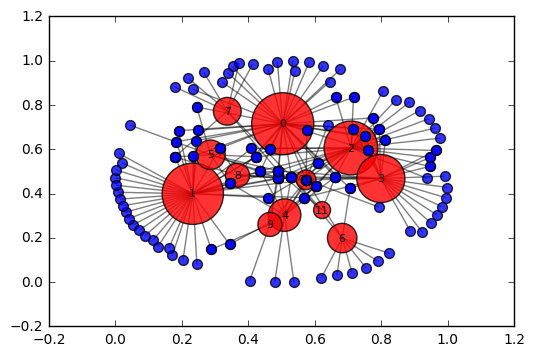

In [45]:
# G = nx.DiGraph(nx.from_dict_of_lists(citing))
citing = get_citing_pmids(topic_collection['ipfjes_case_control_studies'])

citing = OrderedDict(sorted(citing.items(), key=lambda t: len(t[1])))

citing = OrderedDict(reversed(list(citing.items())))

G = nx.from_dict_of_lists(citing)

pos=nx.spring_layout(G)
        
nx.draw_networkx_nodes(G,pos,
                       nodelist=citing.keys(),
                       node_color='r',
                       node_size=[len(v) * 50 for v in citing.values()],
                       alpha=0.8)

nx.draw_networkx_nodes(G,pos,
                       nodelist=[item for sublist in citing.values() for item in sublist],
                       node_color='b',
                       node_size=50,
                       alpha=0.8)

nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)

labels = {}

for i, item in enumerate(citing):
    labels[item] = i
    
nx.draw_networkx_labels(G,pos,labels,font_size=8)

print ('IPF case-control studies and their citing papers\n')
    
    
print ('Key : pubmed id : title author year : (n of citations)')

for i, item in enumerate(citing):
    print(i,':', item, ':', get_pubmed_summaries([item])[item]['title'],
          get_pubmed_summaries([item])[item]['sortfirstauthor'], 
          get_pubmed_summaries([item])[item]['sortpubdate'][:4],
          '({0})'.format(len(citing[item])))
    
plt.savefig('PapersThatIPFCaseControlStudies.svg')

In [39]:
# need to sort paper (and label order)data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAhcAAAFkCAYAAACThxm6AAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAAPYQAAD2EBqD+naQAAIABJREFUeJzs3Xl8VOW9+PHPmSWTZDLZgRjWsC+y70VkEVCkbiQCQQJo0bbX3qveqj+12uXW24uXti5trUpbBHLZRDaVTRaRoKisSdjRBEhC1kkymcnMZGbO8/sjyZBlkkxwAgjPu6/+weScM+ccMOd7nu/3+T6KEAJJkiRJkqRA0VzvE5AkSZIk6eYigwtJkiRJkgJKBheSJEmSJAWUDC4kSZIkSQooGVxIkiRJkhRQMriQJEmSJCmgZHAhSZIkSVJAyeBCkiRJkqSAksGFJEmSJEkBJYMLSZIkSZICqk2DC0VRxiuKskVRlFxFUVRFUe5vYfuHFEXZqShKoaIo5YqifKEoyrS2PEdJkiRJkgKrrUcujMAx4EnAn0VM7gR2AtOBYcBe4CNFUQa32RlKkiRJkhRQyrVauExRFBV4UAixpZX7ZQJrhBCvts2ZSZIkSZIUSDd0zYWiKApgAszX+1wkSZIkSfKP7nqfQAueozq1sq6pDRRFiQHuBrIBx7U5LUmSJEm6KQQD3YAdQoiSQB30hg0uFEWZC7wC3C+EKG5m07uB/7s2ZyVJkiRJN6VHgFWBOtgNGVwoijIHeA9IEkLsbWHzbIDU1FT69evX1qd2Q3vmmWd4/fXXr/dp3BDkvagm78MV8l5Uk/fhCnkv4NSpU8ybNw9qnqWBcsMFF4qiJAP/AOYIIbb7sYsDoF+/fgwbNqxNz+1GFxERccvfg1ryXlST9+EKeS+qyftwhbwX9QS0rKBNgwtFUYxAT0Cp+ah7zbRSsxDikqIo/wPECyEW1GyfDCwH/gP4WlGUDjX72YUQlrY8V0mSJEmSAqOtZ4uMAI4Ch6nuc/En4Ajwu5qfxwGd62z/BKAF/gbk1fn/G218npIkSZIkBUibjlwIIfbRTAAjhHi0wZ8nteX5SJIkSZLU9m7oPhdS6yQnJ1/vU7hhyHtRTd6HK+S9qCbvwxXyXrSda9ahs60oijIMOHz48GFZmCNJkiRJrXDkyBGGDx8OMFwIcSRQx5UjF5IkSZIkBZQMLiRJkiRJCigZXEiSJEmSFFAyuJAkSZIkKaBkcCFJkiRJUkDJ4EKSJEmSpICSwYUkSZIkSQElgwtJkiRJkgJKBheSJEmSJAWUDC4kSZIkSQooGVxIkiRJkhRQMriQJEmSJCmgZHAhSZIkSVJAyeBCkiRJkqSAksGFJEmSJEkBJYMLSZIkSZICSgYXkiRJkiQFlAwuJEmSJEkKKBlcSJIkSZIUUDK4kCRJkiQpoGRwIUmSJElSQMngQpIkSZKkgJLBhSRJkiRJASWDC0mSJEmSAkoGF5IkSZIkBZQMLiRJkiRJCigZXEiSJEmSFFAyuJAkSZIkKaBkcCFJkiRJUkDJ4EKSJEmSpICSwYUkSZIkSQHVpsGFoijjFUXZoihKrqIoqqIo9/uxz0RFUQ4riuJQFOWsoigL2vIcJUmSJEkKrLYeuTACx4AnAdHSxoqidAM+BnYDg4E3gX8oijK17U5RkiRJkqRA0rXlwYUQ24HtAIqiKH7s8nPgOyHE8zV/PqMoyh3AM8CnbXOWkiS1JafTic1mw2g0YjAYrvfpSJJ0DbRpcHEVxgC7Gny2A3j9OpyLJP1gBeqB/n2Oc+zYMVJTV/HJJ5/hcqno9RpmzJhISsojDB48+JqfjyRJ186NFlzEAQUNPisAwhVFMQghnNfhnCTpByNQD/Tve5z169fz4ouvUVGRQGjo0+j1nXA6c0hN3cTmzYtYvPgFEhMTr/l1SZJ0bfwQZovUplNarNmQpFvZ+vXrefjhx0lNzcbpfBqt9s84nU+TmppNUtIiPvzww2tynGPHjvHii69ht8+mY8c1REfPxWS6k+jouXTsuAa7fRYvvLCY48ePX9PrkiTp2rnRRi7ygQ4NPmsPWIQQVc3t+MwzzxAREVHvs+TkZJKTkwN7hpLURr5vCuLKA/0/UZQr7w1RUXMoKPgTL7ywmJ49ezb7ph+I46SmrqKiIqHR/gCKoqFDh1+Sm/sNqamrWhx1CNR1SZIEq1evZvXq1fU+Ky8vb5PvutGCiy+B6Q0+m1bzebNef/11hg0b1iYnJUltKRBD/oF6oH/f4zidTj755DNCQ5/27u92u9Bqtd4/K4qG0NAH+eSTN3j1VWezgVQgAxVJutX5euE+cuQIw4cPD/h3tXWfC6OiKIMVRRlS81H3mj93rvn5/yiKsrzOLu8APRRFeU1RlD6KovwbkAT8uS3PU5Kul0AM+V95oD/ofQALIbDZrKiqB6j7QN+L0+m7dKnxcQRCqAhxJSPZ0nFsNltNgNSp5hNBaWkpZWVl9bbT6ztRVaVis9n8vi4hhPd6/D0fSZKuj7auuRgBHAUOU10z8SfgCPC7mp/HAZ1rNxZCZAMzgClU98d4BviJEKLhDBJJ+sELVG1C4wc6CKFisVRgtVq9n7X0QPd1nMuX87HbK+tt19xxjEYjer0GlysHAIfDicvlxmg01tvO5cohKEjT6POmzkcIldJSMyUlJTQsv/InUJEk6dpq0+BCCLFPCKERQmgb/P+xmp8/KoSY7GOf4UKIECFELyHEyrY8R0m6XmqH/Dt0aHrIv6IigdTUVc0ep+EDHUCj0RIWFobNZsPjcQMtP9AbH0dBUZR6IxctHcdgMDBjxkQqKzchhIrVaiUoSE9QUJB3GyFUKis3MWPGpGZTIrXnU1V1EbPZjNNZRXh4BFdqvFs+H0mSro8fwmwRSbrp+EplQPWDt5a/Q/4NH+i1wsKMaDQaKioq/Hqg+zpOw+DCn+PMmzcXkymLvLz/xel0EBYWRm1AIIRKQcGfMJmymDdvbrP3yGAwcM894zGb1+J0OomJiW70nf4GKpIkXVsyuJCk68BXCsLtdlNYWFgvDeHvkH/tA72g4M91AgMNJpMJm81GXt5rfj3QGx6nbnDhb2AwZMgQFi9+ASHex2b7GZWVG6io+ByzeRW5uXMICVnH4sUvtFiA6XQ6iYgwodefQoiV6PX6ej9vTaAiSdK1daPNFpGkW0LtkL/TeSWVodVqMRgMlJaW4XK5CA8Px+XKITi45SH/2gf6Cy8sJjf3a0JDH0Sv74TLdQmbbTWhoedZvPi/W3ygNzyOyzUJ6IrLVUZl5SZMpiy/AoMJEybw0EOTsNnsHDr0JlVVKsHBGhITJzFv3q9a3N/hcLBy5UqCg4P5wx+eZ8mSpeTmHqlzXTmtOh9Jkq4tGVxI0nVQm4JITd1EVNQcFEWDoihERkai1+uxWCxUVVVht28kMdG/If/ExER69uxZM631De8DPSlpEEFBnRgyZEiLx2h4nNTU13G7tZhMJr8DA4ADBw7Qs2dPnnrqKTweT6v6d1RWVrJy5UrKyspYsGABt912G6NHj250Xa05n+tNti2XbjUyuJCk62TevLls3vw4BQV/rlPUqWA0hqHVarl06Q8EBR3j3nv/ze9jDh48mMGDB/Pqq1ceZkFBQfzrX/9i165ddO/eHX/WEKw9To8eCRiNRmbNmuX3Q9FisZCens7kyZPR6XTodDq/97XZbKxYsQKr1crChQvp0KFDk9cVyIf01Tz8/dlHti2XblWy5kKSrpPaFERIyFpyc+dgNq/y1iYUFy8gNnYrDz00iS+//JJTp0616tgGg4Ho6OoCSEVRmDp1KpcvXyYjI6NVxwkNDSU4OLhVD/KDBw+i1+sZMWJEq77LarXy/vvvY7PZ6gUWddW9rkA4duwYzz77PEOGjGfUqGkMGTKeZ599vtnpv/7uI9uWS7cyGVxI0nWUmJjI+vX/ICUlgeDgN/B4/pPg4DdISUlgw4Z/8de//pVevXqxdu1a9u7d22haqL+6dOlC37592bNnD2632+/99Ho9LpfL7+0dDgeHDx9mxIgRrQoALBYLy5Ytw+FwsHDhQtq1a+f3vrWcTmfNlFX/mmldzcPf330C1cOktdckSTcKmRaRpOuspSH/pKQk4uLi2LNnD/n5+cycOfOq3tzvuusu3n77bb755hvGjh3r1z46nQ673e73dxw6dAiPx8OYMWP83qe8vJzly5fj8Xh49NFHiY6O9ntfuLrUw9WsWdKafb5v23KZTpF+6OTIhSTdIJoa8lcUhfHjx5OcnEx2djZLly6t6VTZOu3atWPYsGF8/vnnOBwOv/ZpzciF2+3m4MGDDB48uKa3RctKS0tZtmwZQoirCiyuNvVwNQ3M/N3n/fdXNOph4na767Uub66HiUynSDcDGVxI0g9E7969efzxxwFYunQp586da/UxJk6ciNvtJi0tza/tWxNcHD9+HJvNxo9+9CO/tjebzbz//vtoNBoWLlxIZGSkX/vVutrUQ1MNzOpq+PBvzT5bt+6lqspTr4eJxVKO2Vxab3tfPUwCvVy9JF0vMriQblk/xHx2bGwsixYtomvXrqxatYq0tLRW1WGYTCbGjh3LwYMHsVgsLW6v1+v9qtFQVZUDBw7Qr18/YmJiWty+uLiYZcuWodfrefTRR4mIiPDr/Ou62vbpvhqYVVRYqKiofz/qPvx97WOxlONyVTXax+0GrRZvG3VVVXE6nYSEBNfb1lfb8kC1hJek600GF9It52pmCNxIgoODmTNnDuPHj2fXrl2sX7+eqqqqlnesMW7cOIKCgti7d2+L2+p0Or9GLk6fPo3ZbGbcuHEtbltYWMj7779PSEgICxcuxGQy+XXedTW1Emzdc20q9eBrLRa3293oOus+/Bvuo6oerFYbHo+n0T4Gg65eG3WHw44QEBIS4t3OV9ty36Mj9QNHuQqs9EMhgwvplnKz5LMVRWHy5MnMmjWLc+fO8a9//avRsuZNMRgMTJgwgWPHjlFYWNjstv6kRYQQpKWlkZCQQMeOHZvdNj8/n/fff5+wsDAWLFjgd21GQ75GEmw2G8XFxdR9IPtKPTS1Fktza6g03Mflqh7N0en0PvdZsCDF20a9stKGwRCERqP1buerbXnDa3I6HRQWFjZaZl6uAiv9EMjgQrpl3Iz57P79+/OTn/wEp9PJe++9R1ZWll/7jRgxgsjISHbt2tXsdv6kRbKzs8nLy2tx1CIvL4/ly5cTGRnJggULvtcqpr5GHwyGIIQQ9UZxmlox1dcaKrWaevjX3cflcqIoCjqd74ChtoeJwbCa4uKFVFV91OL6KvWvSVBebkGr1aLR1P817c8qsD/ElJ90c5HBhXTLuFnz2R06dOCJJ54gLi6OlStXcvDgwRbrMLRaLXfddRdnz57lwoULTW5XmxZp7ngHDhwgLi6OHj16NLlNTk4OK1asICYmhvnz59dLEVwNX6MPer0ejUbB6awOLppbMbVhA7OKivXY7V80+/Cvu09BwTyczs1UVOxvcp/ExER++9unGTKkApPp7Xo9TNav/weJiYlNXpPVWoHb7W60xHxLq8D+0FN+0s1DBhfSLcFXPrt67Y4rPRx+yPnskJAQ5s2bx5gxY9i+fTubN29uccRhwIABxMfH8+mnnzYZPOj1eoQQjWoLauXn53P+/HnGjRvXZFvxixcvsnLlStq3b09KSgrBwcE+t2utxivBKhgMBpxOp18rptZtYBYU9Dqq+myzD/+6+4waVUVIyJstBgwOh4Nf/OJJjh9P4+uvd3L06H6WLHmtyV4V8+bNJSzsWy5f/iMhIYaaVWmrg6eWrulmSflJNwfZREu6JfjK0dvtlVRWVqIoEBxc/SZdN5/9Q1tgSqPRMG3aNOLi4tiyZQtFRUXMnj2b8PBwn9vXtgVfvnw5p06don///o22qV3m3O12o9M1/nVx4MABIiMjGTBggM/vyM7OZtWqVcTHxzN37lyCgoK+xxXW52slWI8nBovlPA7HZ5hM2S2umFrbwOyOO37E+fPn+cUvftHi3/vAgQMZP/4OfvWrl7j99tubXFvEbDaTm5tLUlKSt27Dn2u6887BrF69lAsXDqAod6PR3EZwcBl6/R6ionJ8XtPVNAWTpLYkgwvpluBrifOIiAhUVaW0tJSoKIXg4GC/lzi/kQ0aNIjY2FjWrFnDe++9x+zZs+ncubPPbRMSEujZsye7d++mT58+aLVaPB4PWVlZnDp1ii+//NKbZomJiaFPnz707duXzp07U15eTmZmJtOnT29UFwDw3XffsXr1arp06cKcOXO8gUogNVwJ1m53odOVc999U/nFL172+0EaHBzs9xoqZrMZt9tN586dm236lZmZSVBQEH369PH7epYuXcrmzfsICupHUJARh2MFqurGZqvAZBL87Ge/9Dmi8n07goJcuVUKLBlcSLcEX0ucg0JUVBSlpaWUlpqJioqksnKT30uc38ji4+N54oknWLduHe+//z733nsvw4cP97nt1KlTeeedd9i5cydZWVlsWrUKc24uisNBnKoSUVnJtydPckSjYQVAcDC39ehBz9tvJyIigqFDhzY65rlz51i7di0JCQnMnj3b56hHoNRtn261Wlm6dCkjRoxo1Ru6RqNpMvXTUEFBAYDPhdVqCSHIyMigT58+fgdVR48e5eWX/4jHk0LPnq+gKFpU1Ymq2lCUEIqK/so776xhypQp9a7tSsrvaW9goaqemoCvOlV1JeX3Bq++6qz371u2GpfaggwupFtGU0ucR0VFUVJSzKVL/0N09FnmzfvV9T7VgKid7rl9+3Y++ugj8vPzueeee9BqtfW2i4iI4MKFC6z829+I12i4T6djsslE38hI9B4PxcXFtGvXDr1eT7nHw0m7nW2ZmWw6eBClfXsSEhKYN2+e97hnzpxh3bp19OrVi6SkpDYNLOqqTT306tXL71kztbRaLaqqtrwh1cGFyWQiNDS0yW0KCwspKipi6tSpfp/DG2+8hc3Wg27d/h+KUn0vNRoDGk11INDU6EPDlJ+qVv+dBQcH1xSEVvOV8lu/fj0vvvgaFRUJhIY+jV7fCaczh9TUTWzevIjFi1/wOVIiSS2RBZ3SLaPpJc5XY7f/GyEh6xg7tn+r17e4kWm1WmbMmMF9993HkSNHWLFiBVar1fvzU6dOMTcxkVNbt/Kky8UHJhPPxcUx3GjEqNV6izRryz0jtFrGhoXxbHg4H4SFsdDp5G8vvcRjKSnk5ORw8uRJ1q5dS58+fXj44YevWWBRV0JCAnl5eX6vnwJ400H+KCgoaHbUAiAjI4OQkJBmZ9DUVVFRwfbt+wkNfdBb/1M9pfZKoa0/TcGEUCkpMSOEIDS0fmqv4RTWm3FqtnTjkMGFdEtpeonz7nz88f8xdepUUlNTycvLu96nGlDDhw9nwYIFlJSU8N5775GXl8ehQ4d4Yu5cwg4fZnW7djzWrh1qZSWeOm/w3uCizmwSVQhsNhtxJhPPxMXxj4gILHv2MPv++3nvvfcYMGAASUlJjUZIrpWEhASEEGRnZ/u9T2vTIu3bt2/y50IIMjMz6d+/v9/3YPfu3bjdgoiIXgC43S5KSoqxWus3ymq+KdhGSkqK8XjcREfH1AvsfE1hvVmnZks3BhlcSLecwYMHs2TJaxw9ur/e9MARI0Ywd+5c2rVrx8qVK8nPz7/epxpQXbp04YknnsBkMrF48WJ+Nm8eg/LzeS8+nm4GA6awMFAUKioqvPv4Ci4qKysRQnjfgAeFhvLXyEhizp5l/86djB492meB57USFRVFVFRUq1Ij/qZFnE4nZWVlzY5c5OTkUFZWxsCBA/367tLSUo4dO0ZYWDAez2VAUFZWhlarxWisn3ppqoHW3LlzUJRMSkv/SlRUZL06D19TWH1NzXY6HfXWSvkhT82Wrj8ZXEi3LF9LnBsMBubNm0dkZCQrV66kqKjoOp5h4IWHh5OcnMyhAwfokpPDr41GDDWBgEajwRQWRmVlpbdHRsPgQgA2q5WQkBB0NW/ltspKFIuFN9u1o6PZzO9eecXv+oW2kpCQ0Orgwp+Ri9p26c0FFxkZGZhMJrp06eLXd+/cuROTycTMmfd4G2hVVbmIjIysN6LQVAMtIQS5ublMmDCYyMjNFBUtqJPy893gq36dhsBqtVJSYsZmq6x3brLVuHS1ZHAhSQ0EBweTkpJCWFgYy5cvp6Sk5HqfUkC9++67kJvLf8fF4bHbMZeUeIMBo9GIVqPBUjt60SC4sNvteDwewmrenG02G+VlZYQajXSLieE3UVEc3bmTdevWXfsLqyMhIYHCwsJ69SXN8TctUlBQgEajITY21ufPVVXlxIkT3H777X6N3tRO+Z06dSoLFqQQGnqey5f/iNEYQlBQ3QCi6QZae/bs4fDhw7zwwgts2bLCR8qvcYOv2jqNqqqLlJaWYbFYCAsLIzKy/uq0TY2UyPbiUkvkbBFJ8iE0NJT58+ezbNkyli9fzqOPPkpUVNT1Pq3vLTc3lzXvvst/hITQLzISZ0gIpaWlFBUXEx0djV6nw2QyUVZWRpXRiL6m6ZUQAgFYrVYMwcHo9XqsNhuW8nKMYWGEh4ejAMONRh6uqODtJUu4//77m51R0Za6desGVDfxuv3221vcvjYtIoRostMoVAcXsbGxTRaqZmVlYbPZ/PpOVVXZtm0bnTt3ZuDAgQghuOeeMXzwwWoqKk7h8TyEXt8JlyuHyspNmExZjRpoffnll+zfv59p06YxZMgQAO+03OZ6VhgMBqZMGcuKFWswGicRFRXdqCV77UhJ3anZctqq5C85ciFJTTAajSxYsACdTsfy5cspLy+/3qf0vX344YeEWSw8XBMoGQwGYtu1Q1EUiouKsDschISGotPrsVgsADUtqAVOhwO3y0VYWBhWqxVLeTlhdQKLWgtjYnBcvsy2bduuwxVWM5lMtGvXzu/USG3hZUvpnJZmimRmZhIdHU18fHyL33no0CGKioqYPn06iqLw9ddf06FDB1aseIuUlO4tjj4cP36cHTt2cMcdd/CjH/2o3rF9pfzqunDhAjqdhqCgM0AqwcH1t/M1UiLbi0utIUcuJKkZJpOJBQsWsGzZMlasWMHChQsxmUzX+7SuisvlYvPq1dyn1xNcZ8hep9USGxtLWVkZpWYzYSYT4SZT9bC3wwE1wYXVakUfFESV00lFRQVhJhMmk4mG7/kd9HruFIL1q1Zd1x4JCQkJnD9/3q9ta1MYHo+nyRkeQggKCgro3bu3z5+73W5OnTrF6NGjmx39gOqi2L179zJ06FDi4+MpKSlh9+7djBo1iunTpzN9+vRmRx/Onj3L5s2bGTZsGHfddZdf11h7DYcOHWLbtm0MHjyYESNG8NvfvkFu7mFCQx9scqREtheXWkuOXEhSCyIiIliwYAEul4sVK1b8YIvbzp8/T/nly0zxERxplOpmYqbwcKwVFdgqK7FqtYw8e5ZphYXckZXF6JwcOl64QE55OaaaAKSpR+iUsDDOpadf19GehIQEzGazX+dQG1A0V3dRXl6O0+lscuTi3LlzOBwOv1Iie/fuRVVV7rrrLoQQbN68GZPJVC9QaGr04eLFi6xbt47evXvz4x//uMVAppbb7eajjz7ik08+YeTIkaSkpPDII480MTW7/kiJnLYqtZYMLiTJD1FRUSxYsAC73c6KFSvqrab6Q3Hq1Ck0Dgd9mliVVAFMYWFEx8RQVVWFSVXZFh3NtuhoPomOJjk4mEkGA50jI1scvekXHAwOB6dPn26DK/FPt27dUBTFr9SIP2mR2rbfTfW4yMzMJC4ujnbt2jX7Xfn5+Rw6dIiJEydiNBr56quvuHjxIg888ECLC7sVFBSwatUqOnXqRFJSknfEpaUCy4qKCpYvX87x48d54IEHmD59uveam5qaXTsC0XjaqsDtdtU7vpy2KjUkgwtJ8lNMTAzz58+noqKClStXtqoD5I3g/PnzdNNovFNPmxJsMNAuNhatVkuVy4XNZsNmtbLO4eAnsbGEhYW1+F2dg4IIcbs5d+5coE6/1UJCQoiLi/MruKibFmlKYWFhTUvtxqvMOp1Ozpw50+KohRCC7du3ExMTw6hRozCbzezevZvRo0fTtWvXZvctLS1l5cqVREVFkZycjE6n49ixYzz77PMMGTKeUaOmMWTIeJ599vl6XTVzc3N57733KCsr49FHH/W5Fgw0PVJSd9pqdXOvEoqKilHV+vdKTluV6pLBhSS1Qvv27Zk/fz5ms5n/+7//+0G9pVmtViLqNMNqjk6nI7ZdO0JCQrDb7XzlcFABJLXQ9rqWRlEwKcp1f9DU9rsQLVy3P2mR2mJOX2mIM2fO4Ha7WwwuTp48SXZ2Nvfccw8ajYbNmzcTFhbWYt2E1Wpl5cqV3j4sBoPBrwLLY8eOsWzZMiIiInjiiSfo1KlTs9/ji9FoRKdTKC8/S1FRER6Ph+joKDSa+rUpTU1blW5NMriQpFaKi4sjJSWFwsJCVq9ejcvlanmnG4Uf+XmX243FYqGwsBBVVQkOCeEjRWF+TAwaP/P7V76uddsHWkJCAhaLBbPZ3Ox2/qZFmqq3yMjIoEuXLkRGRja5v8vlYufOnfTu3ZuePXvy9ddfc+HChRbTIQ6Hg9TUVFwuFykpKRiNRj/WBXmY//iPX/POO+8wcODAqy5EFkJw+vRpOnQIw2bbQFiYkXbt2mMwBDfYzneDL+nWJYMLSboKHTt25JFHHiEvL481a9Z4O1reyEwmE6VN/MyjqlhtNgqLiigqLMRWWUlwcDDtYmMJb9+ebS4Xsxv0QWiOKgTlqupXCqUtdenSBY1G02JqpKW0iNvtpqSkxGdwUVlZybffftviqMWBAwewWq3cfffdmM1mdu3axahRo7w9OXxxuVysXr2a8vJyUlJSvMFLcwWWQgh0uoVYLF2xWiu5//77r2oBufz8fJYtW8bGjRv58Y/vpX37Amy2pdRdTK36+5pu8AWy4datqs2DC0VRnlQUJUtRFLuiKAcVRRnZwvZPK4pyWlGUSkVRLiqK8mdFUWQoLN1wunTpwty5c7lw4QLr1q3ze+Gr66V3795cFILKmrdzVQgq7XZKSkooyM/HYrGg0+mIio4mLi6OyIgIgoKtePLRAAAgAElEQVSC2Oxw0F+no0NVVb1FzZqTXVWFU6+nV69ebXlJLTIYDHTs2LHF4KKltEhRURGqqvoMLk6ePAnAgAEDmjx+eXk5Bw4cYMyYMURHR3vTIVOmTGlyH1VVWb9+PXl5ecydO9dbSOprXRBV9aCqKi6Xi6KiYtxulaio2Rw5crpmdVX/2e12tm7dyrvvvovdbmf+/Pk899xz/O//vuRjRWHf7cUBv+pBpJtXm/a5UBRlNvAn4Anga+AZYIeiKL2FEMU+tp8L/A+wEPgS6A0sB1Tg2bY8V0m6Gt26dWPOnDmsXr26Jgf+8HVdtKs5/fr1QzUYSLdY6AM47HaEEAQFBRERGUlISIjPtEdqeTmPGI2oqkpFRQWRERGND97AKYcDQkLo27dvG1xJ6yQkJHDo0KFmu2+2lBZpbqZIRkYGCQkJzdYa7Ny5E4PBwJ133ulNhyxcuLDJdIgQgo8++ohz586RnJxM586dvT+rvy5I9ehGbdpHVVV0Oi3R0TFUViZ4Cyz9SVUIITh27Bi7du3C5XIxdepURo8e7b03iYmJ9OzZs6ZD5xtUVakEB2tITJzEvHm/qhdYrF+/nhdffI2KigRCQ59Gr++E05lDauomNm9exOLFL1zXHihS22vrJlrPAO8KIVYAKIryM2AG8Bjwvz62HwukCSHW1vz5oqIoq4FRbXyeknTVevbsyaxZs1i7di0bN27koYceuqECDCEE+fn5nD9/nkpF4ePCQrpHRhJmMtVbgKwpaX37kp+fj01RuGSx0NdgILqJ6ay1dlqt9J8w4YZoONa9e3c+//xzCgoKiIuL87lNS2mRgoICoqKiGgUDFovFO420KdnZ2Zw4cYIHH3wQm83mVzpk165dHD16lJkzZzYa/aldF8TpzMFut1NWVorb7UGjUQgNDfUueOZy5RAc7F+BZV5eHlu3biUnJ4eBAwcybdo0n393gwcPbrG9uGy4JUEbpkUURdEDw4HdtZ+J6pLtXVQHEb58AQyvTZ0oitIduBf4pK3OU5ICoU+fPiQlJXHixAm2bNnS4uyEa6G8vJy0tDTefvtt3n33XU6cOMHkGTPYGxyMMTYWU1hYi4EFwDqzmemFJfTPqWBCoYe4EzmMOHmGdU0USeZWVfGFRkPS3Mb59+uhU6dO6HS6ZlMjLaVFCgsLfaZEMjMz0Wq1TY7QqKrK9u3b6dixI4MGDWLLli0YjcZm0yEHDhzgwIEDTJ8+nUGDBjX6ucFg4N57J1BWtpaSkmLcbg9arYaIiAiioqJQFI3fBZaVlZV8/PHHLF26lKqqKhYuXEhiYmKLQWFz7cVlwy0J2nbkIhbQAgUNPi8A+vjaQQixWlGUWCBNqR6/1ALvCCFea8PzlKSA6N+/Pw899BAbNmxAp9MxY8aMaz5bwuFwcOrUKY4fP16zfoSOvn37Mm3aNHr06EFRURH37d7NqpISHm+h2RPALy9d4i+FbjyMQ+EhNHRG5RJH7RuZl3WUb2w2ltQZsgf4R0kJps6dmTZtWltdZqvodDq6dOlCVlYWY8f6fq/xJy0yfPjwRp9nZmbSq1cvgpsYyTly5Aj5+fksWrSIQ4cOkZ2dzYIFC5pMhxw9epRPP/2UO++8k9GjR/vcxm63ExUVgRDp2GzvEh7+c6KjY7wzOOoXWP7K5zFUVeXIkSPs3r0bVVW5++67GTlyZJOtz/11pR7kaRRFwel04PGo9Rawu9Jw6w1efdUpZ5fcpK7H2iIKDcuNa3+gKBOBl4CfUV2j0RN4S1GUy0KIV5s76DPPPENEg1xwcnIyycnJgThnSfLLwIEDcbvdbN68GZ1Ox913393mAYbH4+H8+fOkp6dz5swZPB4PCQkJPPDAA/Tr16/eL+8OHTqw8N//nX+++ioTHQ56NZPeWGs21wQWPyeIF1AUjXcRMyEWUMX/8GbhO4w0mpkVHQ3AF1YrH2k0vPLii00+cK+HhIQE0tLSUFXVZ8qqubSI1WrFarU2GrkoKSkhLy+PO+64w+d32u129uzZw5AhQzAajXz66aeMHDmShIQEn9ufPn2aLVu2MGLECCZNmuRzm4KCAtasWUN5eTl33jmIL79ch9t9GpttJlVVza+gWisnJ4etW7eSl5fHkCFDmDJlSouzepzO5ldZrWWz2XA6PXg80RQWFuJ2ezAYgggNDYE6zeLrNtySwcW1s3r1alavXl3vs7Zq0d+WwUUx4AEajiW2p/FoRq3/AlYIIZbV/PmEoihhwLtAs8HF66+/zrBhw77H6UpSYAwdOhS3280nn3yCTqfjrrvuajHAsFgsFBUV0a5dO58dIBsSQpCbm0t6ejqZmZlUVlbSoUMHJk+ezO23397sMRYtWsS+Tz/llS+/5B+33UZYE2+rS/KL8DAaAy9WD7Ujal4LFBRFQ5B4kSq+YknBV8yKjqbA5eL3ZWWMnTmT+++/v8VruJYSEhLYvXs3eXl5PhtJNZcWKSwsBGgUXGRmZmIwGJqcEfPZZ5/hdruZPHkyGzZswGg0MnXqVJ/bZmdns379evr168e9997r89/LiRMn2LhxI6WlpQQFBTFnzhxefrkn69atb7HAEvDWexw9epS4uDgee+wxunTp4vN8arVmifXLly/zxRdfYLWW4nJ9S3T0aCIjjQQF6aHBKjStqQeRAsfXC/eRI0d8jsp9X20WXAghXIqiHAbuArYA1KQ67gLeamK3UKpnhtSl1uyqiBshkS1Jfhg5ciRut5sdO3ag1+uZMGGCz+3Wrl3LkiV/JiMjC1XVoNGoDByYwPPP/5JZs2Y12t5sNpORkUF6ejolJSWYTCaGDh3KoEGDml0KvK6goCD+8Mc/sig5mf+4eJE3b7sNU4MAw+J2k+HQojATRaOpDioECEXUjF5UD28rYibp9kOcs9v5fyUl6AYO5Ne/+911b57VUHx8PAaDgaysrGaDC19pkYKCAvR6PVE1y9RDdXCXkZFB37590ev1jfYpLCzkm2++4a677uL06dPNpkMuX77M6tWr6dKlCzNnzmw0sqKqKnv27GHfvn1UVlYSGhrK5MmTmThxIoqiMHLkyGYLLFVV5dChQ+zZsweAGTNmMHz48BaLjv2Z8fHAAw9w8uRJvvnmGy5dukR4eDiTJo3ms88+IzLy541qLqrvXXU9SGKibLh1M2vrtMifgeU1QUbtVNRQ4H0ARVFWADlCiJdqtv8IeEZRlGPAV0AvqkczNsvA4ubg7/DqzWDs2LG43W52796NVqttNHz+y1/+kr/85f/weAahKL9Ho+mKx3OBo0c/ZN68/+Cbb75hyZIlVFZWcuLECdLT07l06RJBQUH079+fGTNm0K1bt6uamdKjRw/+umwZ//7YYzyWnc3vYmPpX6dJVpHbjSp0aKh+EIua/yHqZzU1dMIjdCwqKCB86FD+vmxZiwt3XQ8ajYauXbuSlZXF+PHjG/1cURQ8Hg9WqxW3241Wq/UGSAUFBbRv377efc7Pz6e4uJi777670bFq1w+JjIykd+/eLF26tMl0SElJCampqcTGxjJ79uxGza7sdjsffvghmZmZNW23o5k5cyb9+vWrt53BYPD539PFixfZunUr+fn53uXZ/RktaGnGR37+Ep566tekpaURERFBQkICs2fPpk+fPqSnp3PkyOMUFPy5UVGnP/Ug0s2hTYMLIcS6mgLN/6I6PXIMuFsIUVSzSSegbmvD31M9UvF7oCNQRPWox8tteZ5S22vN8OrNZPz48bjdbnbt2oVOp2PMmDFA9YhFdWDxUwyGX6MoV0YOhFiE0/k73njjXaqqqoiNjUUIQY8ePUhMTGzybbm1BgwYwD/XrOGVF15g4f79pFRUMC86miidjnY6HRrFjUfkeGe+NByNEALcXALc9LrvIf7w2mtNrhh6I0hISGDHjh0cPXqUc+fOcfr0aU4dPcrF777D6XBQUlzMpuXLMYSEoNFqCQsLo+ftt1NaUUH//v25cOECnTt3RqPRkJmZSWhoKN27d2/0PadPn+a7774jOTmZTz75hNDQUJ+zQ2oXwAsJCeGRRx5pFBwUFhayZs0acnJyUBSFTp06kZyc7Nc9tlqtfPrppxw/fpz4+Hgef/xxOnbs6Pe9qp3xUT+wEDidVVRW2lDVR7BaP+fixUu8885L9QLKIUOGsHjxC7zwwmJyc78mNPRB9Hr/6kGkm4fyQx8QUBRlGHD48OHDsubiBlV/eNX3L5qbuaGOEIJdu3Zx4MABfvzjHzNixAhGjBjN0aMRGAzb6gQWAiEEqqri8bjxeO6ja9dvWbNmNQMGDGizVtput5v333+ff731FqKoiKkaDZPDwnjqYi4ZjjEY2IRG0VaPXdQMXngEuPEADxETk0F29rfXvdV3U4qLi9m4cSNbN27k+NdfE24wEOzx0FNR6KfRkGAwEKIoWEtLiQgLQxMUhFMIyj0eTjudHLJaKTYYCAoPJzQykgEjRuABpk+fzkMPPVTvu9xuN3/729+IiYmhd+/ebN26lfnz5zcKQux2O8uWLcPhcPCTn/ykUTH6yZMn2bhxI+Xl5Wi1Wvr3709SUhIhLbRgV1WVr7/+mr1796LRaJgyZQpDhw5t1eiW0+lkyJDxOJ1PEx2djN3uoLTUjEajQVUFer2O0FAjDsdGQkLe4ujR/T5HTY4fP17zQrGXqiqVoCANM2ZMYt68uTKwuIHUqbkYLoQ4EqjjXo/ZItItRDbUqX7jnzJlCm63m48//hiHw0FGRhaK8nsURYsQKm63x7uEtaJo0Gp1CJFEXt4r9OvXr00f3DqdjkWLFvHwww+zZcsWNqxaxcenT1OkqAiO4mAxingBhZqiThQUDSjif1GU43Tt2oW33nqLyZMnB2Q6YyAIIThy5AgfrF3L3o8+Ql9WxmRF4cdCMEivZ3CHDgQ1eODmORxEGI310gYut5siRUEfGUmWEJwqLeXApk3sczg4feQIubm5zJw5k/j4eAC++OILysvLmTFjBuvWrWPEiBGNAova9UIqKip47LHH6gUWqqqyd+9e9u3bh8PhwGAwMH78eKZMmdJigJCdnc3WrVspKipi+PDhTJ48ud4UUH/ZbDaqqlRcriguXryIw+FAo6nuoxEdHVFTN6Kgql2anfHhT8OtWrdSuvRWIYMLqU35Hl6tVttQJzf3G1JTV920wQVUBxj33HMPbre7Zh0SBUXpjNvtQlVVVFWg0Sje1EN1YWEnPB6FkydPMnr06GaLJFs728SXiIgIUlJSmDp1Ku+88w5ms5kTJ07w2WfvIcRXCGYCndFochHiQ3S6dBYtepjo6GhCQkLYsWMHhw4d4p577qFnz55XdQ7fl6qqbNy4kTXLl5N1/DjdnE7+MzSUGXFxhGm1mEtLUT2eRoEF+J4j765Z8TY6OJh2Gg2jjEYe0Ok4p9Wyr6CA9f/93yx/6y3uuOcekmbPZv/+/YwaNYoDBw4QEhLSaHaIx+Nh3bp15OfnM3/+/HrpBIfD4a2vUFUVk8nEAw884LORVl0VFRXs3LmTjIwMOnXqxOOPP+4NdlrLYrGwfv16ioouU1V1AqOxD7Gx7YiICEerrf+48HfGR1P1IHDrpktvBTK4kFrN37eM+g11NN7PPB43oaHVv5BupYY6brebrl274na7UdUq4AIajQIo6HSammK+2j4SKh7PJRTFxaZNmzh48CC9e/emd+/edOvWzVv419rZJi25ePEiq1at4rbbbuO5557DaDSybt06liz5M+npv8HtFiiKYOjQnjz33FvMmjWLDRs2kJWVxWOPPcbu3btJTU2ld+/e3H333cTExAT0HjYnOzub3/7qV5z47DMmqSr/LzKS4bGx9YIyQ1AQ5RYLqhCN11FRlOpCkjpcbjcarRZtTTAiqF6TpbfJxMjwcJ5UVXZYLKxdt45F69bRffhwxo4dS1ZWFvPnz6/371kIwebNm/nuu++YO3duvVkrRUVFrFmzhtzcXKB62uucOXOaDRI8Hg8HDx5k37596PV6HnjgAYYMGXJVM3Wys7NZtWoV+/fvx+l00qtXPNnZaXTr9ky9eqAr1/L9Z3zI9UdubjK4kPzW2reMhgsswZXAJDg4GI2m+pfWzdxQR1VVsrOzSU9P5+TJk1RVVTF06FDi4z8mL28DQjyGoig1b4XVD4UrD4cNDB3ai8cff5wzZ85w9uxZvv76a4KCgujRowcff/wxa9bsRFUHNzvbxF9nz57lgw8+oGPHjiQnJ3v/LmbNmsWsWbOwWCy8/fbbxMfHM3/+fO9+EydOJDMzk4sXL7JgwQJOnTrFzp07efvttxkzZgx33nlnm/69qqpKamoq7yxZQlxREf+MjmZQE+mAIIMBhKCqqorgBufka+TC5XLVK551Op2oquqtfQjRaHgwMpK7Q0L4V04O7x88yFM//Sk/efLJeukQIQQ7duwgIyODxMREevTo4f3ZqVOn2LhxIxaLBY1G412rprlU2HfffcfWrVspKSlh1KhRTJw4scV6jIZUVeWLL77ggw8+ID09neDgYCZMmMCcOXMoKyvj4Ycfp6Dg9TaZ8SHTpTc/GVxIfrmat4y6CyzVCgsLo7LSRkVFBRERkcDN2VCnoKCA9PR0MjIysFgsREdHM27cOAYOHEh0dDRGo5GUlKdxuX6PXv9KvbdNITw4nb9Dq03nuefeokePHvTo0YPp06dTVFTE2bNnWblyJatWbUeIn6HTvYxGo/OmVWpnm7z55nuMHDnSrxGM9PR0Nm3aRO/evUlKSmo0JRIgPDycQYMG8d1339X7PDo6muHDh5OWlsbw4cPp378/vXr14osvviAtLY3jx49z1113XfVbdXPqjlY8otHw8/h4DM3UJuh0OjRaLU6ns1FwQU330brcLle9h7bdbker09ULOARgtViYFR7OOFXltYICVv7lL7hcLn7xi18QEhJCWloaBw8eZMaMGdx+++3V+wnBZ599xt69e6mqqkKv1zNmzBjuueeeJutWysvL2bFjBydPnqRLly4kJSU1uRhbU+x2O5s2beKjjz4iLy+P9u3b8+ijjzJz5sx6AU1bzvhonC4VNb1TlFsqXXozk7NFpBYdO3aMhx9+HLt9dpNvMSEh61i//h+NfhE8++zzpKZm07HjGu9+NpsVi8VCu3bt0Gq15ObOISUlgSVLbrwlZHJycjh79iy9e/f22XypLovFQmZmJsePH6egoIDQ0FBuv/12Bg0aRMeOHes9WD0eD9OmTWPv3nRgCBpNEhpNV1T1AkJ8iFabzlNPpTQ58lA720Sv/wQhFISobf6k1KRaBC7XDIYNs/DNNwebPe+vvvqKbdu2MXToUO67775mCwcPHz7Mxx9/zEsvvVTvAVtRUcFbb73F2LFjmTx5svfz8vJydu3aRUZGBvHx8UyfPr3e8uHfR1paGs//278RV1jIb5sZrWiotKwMt8vVqB9HQWEhISEhhNcs2qUKQf7ly0RGRREaEoIqBAUFBYQZjfUW9rJVVlJeVkao0UilzUZkdDSbKyv5q91OpzFjePzJJ0lLS2PSpEneZmoOh4MNGzZw4sQJ70hIbXMrX9xuN19++SWff/45BoOBadOmMXDgwFYFazk5OaxZs4a9e/dis9kYMGAAiYmJTJw4scm/87aY8VE7G8Vm+wVG40ycziqqqpyEh4d706UAZvMqgoPfaHI2ihQYcraIdN18n6LMefPmsnlz/YY6oaFGrFYb5eXluFzLbsiGOk899RRLly7DbtdQvX6eh5AQlSeeeIw33njDu53T6eTUqVOkp6eTlZWFVqulT58+TJ48mZ49e/p8A7VYLGzdupXRo0eTlJTEkiV/4uLFFxFCj1YrGDSou7eewReLxeKdbaLVVj/ghVBRVbVmKmt1O00hHuLo0ZfZt28fw4YNa7TSZe2b8759+xg3bhxTpkxp8WEVFxeHEIKioqJ69QAmk4nRo0fz5ZdfMmrUKO8bcEREBImJiYwcOZJt27bxz3/+k0GDBjFlypSrLjwF2LFjB79++mnGl5fz3y2MVjRkCArCXlnpc52Rui9brppiTn3NKI7T6USoKsF1RjJUIaiwWDAYDNgrKwk1GgkNDiY5OJjRTic/27+fpzIyeOE3v+HOO+8EqqfGrlmzhry8PABiYmKYNWtWk624z58/z7Zt2ygtLWX06NFMnDjR74etqqp88803fPDBBxw9etTbzC05ObnJtuV1tWbGR3OEEBQXF5OVlUVmZiaFhWYgDI/HQlBQEEZjWKPupTdzuvRWIIMLqVm+ijIBVNXjHcJsriizqYY6QnxLUdEHtGt3mcWLX76hhj6HDx/OkSPZwCggEegKXMBu/5A331xJWloaq1evJj09ndOnT+NyuejWrRv3338//fr1a3LBrtriy/T07/B4FDQalcGDe/Dqq/9FaWkpWVlZLFq0qMnlu2sVFRXVFG92BfD2xageVq7dSkGj6YIQWj788EP27t1LfHy8tyi0Q4cObNu2jUOHDjF16lTGjRvn171p3749iqKQn5/fqNhw3LhxHDp0iM8//5x777233s+6dOnC448/zrFjx9i9ezenT59m/PjxjB071mcKpjlbt27lN089xb2Vlfz6ttvQtjLVElTz79NZVUVInb8rpUFBp9vtBkXxnp/dbkev13uDDagesantTaLRaOoFTB2B13Q6XiouZtU//8nkyZOxWq1s2LABq9UK4O1s6SvQKisrY/v27Zw+fZpu3boxe/Zsv5uU2Ww2tm/fzpYtW7hw4QIxMTHMmTOHhx9+mMjISP9vVo3mZnz4IoTAbDaTlZVFdnY22dnZWK1WNBoNHTp0ICzMgKpW0L59nM8W4XBzpktvJTK4kJrlqygTBCUlJWi1WqKjowGl2beMxMREevbsWTO8Wr3AksmkYcCAaMaMuZ+ZM2de02tqzlNPPVUTWPwb8FuqRy2gOrP+BPAbDh/+OykpKaSkpDBhwgQGDhzYqAlSQ3VbfcPvUZTOCJHD0aMfsnDhf/Lkk8kMGDCAzZs3ExkZ2WwevV27dmg0Kh7PBW9goSga9HptdZMrUT21VVUvotG4iYqKIiIigoqKCj7//HP27NnDhQsXcLlcJCUlMWrUKL/vj16vJzo6moKCxmsPhoSEcMcdd7B3717Gjh1bby0OqG7BPWzYMPr378++ffvYu3cvR44cYdq0afTt29evIf59+/bx22ee4X67nV/FxTWe8eEHnVaLVqejyumsH1xQv6DT5XKh0+lQFAVVCBwOhzdlAtUzSWw2G3q9HldVFdExMd7zqXK5MJvNdAkNZWVcHE+cPs2cBx9kzMSJ6PV6NBoNI0aM4L777msUXLndbg4cOMD+/fsJCQkhKSmJAQMGtHh/hBBcunSJTZs2sXfvXsrLy+nRowfPP/88U6dODUhX1+bUBsi1wURtgWp8fDxDhgwhISGBzp07ExQUxLlz35Ka+gmQ0sS1yPVHfuhkzYXUrPrd+ubW+dyB2WwmNDSUiIgIzObVfuVH605jzcvLY/ny5cyaNYv+/ftfi8tpUWhoOHb7KGAH1YFFw/8+VOBuQkIOYrNV+PVAXLt2LSkpT+Hx/BS9/mVUVaDV6tBoNHWKN9/jX//6IzabDYvFwsKFC5tdo2PEiNEcORKBVrsFjUaHTqel7sqT1cedzoABhfzpT0s4f/48BQUFuN1uzpw5Q1lZGX369CE6OpqgoCC6d+/uHdVoKV3xwQcfYLVaefTRRxv9zOVy8eabb9KjR49G3SsbKi4uZseOHZw7d46EhASmT5/e7Jv58ePH+dkjjzDBbOYPt912VYFFrbLycqqcznrfV1RcjF6n877ZFxcXo9VqiYqKorKykrKyMtp36IBOq0VQvYhcVVUVQghCQ0K8+7ncbkqKi9HqdN6puKeKivi52Uxpx47cn5TEfffd57N3yZkzZ9i+fTsWi4UxY8YwYcIEn4ud1eVyuTh69CgbNmzg+PHjCCEYPnw4SUlJbVJEW6u8vJzs7GxvQFFWVoaiKNx2221069aNhIQEunTp4vP3wfep45ICS9ZcSNeFwWBgxoyJpKZuIipqjveXgMEQTEREJGVlZWg0it9vGXWHVxMSEujVqxe7du2iT58+jeoTAtEYqjVycnJqaiwS8R1YAFT/3G7/htzc3BaLPAGWLPkzHs8ggoJeweOpHj6vzfUrihaD4Tc4nQd5882/sm/fHpYvX87y5ct59NFHm+wTkZw8i6NHF+Px/AG9/jc0DiyqZ5u8/PJbTJ06lalTp1JQUMDf/vY39Ho9w4cPJzg4GI/HgxCCs2fPkpGRgcFgIC4ujj59+tC7d2/i4+MbPZw6dOjAt99+ixCi0c9qV4DdunUr48aNazZYiI2N5ZFHHuHcuXNs376dv//974wcOZJJkyY1mlZZWVnJK889x4DiYn7fseP3Ciyguu6i0mbDo6reHhZ1Ry4E1UGCoWZkw+5wEBQUhK7m36jT4fB2rtRqNITXjFx5PB7MJSVoNBpioqPxeDyUms1Euly8FhLCzy9fxu12e9eYqWU2m9m+fTtnz56lR48ePPLII8TGxjZ7DaWlpezbt49PPvmE7OxsIiIivC3JA1U0W1dFRUW9YMJsNgPV/x769u1LQkICXbt2bTItWJdcf+TmJ4MLyaup5li+ijIBQkNDcbtdXL78R6KizlxVUebUqVP5+9//zuHDh73D84FuDOWvs2fPUh1UdG1hy66AjrNnz/o1g6S2+LJ2Ne/aFTira1Zq61YSSU9/Bbfbzfz581m2bJk3wGiYXjh58iQ2m40ZM8ayfft7OJ0HUZREn7NNau9XbefFsLAw/vjHPxIXF8fly5c5f/4858+fJycnB61WS1VVFbm5uXz77bfs2bOHiIgIevXqRZ8+fejevTtBQUHExcXhcDiwWCw+00HDhg3jiy++YM+ePcyZM6fF+96rVy+6d+/OV199xb59+8jIyGDSpEmMGDHCG4T99S9/wZyRwdvt26MPwJu4t+7C6QY9qLEAACAASURBVCS0NpCpU3Ph8XgQqoper8ejqjidTiJqAlwhBOUWCwrV9S5RNekQj6pSUlICVBdpVlVVUVpWhuqpbuveIzSU541G/rx+PYcefpgRI0bgcrlIS0vjwIEDGI1GZs2aRb9+/ZocbRBCcP78eXbu3Mn+/fsxm8106tSJn/70p0yZMuWq6imaYrPZ6gUTxcXFQHVarmfPnnTr1o1u3bp5W4zX/v5QFMWvVIavdGlwsIbExEnMm/crGVj8wMngQmqxOVZLbxlhYRmMHTu4xboDX9q3b8+QIUP47LPPGDx4MC+99JJfy5C3hd69ewMe4EILW14A3H6NptQWXypKl5rpogput4fGz45OeDywfft2hg4dyoMPPsiHH37IihUrWLhwoffenjhxgg8//JABAwbw8ssvs379+poi0VdQVQ1ardpotklJSQkrV65ECMFjjz3mfSPu2LEjHTt2ZMKECdjtdrKysjh//jzffvstZWVlNWtMVHH58mXS0tIIDw8nISGB+Ph4HA4H+fn5Pv/OtVotkyZNYsOGDVy6dMmvt2itVsuPfvQjBg0axO7du73FptOnT8dsNrPuvfd4LiSETi2kCPyl1WjQ6fVU1Qku6o5cuOvMFHHY7QDeWSJWmw2Xy4VCdS+XYIMBtaaAUVVVYmJjqbTbqbBYvMcLCQ0lMjKSOcBneXn810sv8dvFi/n888+pqKhg3Lhx3HHHHU2mQOx2O0eOHGHbtm2cOHECl8tFnz59ePLJJxk1alRA6hIqKyu5cOGCN5goLCwEqgOlhIQEJk6cSLdu3Ro19/o+LbwDNRtFuvHImotbXGtWLG1qznty8mwyMzPJy8vjJz/5SbO1Ar5YLBb+8pe/4HA4eO21pU0sQ36lNiE1telpmt9X/ZoLX1Xs1TUXen0aL730Al27dmXs2LH06dPH59tmdT+Pnrhcv0OnWwQItFptTb1F7dRHQVXVUhTlV7z00pPet3UhBGfOnCE8PJw5c/4/e+cdJ0V9///nzGwvt+UKHTx6ERCkCIIKdo2oYEOw1/xMNMZY8vWbmGKaJsYkXw2JiiaiKIKgZ0eUIiKgFEWK9HL99m57nZnP74+ZXe+4O4olRe/1eOyDY292bnd2dz6veb9f79frMpqamliyZAnjx4/n8ssvbzFG2V4Lqbq6mjlz5uByuZg5c+YREcD82GC+qrF3715isRjpdBpJksjlcmzevJkRI0Zw7rnn0r9/f7p169bi+QghmDVrFk6nk6uuuuqo+/5VVVW8/vrr7Nq1i8UVFQyrreXv3bt/6XZIc0QiEdKZDJ3M1k3ILPMXB4PE4nHi8TidO3cm1NCAlG9z6Dp1tbWomobVai1MzzQ2NpLNZAgGgySSSVLJJEgSEuAtKsLj8RQaV3uSSaZWVVE8ahRXX3MNZ511Vrvtr+rqalatWsXbb7/Nvn37cLvdjBw5knPOOYchQ4YcVdrpwUin0y3IRG1tLUIIAoEA5eXlBd3EwSPMzfFtTzz+JuDr0lx0kItvMb6oqKqt9kk6nebJJ58kk8lw/fXXH3WK55IlS7jyymuoqRnYKoY8ryfIixSPxBjqi+K2227jz3+ew+fTIjKfX9PqwH3AX7nttiu48cYbWbVqFfv37ycYDDJu3DiGDx/e6uqzf/9B7NjRHUWpOKT4cuTIKGvWrCISiVBXV0ddXR27du3ikUceYfPmrSQSMmBBlnV69PBz2WWXcNFFF1FWVkZpaWlBQ1FTU0Mmk6G6upp33nmHzp07M2PGjC+UkAmGYHDv3r2FqkZ+wbNYLJSXl+NyuejUqVNBp9GnTx/sdjufffYZzz77LFdccUULu+sjhRCCH/3oR7zz2GM85nLR3+fD4/F8ZQQjlU7T1NhYEGk2NjUhhKA4GCwEnPkDAepqawtGWk3hMLFYDEWWKS4pwW63E25qIpVO4/P5SMTj5FQVMKZjAn5/QYOgC0E8FiOeSFCRTvOo283shQtbGWepqsrmzZtZsWIFa9euJRQKUVpaysSJE5k8eTI9e/b8QiLNTCbDvn37CmSiuroaIQQ+n68FmTjSCmSHKPObgQ5BZwe+cnxRc6y2Zt4dDgczZszg8ccf55lnnuGaa645rMq9OYYOHUptbQKYWiAWQghUNWc+n7w+YSobN/4vu3btolevXl95vPef/vQn3n//fT788FFgFc19LmABsJ4RI3oVjLQGDx7MgQMHWLVqFa+99hrvvPMOo0aNYsyYMXi9Xqqqqhg2bAg7dy5D036FxdK++PLOO/+MJEn4/X78fj/9+/dn4cKFfPTRbjRtNJI0DUXpha7vY+/eBTzwwBMsX76c8ePHs3XrVhqqq4nW1UEuh9B10pkMNrebEWPHkkgkmDp1artGTYeC1Wqlb9++haTTSCTCP/7xD9avX0/Pnj2pr69n+/btbN++HYvFQklJCQMGDKBfv34Eg0HefvttevfufdQLYiQSYdVbb3FLIEB/h4N4PE4ymaSoqAin08mXpRj5z3A2k8FiEq/8xZaay2G3242WiCThcDjIZrMkEgmEEAViHY1ESKVSuN1uotGomWZr2IwHg0GsFksh7Cxi/t7r8XBdp04sr6riH7NnF8hFJBLhww8/ZMWKFXz22WdkMhl69OjBtGnTGD9+/FGHwGWzWfbv318gE1VVVYW01fLyckaNGkV5eTl+v/8LkZWW5w/DJTZ/Humw8O5AR+XiW4q2R0wFsVjMKOGaJ4mjteCtqanhySefpFevXlx22WVHXLbduXMnAwaMR4jZ2O1nI0kyQghyuSySJCPLRu6Dpr2FEFdzyy3TKSkpIRAIUFxcTElJSYt/3W73lxrBmz59OvPnv4iqOjA4uIrTqTNixDBuv/12LrroolaPCYfDrF69mnXr1qGqKoMGDWLnzp2k02nefPNN1q7daYaMtS2+PFhL8vzzzzNz5q1o2o1YLP8LGATLYrEghE4m8zNgFj1LFTprGuN1nX6KQhdVRUqn0S0WahWFnbrOSkki7HYz8uSTufOeexgyZMiXImbr1q2joqKCe+65h9ra2kJVY+fOnYRCIXK5HEIIZFmmurqaiy66iDPOOIPu3bsf8Wfin//8J7PuvpvXOnXCb7GgahrRaJR0KoXVZsPn82H7kt4N9fX1WKxWAn4/TeEwmqpSXFxMdXU1Pr+fRCKBxWIhEAjQUF9PPJHA6XRSVlZGIh4nGoths9nIZbMFfYXD4SAQCCBLEjlVJWKOvdodDnw+X2Hi5OVwmF9KEg8/9RT79u1j9erV1NTUoCgK/fv3L4haj7TilMvlOHDgQIFMVFZWomkaHo+nIL4sLy8nGAx+4e+GEIJ4PM6BAwc4++xLSKdvxeG4EFVVsdmsBIMtCVCHhfd/PjoqFx34StGWOZZqmgKlUikCgaDhRniUFrydO3fmkksu4ZlnnuG1117j3HPPPaITmZEzIsjl9qFpOhaLbKaFKqYvhNFK0LQDWCxwww03kMlkCIVCNDQ0sHXrVprMsjYYJ/g82WhOPILB4BE5Ql588cVMnjyZs88+u0W2yKZNm5g/fz4DBw4sBFDl4ff7OfPMMzn55JNZv349c+fOZcOGDQQCAaZOncptt/Xg97//4yHFl83x85/fj6YNw2L5CVar1azkqKiqapKvexBiFXLTShYPHohHUYjHjdwWZzCI2+VCVVVyqkoym2VJPM7jL7/MtHffZdQppzBx4kTKyspa3AKBwBG9X3kb8IaGBnr27EnPnj2ZPHkyyWSSnTt3smPHDrZt28b+/fuJxWLMmjWLDz74gG7dujFs2DAGDhxInz592h1b1HWd+XPmcLos4zffL4uiEAwEyLhcRKJRGurrcblceIuKCuOkRwu73U4ylSo03/IjqGBUy9RcDq/XSyqZJJlMoigKfr+fVDJJNBZDwqgQ5I+Y1+vF6/UWJkoSiYRhNldc3CIoTReCExUFpbqau+66i169euHxeBg/fjwTJ05k6NChh/2cqqpKZWVlgUwcOHAAVVVxuVwcc8wxnHnmmZSXl1NyUOz8kUAI40Kjvr6+1S2VSpFKpYhGk1itZSiKjN3uxmZrTfQ6LLy/veggF99StJVYarFYKSkppampkYaGBny+ItLpvTid0lFZ8Pbp04fzzjuv4DY5YcKEwz6mqKiIoUPLWbduIZp2TcELQpZldF1F13VzUnABw4b1YejQoa32oaoqTU1NNDQ0FEhHQ0MDn332GSlT8Z9vO7RV7fB6vYWT8N69exk8eDDdu3dvMW567LHHsnXrVl599VV69erVptjN4XAwcOBAysrKGDx4MHV1dYRCIRwOB7NmPcIxxxxDOBw+pH+HURqvQpJuaeGsKMsKqppD13IoSAimciD3IZoQRKNR4vE4HnOBk6DQmvIBM0tKOF9VeaimhvlLl1JcXIzT6WTnzp2F42O1WiktLW1FOpofGzDIYN4GvFu3boX7XS4XQ4cOZejQoQgz6OuDDz7gqaeeIpPJsGfPHrZs2VJonwwbNowhQ4YUDL3yWLVqFVVbt/LrNkYr7XY7paWlJBMJorEYqXQar8eDu5losjmEEOiY6pmDFlmb3U48Hi9YfSNEYVIkl8shyTI2m43a2lo0XSfo8yF03ahyaBoWRSm07AJ+Pw6n01x4owizBeFpVkXL5XIkkkmSiQTZXI7TNY1nd+7k2muv5eSTT6ZPnz7tEgFN06iqqiqQif3795PL5XA4HBxzzDGcdtpplJeXF0SmRwJhfm6ak4e6ujrq6+vJZDIAhfeqtLSUfv36FT63L7/8LplMgkAg2O7+Oyy8v73oIBffUrRnjmWxWHC53FRXV1NbW4cQT+L3V3LvvT85otGyPEaMGEE4HObtt9/G5/O1SQYOxp13/pArrrgNVf01qnovNputkF2iqiq6/quCNqEtWCwWSktLW02rCCFIJpMFwpH/d8eOHaxZs6bQJ7fZbIUFd+PGjfTp04eampqCi2Ue55xzDo8++igvvfQSM2bMaHUiF0JQUVFBMpmktLSUm266ieLiYlatWsUrr7yC0+lk9OjRdOrUqc3XsW7dOl544QVAQVGOAUBVtc+DyTQdBYEFCZXu6ELhk8pKugmB1+vFZrOhqqoxlXLQc/NaLNzXvTvHhEL8paKCk046ibvuuot4PF4QkW7evJnly5ebnwWjJO9wONokHG3ZgOchSRKdO3fmggsuQFVVdu3axbnnnsuePXvYtGkTO3bs4I033uC1117D7/fTp08fRo0axYABA5g3dy4Ds1mGtFPZyI+BOp1OYrEY0ViMRDKJy+vlI1Xlk1SKLakUW5NJoqbPhAyUWK0MdLkY7HQy0uViuMMBkkQ2k2lRuVAsFtLpNA5T65FKpXA5ndgdDurr61FVtXAl/rkNPoQaGshmszicToqKigpunqlUikQiQTqTMYgMxpjrJaWlvJpO06lTp4KmJQ9d16muri6QiX379pHNZrHb7fTq1YtJkyZRXl5Op06dDttqEkIQiUTaJBHZbNZ4PlYrJSUllJWVMXDgwMJ3ye/3t7n/ts4fLf9mh4X3txkdmotvMdpSezc1NVJZWYOqWhHiGeB5ioqmYbNto6hoz1GNlgkhWLRoEZs2beLKK6+kV6/DmVPBnXfeycMP/xNNG9YihlzX56MoH/ODH1z5lfpcaJpGOBxuQTo2bNjAihUrGD169OdX/j5fiypHPB5n8eLFXHTRRYwaNarFPjdu3Mi8efNQVZXhw4czffr0AgFpbGxk9erVrF+/Hk3TGDZsGOPGjSs4WX700UdUVFQwZMgQZs68BU37JYpyLUKIgsmVrAus5kqY5Ulk/ofVXkGJy9WqPSDLMoqitHl7OBRiUTDIsxUVHHPMMe0kwWpcfPFUrr/++gL5aGhoQNM0Nm/ejCRJnHvuuS1IR2lpaavFJBQK8cgjj3D66aczbty4wrHIt0/WrVtHTU0NsVgMi8XChmXL+KXNxrSSEhx2+2EXzwOpFM/W1PBaLEZU1+kkSQwCBskyJearyQFVQrBFCLYAMVmm3OnkDKuVMz0efFYrmXQaWVHQdR01l8Pn99PQ0ICu65SUlBAKhYzWg9OJwCDpfp+PRCJBIpnEoigU+Xw47HY0XSdp3p/LZtGFQAKsNhtutxu3240iy3yvspLsWWfxt9mzqampKZCJvXv3kslksNls9OzZs6CZ6NKlS7vHQwhBOBxuRSAaTNIDBonOE4fmt6MVdv67p0XaM/3rwNGhYxS1HXSQiy+HBQsWcM89vyUWK0dRzqa+XkHX40jSUhRlN506/QhdPxld19H1f+DxvHhUJwtN05gzZw7V1dVH7IExb948fvzje9m7txFJsiLLOl26eDjvvHP5y1/+8mVf8mHxyiuvsGfPHq677rpW1Y5QKEQoFELTNLZt20ZDQwNnnnkmvXr1ori4GJfLxSuvvEIymaSsrIwrrriCdDrdqgWSN0VavXo10WiUPn364PF42LBhA2PHjuXss89m5MjRbNwYQFEqsFqNaoSWU7FLEpJkJNNmuIBj5WWsHjQAp8OBwDjmbd5UtWD3DZARgptiMeKDB1NVV8fevTFgBG1NyIwa1Zu1a9eCuf+8XfWKFSs49dRTqa+vJxQKFfbt9/tbtVc++OADtm/fzm233dZqMVBVlf3797Njxw5eeOEFlsyZwxyLhRJZxmKx4HQ6DcMqh8MIEzMfpwnBnMZGZtXUYFVVzgUuAMolqUCs2muVfKTrvKBpvCMEbkXhjtJSxsiGkDjv1KlYLITDYfw+H7F4HE3TcLtcCMDjdmOxWg2zLLNq5Ha7yeZyRpUilTKON0YVx2az4XG7cbpcyJKEwJhK+Wd9PQ9Zrcy8+WYymQwWi6UFmejatWsr8a2u6wUSkScQeRKRj4rPt4/yt7yleu/evb+Q4V1baH7++Ff5XHwZ064OtEYHuWgHHeTiyyNvjjV79vNEIioWS1f8/kkEg5fjcg1H1zWamprIZNJkMt/j2mv78+CDDxzx/tPpNLNnzyabzR6xB0Z9fT0PPfQQxx9/PGeccQa7du1i0aJF3HLLLUdt0nW0eOSRR+jZsyfnnXdem7/XdZ1IJEJVVRWPP/44uq5z3HHH0djYyJo1a9i/fz+hUIhwOEYolAEUJEln4MBu3H77bVx99dWFK898BeDZZ59l1apVDBkyhOuuu46ysjLuuece5s59C/guNttPyGZyWBBYJAmh62T4NTKz+LM3x2WlpfgDgcOOZwpA6HqBcCyPxbisro6mtIuW3h6FV0ve2+Oss8Zw66234vP58Pl8hEIhXn/9de666y4CgQCqqtLQ0FCocORv4XAYMISPH3/8MSNHjmTSpEkF0hEMBlssnrNmzWL+z37GS4EA6XSaRDJJNptF1zQURcFmt+Nxu6m3WPhVfT1b4nFmADdYLLjMRVvXNDRdRwJk07SsvWNTrev8LptluSwz0eHgu243HozFORKNYrVYyKkqQtdxmfoJj9tNJpslZ7ZAvF4v2UzGqFLkckarzZyWsdvtuD0eHA4HqqqSzWTIZLNkMxl0XeeTXI7bgJ88/DATJkygW7duBTGnrus0NTW1IBB5EpFvr9jt9kLFqPmtqKgISZK+djv99sz1Zs68/Ctf7DtMu756dJCLdtBBLr4aZDIZhg07kXT6RoqLr0KWjSvLz8OpBNFojPr6p3G7/8LmzWuOKkwsEonw+OOP4/V6ufrqq4/IA6OiooLNmzdz6623YrPZePjhh+nXrx9Tpkz5oi/zsEgmkzzwwANceOGFR3Ri3Lt3L0899RSnnXYanTt35u9//zuvvfYamzfXIMRxSNI0JKkHur4PeBFJ2sAJJ/Tn8ssvL7RYampq+OijjxgyZAgul4s1a9awbds2Bg8eTCqV4vHHX0RVhyLEBVjpgc4BdF5EYT3fL5H5VadONDU14XI68fn9vBmJ8JOqKnJC4JJlZvXsybB2xhl1IbCu24jOKRwuCdZmW8kf//gHwuEw2WyWTCbDqlWrGD58eOFquK2bw+EoGIO98cYbrF+/nhEjRhTK9IqiFHr9ZWVlPPa3v1G0eDF/6dHjcx1ELmcQjXicVDrN5kyGX6dSlArBTxWF4ywWZFNYmYcQAk3XTTGw1KYGBXP/2WyWxULwoBAUWSzc7/PhF4K0KWqUJAmXy4WiKFhN23CLxYLb40HN5UiaVQrJ/LuyLONwOnE6HOhCkMlkCgQJScJmtWKz27HbbGQVhUk1Ndz+hz8wYsSIViRCMzUjed3LwSTiYLFtc9xxxx3N7PSPbAT6i+LrblP8u9sw31R0jKJ24EvjUF/+RCKBpoHDMbBALHRdp76+HrfbhcfjoaioiFyuP9Fojr/+9a9ce+21R1xF8Pl8zJgxg9mzZzN//vwj8sA45ZRT+Pjjj3nvvfc4/fTTGTNmDMuWLWPy5MlH7QB6pNi/fz/AEelD8tuNGzeOxYsXG1qBDRvYvLkG+H84HJ9bmBseHdeRy/2S1av/xoABH3HCCSewatUqNmzYQPfu3Qtjm9u3bzecH8NhvF4vN910Mc8+M5dw01oEFmRUhlrT3NW1M9PNnBDh9xNuaiKi68zct4/3Bg5koMPBe/E4M3bv5pMhQ9p8/lWZDDoejiQJNptdy5QpU+jWrRvpdJpwOEwul6Nv37706dOHSCRCY2Mju3fvJhaL0fzCxeVy4fP56NatG5999hkOh4MzzjijQBri8Tj19fV89tlnrF2+nCvTaWqqq7FYrVgtFixWKzabDXenTmxLp/nd7t30B34vy3iEIJfNgiQhS9LnlQpJwqIo6LKMpmmoqopskozmi7GEkTVyhhD003VuzeX4cTjMTywWijCEjk6n0zSKMv6W3eEwRJLhcKHtIUGBOOT1MXkTLqvVisvpxGazITd7PolkElVVCSYSPPXUU2zfvr3go9GjRw9GjhxZaC8drXfL888/bxKLtuz0ryeT+Tl/+tPfGT169FdSwWjLXO+rxBc1/evAvwcd5OJbgCPpUbY1mirLEi6Xk2jUyJXw+wNIUj3FxYal8WOPPcb555/PkHYWroOR98B49tlnef311znnnHMOebL0er2MHz+elStXMmbMGEaNGsXy5ctZu3YtkyZN+nIHpR3s3buXoqKio+pJT548mYqKCjZt2sTmzdsQYgQOx08RAlQ1i67pZmgZCHE3mraK5+c8y5rFi8FmY+jo0cyYMYOGhgaWLFnCkCFD6N27NzU1Nezdu5cDBw5gy2W4z55jvNVKF7udniXHYLPZ0HQjwt3ldIIQLK+vJyjLDDCnLCZ4POzLZtmQTHJcG9WLzzJG2wZ60jaxyKMnYOE3v/kNI0aMwOFw4HQ60TSN6upqjjvuOMrKygr35ydW8oQ2EokUboFAgNdee426urqCz4WiKBQVFeFyudAzGQY7nVitVnSzeqCnUiAEEV3n/zU10UtV+bPFgrtZDotuVil0U3MgmaPMiqnb0HUdXdOMaRBZRm6mx5AkiR2axnWaRg0QyuX4aS7Hnz0ebDYbQtcR+cqIJBlx62YLJm8YpigKiiwXxlrzRCKfgptOp4knEgU9h2yGp9lsNo6z29ntdnPnnXficrm+lAFcHg8++BCaNqwVsTBer4Ldfh+ZzAc8+OBDX2va8FeBTCbDq68uxeX6QZuTKWAQDJfrAl599WHuvz/TIfL8N6ODXHzD0bJH+QOs1u5kMgeYM2cRL710faFH2fZoqoTXW1S4iq6rqyWbfYFrrjmV7373u1RUVPDCCy+wf/9+Tj/99CNyfOzbty/f+c53ePnll/H7/Zx44omH3H78+PF8+OGHvPPOO1x44YWMHDmStWvXMmHChBb+D18V9u3bR69evY7q5F5fX4+iKObUSRpJmko2a1hwS8K47pcl4wpZkhSy4kJyuQ+5JRKhwWpl3ZIl/HDJEmSfjwsvu4wf/vCHWK1WJEkilUqxdetWrr3wQspVla6ahs0UVOaFjZK5eFosFvo7HIRCId6qruaMLl2oCIeJ6zp7stlW5ELTdbrqOkYS7L7DHRlApba2lg0bNuDxeHC5XEQiEfbs2WO4VJqL+sHIX/nnb6NGjaKpqQmLxcKIESMMo69cjmw2y6effoqUydDL6Sy0TeBz2vNoPI5QVR6UJBy6jmrqKoBC6wMMsiF03RCxGr8s+KZI5mvXdd2oYsgykixzi65zvSQxHfijEPwKeEPTOF/XQZaRTAIjTC+MnKoigUEQrFajYmJ+blRVLfhlyIqCxWIxtBdWa+G9aj7ZM1RVeX/Pni/lB5E3WcvlcjQ0NPDxx7uQpPsBqTBu3bxaKEkKkjSNjz/+CdFo9KjanP9qHGz6l8mkSacz+HxFNLfT7zDt+s9BB7n4BmPDhg38+Me/I5W6tFUpMRC4jNraP3DPPb+lb9++DB8+nJkzL+ell26gtvahFj1Nm81OSUkxe/f+GviY4uKx5HI5pk6dSvfu3XnzzTepqqri4osvPmSCYh4jR44kHA6zePFifD5fK6fL5rDb7UyaNIlXX32VcePGccIJJ7BmzRo2btzYagT0yyKbzVJVVXVUJVVd16moqCCRSNCrVy82bNgPdMWCjlWSkKSDqwECiR7oKAySBP3sdqanUmzIZHgjkeD5v/yFJYsXM+GkkwoLza5du0gmEngtFjwuV6GVkF/YFEUhY4oDdV3njw4H/1tdzR3V1Yx2OBhgtZJOJGgyn0EumyWTzZJJpxGqip0UGRYAN9J2EqwGLEAiQTIWI2S1IptX6KqqEgqFcLlcdO3ataAj8Xg8qKpKOp0mnU4XXB3zt65du7Ju3brCREe+hVJVVQWaxsGfIgl4L5NhRSrFL4GgWTWAz/NAmrdh8o6beZLYfIoGMKoOkoSuqsiyTKMss14IKsxtb5ckfisEs9NpRlmtdLdYSOdyqLkcuhBYFAWrzYbFHOvNG2kpFgvWZgTCarG0TIvlc+Kjqiq6EAghcOo60UikMKKcJ1u5XK7Fz4e7L38MGhsbMV5q5o4M6QAAIABJREFUd9Mjxvg7dru9BXE2NBgy9fX1/9HkonllVdeN8fG2Li46TLv+c9BBLr7BONoe5XHHHcdvf3sP99zzWyor17RSYweDu/n+928jk8nw6KOPMmXKFMaOHUvXrl2ZN28ef/vb37jkkkuOKBxr0qRJRCIRFi5ciNfrPaTGYcSIEXzwwQcsXryYK664gkGDBrFq1SqOP/74r6R8nEdlZSW6rh9VuNfq1avZuHEj2WyWyh07kMghsR+bmYUCICEVLq6EAMF+FDSO7d4dLRbD4XBwZlkZU+x2licS/HbXLlZmMtz985+TTqfZvXs3Tpehewma1QdVVUmlUmTSaXRdL/S7FVnmO7rO2IYGkskkWjbLi5pGJ9NMKpfLoZqTD/nS/fmaxrz0eoxJkfsw2iR5aOb96xhnkei6ciWfShJrLBaKunWj2zHHEIvFWLJkCbquk0wmAeMK2ePxFESdgUAAj8djXLErCmVlZbhcLqqrqxkzZgy6OcFSXV2NDDjyLQshjOkPXecf8TgTgNObv+d5YtH8TTHv0w/6f/PtNL3wWzRJYocQdKbZNbAQ9AdkIXg2Hue7pmDUYrXidjg+r1SYbRdZlsGc4lHNBV+YxKH5rflzaY5cJkMMo9Jos9mwmu0Sw4K/5c/GQtv27/P/ptNpZs2ai64bbc58Js3BXxdd34ui6F/7BNaXRfPKqhBnIIQx7twyBLC1aVeHF8a/Dx3k4huKtnuUhtWv0+kyy+6te5TTpk2jb9++pkbjYbJZHYdDZtq0SVxyyZ306dMHIQRvvvkmc+fOZeTIkZx55pncdNNNzJ8/n6eeeoozzjiDsWPHHnLhlySJKVOmEI1Gee6557juuusoMcWJB0NRFE477TSee+45du7cybhx43jiiSf47LPPGDBgwCGPQzabZdeuXUSjUbLZLNls1hhntNmw2+306NGjcGLdu3dvQUx3JAiHw7zxxhtUVVWxY+NGRiWT5BwaH6cXoutXFVpLLYiF0BAsZJhTRY/H0XXjxG43p2dOs9kYU1TEHTU1/OyOOxh72mlcfPHF7Fi/nppYDE+zKzK/z/e5UVMiQSadxu5wELfb6dunDwcqK/lNOMxYIShOpYim01htNlxOJy63G6/Hg81u55ZYjJd37SKtNk+C7YnRCjF8Lo53plk24FjDHlsI3o/Hebaujg8jERzdujFjxgyOP/54UqkUNTU11NbWFm7hcJiqqqpCLkcgECAQCDBq1Cg2btyIxWLB7/cbHhJuNxZZxmG1GkTAJBfr0mmqNI37ZBml+USI+bPUnGQcfJ9p6/35g0ThvvzfKDy2GSTgJOBdIbjB4aDEbm9RpSDfejHbJZKpr5BkGYu5TX6CpcUtv12zW1k8TlAIfvCDH3yhLJCDkcvlOOaYEnbsmI8sX134vjeHEJppp9/7P7pqkcfMmZczb96VhEJ/pkePu5Hl5gJVY1rE693NzJn3dnhh/Aegg1x8Q9FWMJmmaaRSaeLxBA6HHY/H22aPcvjw4QwfPpz77zdY/44dO5g3bz5XXnlL4Yt6zjknM3r08WzatIndu3czdepUrrzySt5++23eeOMNDhw4wJQpUw45cqooCpdeeimzZ89mzpw5h/TAGDBgAD179mTx4sXcdNNN9OjRg/fff78Fuchms2zfvp0tW7awefNmtm7cyM4tW9CSSdA0ML0HMEV5yDLYbBR37szg448nHI3SvXt3QqFQu0Qnj7zF95YtW9j80UeMz2R4pFs3KlxhZu5eT5bfYBM/LpwA88Qiy29QWM8NDkMkWFJSgvWggCqvovArt5sf1NSwdulS/vd//5cBw4ez+e23Wx9DWTbyKzweI9MiFuPuqio+zOXQgOGyzO/cbmy6brQGVNUI4LJYjPRbYG1DA0WKwmBrii2ppaRYSz4J1iUluKEkyMM9Bxf+pgWYHAgwye/n1UiEX2zezF8ffpgFr7xC//79W5280+k0NTU1VFVVFW41NTUIIUgkEqxcuZKLL76YLl26kEwmWe5wtEruXLJ/P/0kidGmFqXN96TlG1RoQdC8etDsd2BURISu0w2ohUIGCZJEpRBcZrWyUgg2+v1cWVz8OSE41IfjC0CYmo78VMqXwYEDB1i0aBHHHTeUXbuWomm/xmL5acu/JzQymZ8f0k7/Pw09evRgwoRjWbp0PqHQ1nZ9LrZv335EOrMOfL3o8Ln4hqLtSHUAQTKZKoQ15XIV+Hyz2LRpVZsJlYczrbn33lvQNI0DBw4wYcIETjnlFLZt28aiRYvw+Xxceumlh12o8x4YRUVFXHXVVe0Skv379/PEE09w4YUXYrVamTdvHjfeeCPpdJr58+fzynPPkQyFUDIZ+kgSg2SZQQ4HAx0OgoqCTZaxSRKaEGSFIKnr7M5k2JpOszmX48N4nKTDgc3nY/iJJ3Lx9OlMnjy5zefzySef8Oijj7Lqvfcora5mQY8eFCkKuVyOW3fu5PGEHY0RyExFpjs6+xEsRGY913uy/DwYpLi4uJVdt8CoiKSSSSxeL9dFInQ991yGjRzJvPvv5/UuXXAd9BhdCNLpNMlkkmwmg6Zp6Ka4L51OI8syTqcTRVHw+XwGCYlEDJGfJHFzPI7T6+W1fv0AOJBO81kmQ3+7ne7tZHs0x8f19dwWDlM6aRJPPP30Eelu0uk01dXVrFq1ioULFzJo0CBkWWb79u189PLLvBMM4rbbsVqtyBYLk7dv52ZN48qDiJhoi0Tk/98MBf2FSQ6EEIZGwSRdAOcAM8zbQuBhYLXdzj2aRmNREU+Ulx/2dYHxfuiA5ShIwmuRCD+VZd7/5JMj8oBpC6qq8u677/L+++/TtWtXLrjgAh544AH+9Ken/yU+F18nNE1j9uzZpFIpxo8fz/PPv9CmaZcQosML4yjRYaLVDjrIRfv40Y/uYs6cPXTr9lwb41tGmFdl5aUMGRLmuuuu4aSTTqJv376FK6cjNa2ZN+/vxGIxli5dSqdOnZg6dWrBGTAajXL++eczePBgDoXq6mqefPJJysvLufTSS9v1wJg3bx6VlZXceOON3HnnnezYupXGvXsJJhJcYLNxitdLX7sd21FGcGdzOerr6tD8fraoKovicdbKMsHyci64/HIuvPBCunTpAhhGWw899BBvv/02dZs28VhJCSd6PGimL4giyyyWJB6oqmZzzolAQUZjqCPH9U47F/l8BIPBVoZOuhCmE2qGgN+P0+lkbSLBd2MxbrrvPh77/e+5R1WZGgggMAhkKpkknU4jhMBmt+Mw/RcSiQRqLme0TZJJXPnRTl3HW1SEx+Ohrq6OpVVV/EQIHvL5OLmszHB1PKojB7F4nK3hMHcCp9x0Ez/7+c+P+LFCCJ544gmEEMyYMYMXX3yRB37wA172enGaluU7VZXvh0I8Jssc17wlctC+8j4TzasLeULxlKpyXTbLQpuNs0xhp2j2OEmS2A7cKASNQBEwCxgiyzwnSTxus7Fi0KA2TbgA9mWzzG9q4q1wmEZTqOmUZYa63VwcDHKSx9OinXMwFjQ18VubjTVmXsvRorKykkWLFtHY2Mgpp5zCiSeeWPgOzZs3jwcffIiPP95VcOgcNqw3d975w//4EdQ8li5dyvLly7n22msLKcVt6SkOfc4zzluVlZdxxRXlPPjg7/6lr+E/Ff+15EKSpFuAHwGdgY3A94UQaw+xvQ/4NXAhEMAIOPiBEOKNdrbvIBftYM2aNUyffjOZzHQ6dbqjXXLwhz/8hLq6Og4cOECXLl2YOHEigwYN4s477z6qL2pVVRUvvvgi4XCY008/neHDh1NRUcGnn37KiSeeyKmnnnpI46zt27czd+5cjj/++HY9MBoaGvje977H3i1bSFRXc2wqxRVlZZzm92P9EuXkeCJBLBqlc5cuhcV1dybDgqYmKlSVlM/H5ClTuOOuu3jvvfeYN28eH69Zw3nJJL/t1g1dCEINDWimhkKWZRoaGthXX4/w++nqckEigdPpbNOmWxeCxlCIXC5HIBjE0Ux89ovqalb26cOw0aPZ8M9/MruoCKs5HWKxWHC6XDgcDjKmj4KuaQUBqNViobGpiWg0is1mI5vNFrQNkWiUO+Jx7E4nD9rt5LJZLFZrQRfR3kJ6MNKZDI2hEKsdDn4lBH+aM+ewI8bNsXv3bp588knOOussotEod15zDY9arQwyK0GvxeM8Eo3ytiTham5+1VzXIMvG822jZbFP15luCixvF4Jzzfvz5lf5iZW8D0b+/vy5cR3wPUnimd69GXKQ/0llNsuvq6tZHYvh0zS+I0n0kiQsQBh4V9f5RJIos9u5uVMnprQRIQ/w+5oaVh57LAvfaPM01y5UVWXp0qWsXLmSLl26cMEFF7SrGcpHqx+cc/Ofjv379/Pkk09y0kknccopp7S7XVvV2lwuh9Vqobnws7HxWRyOh1m/fkWHyJP/UodOSZIuBf6AMeO2BrgdeFOSpP5CiIY2trcCbwM1wFSgCiNBKfx1Ps9vGpqLmRKJCI2Nf6Cp6R0CgUtwu/u06lFOmTIFIQR79uxh+fLlzJs3D7/fz4svvonLdVcLYhEON6FpmmkOJANnMG/ew5x//nn4fD4mT57Mhx9+yIIFC9i4cSPTpk2je/fuLF68mMrKSi666KJ2dRX9+vXj3HPPpaKigkAgwPjx41v8vrq6ml/+7GdsWrKEMzIZburenaJoFJeifCliAZDNZLDabC0WpnK7nR917sz/03XeiESY9fTTnP/WW/i7dUNRFCzJJFcGg4VWhqqqFJeUIMsysViMbDZLZ5/PSMTUdYq8XrxtVAY0XS+EoRUXF7cqi1/q8/HCli1069uXPTYbDzU0cJ85bWGxWEgkEoQaGtCFwOV0FqYy8vD5fGQzGWx2Oz6fj3A4TGMoxPOpFPssFub26kW500kikaCxsZGG+noaGxvxFRURLC7Gchj/krxm5Eynk9dDIZ6YNatNciGEISjOh781v3366ad8+OGHhihUCD5NJhni8+F2u2lSVbonEgRMvUVbUxi6phl+FtBCSCmAazMZfi8E9xz0fPJGWrIZVlZom5ikQpFldF2nt/HkWVddTSdVJRAIoMgyW9Npvr9nD+5Mhl8oCqdZrdgO+hxeCWzVdZ5Op/nF/v0cyGb5bmlpK+K8RdMYNGLEIY/zwWherZg8eXKLakVbKCoq+q8iFWAQhoULF9K1a1dOOumkQ27bUmdmVO/y/h1u9+fnnA4vjH8Nvm5B5+3A34QQ/wSQJOlm4FzgWqCt5KvrAD9wghAif644nLtPB5rhYNMsn687irKScPgf1NXdRTBYQjDoZdq0ScyceW+h7yhJEuXl5ZSXl7N//35ef/11wuEYFosbhyOB0+kyTYospjhRR9Ny6HopiUSaV199tcUXNa+DmDdvHoMHD8br9fLSSy/x+uuvF8KZnE4nDoej4OrocDgoLi7m2GOP5eWXX8bpdHLccccBsHDhQh6+/348VVXMCgbpE4/jUlUkt5tEIoHX6z3iK+2Dkc+WcLUzG++SZaYGAkzyevn57t0s2r4dS1kZJ2gag51OotEo6VSKYDCI1WolFosRj8Uo8nqNhMx4HJvN1iaxUDWtkCbaXNyp6zqpdJpUMok3m+XYdJrq/fv58S9/yaP3388z6TRXSBKJZBIhBC6zUtEWEVBkmaKiIsLhMG7Tj+KVSISngWsUBX9TEwldN/bhdpNKp2kMhWgKh3mpoYG/qKoRQy5J/KhTJ64sLm6x//wCrakqlxYVcdeKFSxduhS/39+KROTDtmRZJhgMEgwGGTBgAP369eONN97gzDPPZN+OHVQtW0YwEDCORSKBW/o8N0SSpFaLcyuyoetous4fNY0TgGHNN5Yk4zibEx+KLJMzrcHzhlv5vSuKgst03FRlmcbGRlKpFFmfj1srK+mSyfBnqxX/IT57A2WZ+61WBmoaf6qpoUhRmNnsGOpCsA045TCtwzxUVWXZsmWsXLmSTp06ceONN9KpU6cjeux/G958803i8TgzZ848bFxA3gsjldpHLtdIOp3B43G38rzo8ML41+BrIxdmFeJ4jBYHAEIIIUnS28C4dh52HsYs3KOSJJ0P1APPAr8Tef/kDrSL9kyzvN6T6Nz5bmpqfofdPo9//OMRRo8e3e5+evTowVVXXcWDD84iGq0jHI4Qi8XweDx4PO4WlYzGxgQOR5D77rsPRVFIpVIF46Smpibeeusttm3bRnFxMZdccgkrV65k+fLlDBw4kC5duhS2beHGKAS7d+/mjjvuYMCAAWxct47Gbdu4QJL4blERXlUlI0k0NjbiN6/Km5qacLvdhgtjvkx+iCTM5jBMhvTDCumUZJLvKwonKgq3VVYyWJapq6tDVVWKfD7sDkeBWHi8XiP5MpulrKyMZDLJMR9/jEtRcJiL152lpUwyQ7VKSkpQZNkgFOYxRAjsDgf+QIBz7Xb+WlfHRRddxLZt23j4scf4OBTiNJ+PMX4//sOcKJ0uF8lkklA4zEvAbzIZJgYC3OB2k0wkCKkqsVgMl8uF2+2mW7duZHM5xm3axNNOJ31lmSa7nUl79zLN78dpmmhpppFWNpslnckwwGbDEo3y+9//nlGjRuHz+SguLqZnz56MGDGC4uJiiouL8fv9rRaLWCzG2rVrGTB0KOuXLTuCd+5z5KsOmKRCU1U+FYJFwGJzm3wDOP8+59tK+fZH4fPSbEy14PqpaSAEbo+HdCrF/Xv3YlNVHj4MsWj+/K6wWGjK5fhzdTWTvV66ms9jTzZL2mpl0KBBh91PVVUVixYtIhQKFbQVR+KM+9+ILVu2sG7dOqZMmUIwGDzs9na7nQkTRvD883PxeidTXBzEbm8pSG7LC6MDXw++zspFCYYbT+1B99cC7ZkT9AYmA3OAs4F+wKPmfu7/ep7mNweHM83q3PluKivXM2/e/EOSCzC+qOeffxpz5rxNaelVJBJJotEosVi8xdVA/ouanzSxWq2F0mvPnj0ZNmwYmzZt4tVXX6W6uprbbruNnTt38sEHH9C5c2e+853vGBkZZvZC/haPx3n88cdZ9Nxz9IjH+T+vl1EOR8GFUlEUNFWlKRxGCEEoFCq4VrZ43QeRjbZ+zmYyqKZzY850bDx45DCXy9EUDiPLMscVF9M5kWCIplFbVYW/uBi3200sGiUej+PxeEin04U2h91mMxY2XefZ3r0Z4fGQzWYJNTYiKwper5d4PE4qlULoeuEYOp3OwjTJAE0jXFvLz372M1atWsWeWJK/qw7+nspCTTVOEtxYGuDh9gzAhOAzq5XfNjSw1eNB8nq5v2tXOjkcRMJh4okEEoZYNZFI4HA4cLvdKJKEraQEdybDlkgEnxDs+uwzPGZ+iASF44UQ+Lxejs9mUTt35t577z0qi/bJkyfzyCOP4HQ62WNO87hkGacsE2/rJfG526Web42Y9twA7wP7geHmtrXA94G6XI4bZBnFNMbKW4g3r4zk2yRCCNKKgiQEkunQmXC52BCN8j/AT7NZXhWCvUKwweFgmPl+3ZbN8rKmtbr/BouFF3M5XgyH+Z6pjdiSToPDwcCBA9s9Nqqqsnz5ct57771vfLUCDKJZUVHBwIEDGXEE7SJd11m2bBmKIuF07gDmYLP9qMU2B3thdODrxb/D5yKfotwWZIxzwI3COEOslySpG4Yg9JDk4vbbb28VNjV9+nSmT5/+5Z/xfwHaMs3KZDKk0ykcDodp+3t0wT55O/BQ6C906vTDwiIYi8WIxaJks7Px+XYe8osqSRJDhw6lZ8+eLFq0iGeeeYZx48ZxwQUX8Oqrr1JbW8sll1xCsblA50nLjh07WP/++/SNRHjQ62VQaWmrsU23200kHMbv99PU1ISvyMhB0c2yeGHROehnzXSozP8/lUqh6zqNodDBT76wcCbicdKZDF6vl4/jcdA0xmJ8kBubmtijqoUI7mQyCWY1It/m8Pl8CCAai5G2WGgIhcBcwJoaG1EUBbfbjdPpbOF7oWoaiXicYDyOlkjw/PPPU1WVBibQ3OwqxQL+VL+e1yKf8Hr//jgliawQ7M5m2ZJK8XY2yz6HA//xx9Pb6SSyfj29zPff4/Wim3oIxWxxNDY2Ul9Xxx8cDi7btw+XLBPVdf4WCGAz3UE1TSsYYqVTKaPt4nYzJJnktR07jjr7paSkhBEjRvDee++h2+18mkox2u2mt91OtRDEhMANxvioEOh586tm73FzkeZNwPWmt4ksy5yp69ymKJyD0YqQ82OrpgFWHvn2SJ5cbNM0ZEWhr8NBMpViYTqNFzhTlgnqOnfIMqdqWovx14sVhbstFiaYke15OCWJ8ySJRY2N3FhSgk2W+TiZpMfQoe1qkaqrq1m4cCENDQ2cfPLJTJgw4RtbrQDj/XzppZeQZZkpU6YcdnomGo2yYMEC9u3bx+WXX86pp57K//zPA1RWftiuF8a3dQx17ty5zJ07t8V9kUjka/lbXye5aMDwDj6YXpfRupqRRzWQFS1HWLYAnSVJsggh1Pb+2B//+Mdv9bRIW6ZZuq6b41pJZFkyxxRLyWS0IxIztWcHbrXuIxp9AUnaxJgxY6mpqaF3796H9Dfw+XxceeWVfPDBByxZsoRAIMD555/Pu+++y9///ncuvPDCwpXbvn37+O5VV1G2cycP9+qFHg7T2NhIcXFxC12Fy+UiEY+TTKWwOxykUincpjHU0aCmtha73Y7H4zFIh0k88j8nk0ky2Sw2mw2H3U44mUToOj5JQpFlJE2jrqkJi9NJMpVCliScLhcNDQ0tKiQAN9fUoFdVMcxi4V6/n+4OB66iIpwOR4uTqKppxONxksmk4eBoaiZqq9LA/8Ow5M4vMAJDM30f27N/Zdzu3fQMBIzyvs1GSa9eDD3hBK6fNIni4mLuuusuRDxOQ319oSWUX6DzvhgulwtV03i0qYn/czgYabGw1+Xi6lCIT4YMwZZKFcSfTU1NeDwew1sjl8OrKCTibdUaDo+TTz6ZDRs24C4r4+XKSo6z2eip6+jApmyW483jmBdsappm+HWY5mgWc/JDM+3EEQLFYjGqLKmUkSJrhoblw8uEEIYgOH/88z8LgQRsMcdKR/fsyf79+1kei3EW4FIUTs7vx3zPdJPYTMgHqLXxGi9QFOZms3yUTDLC5eItXefCc85ptZ2maSxbtoz33nuPsrIybrzxRjp37vyFjut/E9auXcuOHTuYOXMmrjaSfJsj76ljtVq5+uqrCzEC/fv3b9NleObMexk4cCCNjY3fSkvwti64m02LfKX42siFECInSdJHwKnAywCScfY8FWjPEm4lcHCpYQBQfShi0YG2I9ONFEoHuZxKOm308aPRz7Bam3j99dcZNmwY/fr1a9M8K4+27MBdLpmLL57EtGk/JplMsnr1atasWcPIkSM58cQTTc//1pAkiXHjxtGnTx9efPFFFi5cyIknnkhtbS3PPfdcYQT2u9dcQ2DnTh7t3Bm/xUI2GCTU0EBTU5Ph3JjfH4YCvrGxEY/XSzwWI5s5uqhlTdPQNQ2Hw9HKKROMBaOpqQm73U6XLl2MY7VvH5IkYbfZ0IUgiJFBUZtO4/D56GQuAAdXTF7t0gVPKkVdKMQsTePWxkZm53LE4nEURSkkoeay2UIsuMvtxuN2o1gs1KVzwAhaEov8kVCAnwMfEMmt5LLbbqOpqYlcLkcikaCuro6nn36aXC5HY2MjSjZLNBrFYrUimwui3W7HZuZSZNJpdtrtNEoSJwcC1NfX0zWbpUTXWXLgAFO6dKFnr16kUikaQyEi4TDZXA5d18nabF/oyloIQTabxe/3k1MUFkWjTNc0ArKMXZL4FBhraiRUVTW8KkwCIJvHD4wWVj4FNG/1LgFvWSyoqlrQUcimkDNPIpv7UMhm1UJWFD7RdcrNVlr3bt2IbdlCV/M9lc1EWsz95JNSrYdwEu1hEpcmTePNaJS418tFF13UYpvq6moWLVpEfX09J510EhMnTvxGVyvyqK+v56233mLMmDH07du33e1UVWXx4sWsXr2agQMHMmXKlBZE5GCXYbfbzZYtW3j66Wc6LMH/Rfi62yIPAf8wSUZ+FNUFPAUgSdI/gQNCiP8xt/8r8D1Jkv4E/B/QH/gxhlleBw6BfLDP008vwOs9A0XxIst2QCqEGxlagHc59dRxJJNJFixYgKIo9O7dm0GDBjFgwIA2FdRtfVGbL+Djx49n7dq1rFq1io8++ohhw4YxYcKEdp05y8rKuP7661m6dCkrVqyge/fujB07lmXLlvHTe+4huG8f/2cSCwCb1UogGKSxsZFoJEKRz1cgGHaHA5vdTjqVwmKxED/K8bKMKSRtS8wpoGBqVVxcjMPhIBwOo2gakiwT13UcQiDJMn4h0HSdpkQCoettlriD5j7tNhtXNzXxnXQaVdNQLBY0s9WQX7DsdrsRY57N0pTNsi+Xw2gKTMPoHrZ1TSwD08hm1/LSSy8RDAZxmqOpnTt3prS0lNLSUgYOHMgLu3eTs1rpWlpqaA/MAC7JHL9sbGykczpNrelOGVBVdmazHMhm6ZLJsM/MYfEHAnTt2pWcqrJv3z7isRifaBoNbjfbtm07ZPaLME3Ddu/ezZ49e9i9e3fBOba0tJQGt5v3rVauKyvjdCF4uaGBmeZYb55U5EmZIsuFNFHdbDflF34JCtUN2Xx9uhCF6odsprLmVLVgD55PfW3AuOK5weEgGo1SHAwiWSwoJoHJPw8wWi35asmhBMJ5ipDVdV5IJDjx4ovp2rUrYJDd5cuXs2LFCkpLS/9rqxW6rnPgwAG2b99OLBYzkl+dTnr37k3v3r1bjErnoaoqCxYsIBAIcPrpp7e771AoxPz586mrq+Pss89mzJgx7RK5fKDfwVN0HZbgXz++VnIhhJgnSVIJ8AuM9sgG4EwhRL25SXdAbbb9AUmSzgD+iGG4VWn+3NbYageaYcOGDdTV1dHUtIJQ6AQsliA+3ykUF88EyTmOAAAgAElEQVTA5RpeEDMVFe3l7rsN69tIJMLWrVvZsmULFRUVVFRU0KtXLwYNGsSgQYNazcTnv6gHw+FwMHHiRMaOHctHH33E+++/z8aNGxk8eDATJ05s8+RosVg47bTT6NevHwsXLmT9+vU0NjYS3raNB1wuDq59OEyPhkg4bORimCQoX71oqK/H4XCQTqfJqWqbVYi2kM1mjaTONsbc0qkUkUjEWET9fkN0mUxybCCAiEbZrusMMz0SZFmms9VKLpulurKS3v36tdhnUtfJCYFPUejcpQuPpVIMMcWjiUQCRVFwOp2F45vXFVhMYrghHsf4uh4usbUnYOHmm2/mjDPOwOPx4Dio5bJr1y5ee/pp9iaTdFPVVqVnRZYpKS7GEonw20yGy3btQjItrX/l8zGstJRsJkM0FqO6qgqb3U5RURF+nw9d19kTjZIWgptvvpmhQ4cyffp0TjjhBCRJIhKJtCATkUgESZLo2rUrxx13HOXl5YXcmF/84hcs+vRTZmazTMzlWKSqrMQYNVNkGavNhiLLCDCt7HMIKJhi5UmCEAI1780C6Ga1SjKrIIqiGDoLTUMzSWK+CrJI17EpCqfb7cRiMXRdxwVEMBZQ6aBqR94bA0kyRMJCtKKBYYD/z955h0lVn+3/c87MmbrTti/LwtKLCARERJooYkFF1MQSU0wwoknURE3UvIkm8bXEaIwa9X0NYnw1iZQIRERRLICCgAIibWFZ2vY6vZz2++OcOWwFNCa/eGXv65pr6u6emZ2Z7/19nvu5b0GgWVXZ63Bw01VXAVBXV8eyZctoaGhg6tSpTJs27UtVrdA0jfXr1/O3xYvZumED8ZYWSKUws9+NLB+nE4fPx/CxY7n4sss4//zzcbvdALzzzjs0NjYyb968HvU627dvZ+XKlfh8PubNm2e55h4PPU3RAYRCV1Ff/wh33vkggwcP7q1gfIH4pws6dV1/CmPio7v7zu7mtg+BM7t5eC96QHtWHgr9N62tTmS5mebmt2lt/Tqh0EwEoaaLmCkQCDBx4kQmTpxIPB5n79697Nq1i9WrV7Nq1SpKS0stopHXydugOzgcDiZNmsSECRPYtm0b77//Ps888wxDhw5l2rRplm1ve/Tv358bb7yRBQsWsODRR7lJkhjicNDU1EQgEMDj8Vg7Q6/Hg6qqRMJhbGZeBhiVDZfbTSadRjAX62AncW9PyJhais7QNI2mpiYEDKFhOpMhGomQ4/MhqSoisEfXOdVcnLJEokSSqEylqK+vp0+7L756Webyyko0jJpDf7ud33q9CBjtK9kcW3W73eSZY3fZUdZUKkVbJAJIdG/70n7XdhhQmD59eo8x2uXl5QRLSth24ACj43HcHk8XMiYIAsFgkGvtduZEIiiqaliIOxyGwDQvj1BuLpFIxDLG0nWdJl3nkNPJPffcg67rLF26lB/+8IcEAgGGDBlCYWGhQcSKixk5ciQDBgygX79+XVpzkyZNYujQoazatIlFe/dyiqLQF3hJEJgmSdbx6oAiy8imf4bNZkOy242KkLkwK6pqVTmyLSpN0xDMRS9bwbCbbRPMtktY01is60x1u1FiMTRRJKppjHa7eUdRmAdWBQSMySSHJJGRZeNJmMRCURQ0szoE8JaqYhNFdqdS9Bk9mtNPP92yty4oKOD6668/qUXz3wVZAeYfn3iCuooKTlEUvuV0MsLlYpjfT9BmMyaRNI196TS743E2vvUW969Zw+9LS/naddcxc+ZMPvjgA84555xun3smk+G1115j27ZtjBkzhgsvvPCkK5QnmqIrKrqN6urNvPjin3vJxReI3myRLzm6y/9IJhM0N7fQ1hZGURYiii9y9dUX8OMf33pSH55UKkVFRQW7d+9m//79yLJMUVGRRTQKCwtPKv9A0zR27NjBunXraGpqYsCAAUybNo3y8vIOPy/LMt+6+mrk997jUYcDSRCw2e3ImQxuj4dAIGB9getAW2sryVTKGvME4wu8obERu82GoqoUFRV1W43ofHx1dXUEg8Euu/eWlhaampvJy8vD5/PR1NSEy+WyKg0/bmujOJ3mdw5HF7+GVlWlVtfpN2BAl/ZIOpMhFo2SNqcIZEUh4Pfj9XppbGoiFo0i2myEQiGcTqfhAZJOc38kwlPxNDrTgTcwszs7PyPgPDyeD4nHo8d97o899hgrHnyQ5yUJj91OXl5ej0LYpEmWFEWhvLyccDhMJpOxpmFUU3za0trKgnCY5zweppx3ntWWaWho4MCBA8RiMfr06cNXv/pVrrnmmh7Fei0tLSxYsICnnnqK2sOHmazrPObx0BAK8dOGBu4ErrDb0QE5k7HGiCW7HbskGdNAZtUnO55qN8dOdYz3W/Z7L6u/yJpvKbJsTAkJAveqKm8LAi/064cnlcLj8RCNRtmp6/xXayvPiCJ/VFVW6ToNQB6QA+yUJH6oabymqtS3u32304koinxNlskNBNjucPCNu+/GbrfT0NDAlClTmD59+peqWlFXV8ev772XD1eu5DxV5euhECNN0n8i1GQyLGlr48+yTCYvj7lXXsnPfvazLp+nuro6Fi9eTDQaZfbs2Z+JAHS0BL8aWZZNItmxMvKfbAn+pbT/7sU/H92xcrfbQ9++HkpL+6Ao91Nff4jCwsKT/lC6XC5Gjx7N6NGjkWWZ/fv3s3v3bjZu3Mi7775Lbm6uRTRKS0t7JBqiKDJmzBhGjx7N7t27Wbt2LX/6058oKytj6tSpDBkyBEEQWLhwIZUffMALRUX0cThoa2sjnUphs9tJJhLIskxubi52cwcUDAZRW1poaWmhID8fu91ujIGabp3Z4C7/CdI5s8Zdjk5fJul0mpbWVlwuF36fj+aWFkugl52CmOV284ws0yAIdG76BG02ou3aI6LppRGNxcik09gliVAohMvtJpFIEG5rwy5JlJSUEPF4aGhooKa6GtFmw+/3o/v9bNZ1Zp55Jm+++RGGoPNeOhIMDbgH2MqMGdP56KOP6N+/v0Eauvn/XH755fz5mWdYFYtxcTpNMpnE08Oi4Ha5yM/Pp6amhoaGBvLy8giHw8YET26usdsXBOKSxHLA5vdz5MgRwuEwZWVlTJw4kR//+Mckk0kWL17MSy+9xPLlyzn33HO55pprLG1ONBrl+eef59lnn+XwYaNCk1tUREUsxnMuF7cFAlymafy+oYEzNI0CWUZVVQRBQHI4sGcrE2Y1STcNtWzmOLFmEgjAEtpmFzLL18R87EabjdeB74oizngcxRxVFm02RggC5V4vLyaTPONyoZr6C7skWdMrzzgcIAioZohZVvexVlGoMisgviFDaGxspKioiHnz5lm6iy8LduzYwS3XX4/r4EEeDwY5s4dR2p7Qx+Hg5sJCpjY08OtDh1j+wguMHTuWiy++GDAqIps3b+aNN96goKCAG2644aQqqO1h+MdkUNUQ9fUNVq5OZ9uCXkvwLx69lYsvMXqKVU8k4qiqagk5w+GXcbl+/w+zclVVqaqqYvfu3ezZs8dYwP1+hg8fzogRI+jfv/9xLXp1XWf//v2sXbuWI0eOUFxczIgRI/jJ/Plcl0gw3yzj6xhmThFz/jrrXRAKhaxAr2zbQgfL3VLVNBoaGgwNhCBQWFR0XEvwSCRCIpmkqKjI2rXruk51dTWpVIrS0lKisZhhbOVwkIjH0TEmAdzBIBdXVnKlovD9bvrDsq5TKcv48vNxmKFgkiSR4/MZGoh2j21pbSXc1obkcBh9e1MLkIjHURSFZcBfi4p4e/Nmzj33XLZsOYAxNXI5RvTOIWApsJUhQ/K44447qK2tRdM0vF4v/fv3p3///pSXl3eoOj3++OP85cEHedJup1TTrJZFd9A0jZraWuM10jQcTiexrFDP48EmitybSPCW280vHniAsrIyNm7cSH19PXa73TIGGzNmDKFQiFWrVvHBBx8giiITJkzA6/WyePFiqqqqEASBQYMGEQgEeP/9jaTTEoYMUsVNnEKbzlhV5Q9ArijiMLUXYFSwsjqK7OSGYOouOj8f3bT+bp8pk85k2Kvr/FAQOMXr5aZ0GsmskuiaRmFREel0mm02G7+or+ebus4PzIC17HRJ1uTNbrOBIBjeKqrKPl1nvqah2Wwc9XiYfc01XHHFFUybNq1bgeO/M3bs2MFN3/wmw+vqeLS4GN/nrLYkkknaWlvxBYM8EYnwN6eTX/zud5x77rksX76cPXv2MHHiRM4999yTfo10Xae2tpadO3eyfft2HnroKVT1dvLyrsHlcuN0OqBTna63ctFbuehFO3TnbQGgKCrJZAJVNcbxZNlDPB5m5cqVDBs2jJKSEkKh0GeOdrbZbAwePJjBgwcze/Zsjhw5wu7du9m9ezebNm3C4/EwbNgwRowY0a0iXBAEhgwZwuDBgzl48CDr1q3jN7/5DWp1NVeUlhokwjx5PR6cDgetbW1kMhl0M9zL5/MZOSKiSG5eHk1NTZYHhk0UycnJIRwOo4Hhe3GcOfmsd0X7VyEcDpNIJMjNyyORTKIqiqEzMCsiLqfTCvP6an4+L9XWMlvTKG+3KOuATdcJmM6hhSUl5OblGUZm5mNU07wrmUiQMRembPvJ7XYjmI/Z3djIC42NqHY7jz/+OP/3f//HM888w7PPLiCR2IzxEVbweDSuv/67PPaYMViVTqc5cuQIhw4d4tChQ6xevRrVHLnNko2LL76YdWvW8KuNG/lvUcQVjXbRqui6TkaWSafTVqVH13WSySRujwdNVXE6nSzSNLaEQnztyitxOBzMmDGDSZMmsWnTJjZu3GgFu23evBld1ykvL+fMM8/k+eef58knn7REreXl5dx0000sXLiQt9/ehiHf7GgWdkjdShMt3CIIPOVwkC8IhjOnphn6CkFAlWVD0GmzWZMj7V1XM5mMYcJlLv5ZcrJT17lV0yhxufiRy4UsyzhdLvr06UN1dTWtLS14vF7Gqiq3lpTwWG0tEVXlB5KES5ZRFQW7JBm6DVU1qm2CwDqzzeK22TggigT69aO4uJhBgwZ96YhFY2Mjt1x/PUNra3m8Tx/cJ2g/9gRFVQmHw7jcbnI8Hu5yu6G+nnt+9CPenTOHoqIirrrqquM6l2bRnlDs2rWL1tZWPB4PI0eOZM6cmbz66rv4/fN7THfutQT/4tFbufgSo6fKRRaappLJyDQ3v4QoPswtt3zHcI/EaH2UlJR0OPVUQj8RdF2npqbGIhrNzc04nU6GDh3KiBEjGDx4cLeiSVmWmTl5Mmft388NLhc2m40cnw+P220dhw7EolGi0SiqadPs9ngIBoPYRJGMLNPc1ITT6SSUm4uu6zQ0NCBnMjicTmOn3s0xa7pOXV2dpXfIHs+hw4eRJImA3088kUCSJFLJJGCYduXm5lq7+7SmcXVlJYFEggXZxE6zFK/rOgpQpeuU9u9PMBhE03XSqRSJZNLSXGRD2xwOR4cAM5soouk686urqRoyhLPOP58tW7YgSRLTpk3jkksuQRRFKioqGDp0aLdi2c6vdXV1tUU2jhw5gizLpFIpVi9fTn51NT+XJE7v0wdBEEhnMscIhTlum/WIKCoqIplMEotGUUSRP0YivOL1csdDD1FUVMTy5cvx+/3MmjWLs88+m0wmw5YtW/jggw+IxWL4/X527tzJ66+/TmtrK6IoEggEjImTYNDQNeys5ZhZWPsFQTVve5q+YhvDgbsEgSmiiG56W2QnROztRJSdkfXkyE6VCDYbf1EUnlBVykSRR8vKKPb5aGxoICPL9OvXDzmTob6hAZvNRiqVIhgIsFGSeKCmBmSZc4ELFYX+okiOw0GzovCOrvOKIHBUEBjrcHBUlqksKuLnv/41mUyGmpoaJk6cyDnnnPOZHU3/f0DXdX58yy3sWrSIRSUlBD5nxUIHK8iusKDA+J9hONjOr66mon9/Vq5Zc9wx3Cyh2LVrFzt37rQIxYgRIzjllFMoLy9HFMVudWnHfocxRed2L2LJkj/+Rwo6/1mVi15y8SXH7bf/hBdfPEhp6V8BUFUNm020PkC6rlFdfRXf+MYAHn74IWKxGHV1ddTU1FBbW0ttbS1tbUaivcPh6EI48s0I8ZOFrus0NjZaRKOurg673c7gwYMZMWIEQ4cOtaY8Vq9ezd3f+Q6LQiHKRJFoLEYqmUS02cjJycHj8VhtjYws09raalUxsmQia/qUddzzBwIkEwmaTSvvgoKCbk3C0pkMzU1NFBQUIEkSOkYoVCIeJy8/n2QyiU0UDRIgCPh8PiNsqxP5+iSRYN6BA1ymqvwYLDGgaI43Hs5kyHi95Ofnk0ylrBaLx+PBbQpEs1BUlabGRux2O7l5eTzR0MD/OZ089ec/WxM4L7/8Mrt37yY3N5dzzjmHWbNmUWhmVHwWqKpKTU0NVVVVrFu3jj89+yxadTXfBC73ePA6HLhdLjxeLy6nE7skkYjHCUcilBQXIwgCm1pb+WV9PbucTsZOm8bGjRupq2sAfGTbGBClf/8yDh48SDKZ5KmnnuKJJ56goaEBQRDIy8tj0KBBjBw5knHjxpFIJLj11tvQtGnA63Q0C7OOHjgfF+/w7aCfTfE4F+o684GibFsiO47aDdqLOkVRZK+i8FtdZ7socoHDwbVOJyMHDQKg2dT2lPbpg9vjoaG+Hrv5notFo+Tl5aH7/ayMRFjc1ER1MmnZutvMTJJJksRst5vXFYX3Cgu5+4EH2LNnD7m5uQwaNIjNmzcTCASYM2cO/XrKhvk3wapVq/j5DTfwqNvNtBNomo6HWCxm+IaYFT1V04zPdzpNm8vF9YkEc2+/ndtv75wPYmwKdu7ceVxC0RlLly7lzjsfNH0uurcE/0/1ueglFz3gP51cbNu2jUsu+SatrZcgy1cDRuk3EPCRmxskEnn6hKw8kUh0IRwtLS2AoS8oLi7uQDgKCgpOWtHe0tJieWkcOXIEURQZMGAAI0aM4MnHHsOxZg3/W1pqPV5WFCvESxQEvDk5RtqpKciLRiJEYzEUWUZyOAgGg3g9HuKmMNIfCBiTF42NRhR7Tk63Zl7RaJRYPE5xcTECxo6ptrYWv89nTQ5kZBlRFAkGAh2Mu7LIakMWNTTw+7Y2rgZukyTs5s5Z0zQiqspRXSdUUIDf78fjdh+3DJ7OZGhqauLFTIbFPh+3P/AAV5k+CGBM8rz77rv8/e9/p7a2ltLSUs455xxmzJjRRaTWHbKVnaqqKqqqqjh06BCpVApd1/noo4/4+N136QNcZLMxQZIYLEnkOp2GG6kg8GlLCzVeLyvTaXba7ZSNGcOQkSP57W9/i66H6EkLIoptnHnmmezatQtd18nLy6Nv374MHDiQqVOn4vV62blzJ1u3bmXFiveAB4D5x3kmzwB3cnhkX7al0zx05AhpRWE6cLkoMkGSsPdQhdM0jagss07XWarrbBMECm02/nvgQPpEIiRTKQYNHAhAPJGgtqaGUG4uebm5RM1sncLCQupqa8lkMng8HvyBABlZ5uNwmLgk0dDSQq7LxUi3GyEa5TlNY3VhIQ8+8wyzZs2yJiBisRhTpkyhoqKCo0ePMmnSJGbMmPFvWcXQdZ2vXnIJ5Vu28Nt2n9nPClmWaWxqMoSVfj+pdJq21lYQBELBIE6nk+eamng2J4fX1q0jGAxahGLXrl20tLRYhCI7znwyG6Dt27ebTsPvkMloOBwis2fP4Nprr/mPrFhk0UsuesB/OrlYsmQJP/zhnTQ2poGxCMKlQCGath9BeJWCghqefPK+z8zKU6lUF8KRLdvb7XaKioo6EI7CwsIT9o6j0ahFND7++GP+/sILPCRJnJ+bi8vlMgRwJjpna2RDzWyiaH0ZJc0cjIDfTyAQMAhDLEYoNxdBEKivr0cAiktKcHT6sm5ubgZBMKYdVJVDhw4hCAIupxNFVVFkGZvdTm5uLjmd8kp0XSeRSBCLxQwdg9vNW6rKw3V1jFcU7hJFspP6oihyQFXJKSg4qWmAelnm3upqVmsa37zlFu65555uH9fU1MRrr73GunXriEajDBgwgLPPPpspU6ZYlaHssTY3N1tk4uDBgyQSCex2O2VlZZSXlzNgwABKS0ux2Ww8//zzLF26lFhDA211dWjxOB5VRVdV4ppGWFEQvV7GTJrEFVdeyaWXXsqIESOork7SfRsjO8XyNNDCqaeeyumnn8748eMpKipi+/btfPTRR8RiMXJzc5EkiUWL3gJeALrmbRzDa8A3WTM4lykeDwfr61mTybAymaRO03BoGsOAEYJAniBgB9K6TrWmsUvTqAR0m40RdjvXFBYyRpYJ+HzE43Hi8TiDBg1CwCC7R48cQZIkSvv2RdM0GurryfH5sNtsNLe04JAky8TLY1apaqqraTYXwaVOJwsUhUmzZ/PQQw9Zpf50Os2rr77Kjh07GDduHMFgkLVr1xIMBrn00ktP2Or6V2PLli3Mv/xy/tfrZdwJMj96gqbrNDU2WsF+0WiUeCyG0+WyWp0AbarK+TU1TP/2tyktLbUIxfDhw60Kxecd2TXylro6Df+nolfQ2YsuyDrP2WzzGTLkHFpb/0o4/D/outEakSQjb+R4Hv09weVyUV5eTnl5uXVbOp2mrq7OIhuHDx/mo48+stT5hYWFFtno06cPhYWFHXZgPp+PCRMmMGHCBNLpNBtEkSkej2HEFA4jmWZY2ZyPYCBgJbHGzZPH6yUnJ4eCwkLC4TDRSIQWs12Sm5eHamaBZFNWw21txsIVClnHoWMI+nJ8PnSgsaEBRVHwejxkTN8EhySRX1DQYTxTa0cqNFXF7XbjzclBVVVmJhJ4fD4ei0T4uqpyvSgy127HLwgENc0wwToOuYirKsvDYf4nkcAzahQ3z51LW1ubpanojPz8fL7xjW8wceJEVq5cyY4dO3jppZfYuHEjp512Grm5uRw9etSy1BZFkdLSUk477TQGDBhA3759u90dX3nllTQ0NDBw4EAmTJjA7t27DQ2L6Q+wYcMG/H4//fr1o7KykkceeYTq6lpgBl2JBeZ1I/ME3mbkyJHk5eVZvhmjR49m1qxZRKNR9u7dS1VVFUbbozuzsPbYB8i8F40yRlVx6TpzXC6u69OHCk3j01SKXckkmxMJWhWFjKJgB0KSxEBR5CKfj+kFBXgjESOXxOUyxozN3I9s5LrdbkdyOJBlGVmWcUgSbo+HeDxOUWEhTqcTXdcJ5eZy9MgRVDMsUBAEvD4fj0WjvOl08vPf/Y5kMsmf/vQnrr32WkpLS3E6nVx22WWUl5ezatUq8vPz+epXv8ratWtZsGABkydP5qyzzvq3EXwue+UVBqTTfKUHW/+TQdQ0ZMsNhWhubkaWZavaCEZVI5lKkU4mmZRI8PqyZfz64YeZPXv2P0Qo2iPrNJxOp/9jA8z+Ffj3eNf24nOhs8eF1/sViosT6HoCm82HIEhUV1/1hTnPOZ1Oa9IgC1mWOxCOmpoatm3bZmVkFBQUdCAcRUVFOBwOqg4cYJQkUZyXZwkdk2YfOxqJYLfbLaLh9/vJycmxdpXxeNwoRZtjnS0tLUSiUTKZDHn5+QbBaGkhEAgYEfGRCH6/36qMZPvtDnMKJBKNIkmSRSxcLheFhYXHxl5N34x4LIZmZiQ4nU4ymYxRzTHtos/Kz2danz78oamJp5qbeVaWOV8QGAv4ZZlyc3ECU5uiKOxOpXg/FmOVppEOBLjoW9/i1h/9CJ/Px8svv8ySJUv47ne/S1FR53BhY/pm2LBhFBQUsGLFClatWsXf//53li9fTl5eHhMmTGDq1KkMGjSIfv369Zh10R5ut5tZs2axbNkyxo8fz/nnn9/h/uLiYvbt28e8efOoq6tj0aJFGBqLbOZJdxDN+zczadIk5syZQ3FxcRctzHnnncfatWt54omn0LSlwPV01VysAv6KYSRm51f1KX5FIwMFna1mCN9oYJTbTdLlIu5woMiy4YOSk4MkSTQ1NpKbm4vL6STu9dLY2kqlILApHqcynSapqpQcPcpQl4sxHg8DTVv5TDqNQ5Lwejwk4nFSqRQBv5+mpiZkWbYMvJKJBGmPhz+IIq/n5OAvKqJfv35MnDiRl156iaeeeopJkyYxceJECgoKGD9+PKWlpSxevJilS5cye/ZsotEo77zzDnv37uXSSy+l9B9oQ3xR2L5xIzOPE8jWHTKaxm1Hj/JGJIJLEBgqCPxPcTGtbW2Ips28IAhEo1GS5nSWIIq4XS5m5uezTlWZMmUKuaZr7ReBbdu2me2R3gCzfyZ62yJfUvQ0KdLQUI+iqIiiMX6XTC7D4fgdf/jDg4Y+wdz5tz93OByfa0qkJyiKQn19vUU4amtrqa+vtwyP8vPzeemPf2R2dTW3FxcjmcmcYCzkmXSaZCplaAFMRX/7ikY8keiw0LvdbqKRCOFIBFEUycvNJWVOY9hsNlpbWigoLLTGLGPxOJFIhKKiIg4ePIgsy4Y1tKbh8XgMAiRJBqmIxYiZY6hOpxObzUY6nUZVFESbDY/b3a19dpOisKytjWUtLVSn0zQrCv2DQfwOBxlNQxYEYjYbuN0UlpUx56qrmDt3bgdxZiaT4bnnniOZTHL99ddbbp+xWMzK5qiqqrL0MYFAgJaWFmpra9F1Hb/fz+DBg5k5cyZDhw7t9n+s6zrpdJpEImGd4vE4ixcvJhKJMHPmTJLJpHVfZWUl27ZtY/LkyUiSxOrVq9mwYS8nbmOsAr7BT396PQ8++GC3j9i6dSuLFi1iyZIl7N/fQtc2y2PAQqAUmA4MB2rJ6jokWkiMHUsiHieeSBjCX5eLHK8XhzkGnP3fFxcXo+g6zzU385faWmK6ToGuM1DTcOs6CbudCiAsCBRJEucBV+XnU2h6sTSZLcKC/Hwam5pobWlB03WKiopYI8v8prWVaG4u37vlFktvNHz4cP7855dpaEiQHSEuLPRy22238JOf/KRDm2T8+PGMGzeOlStXUldXx+TJk5k+ffr/t9Vqr/4AACAASURBVCpGW1sbMydM4H5BYFanzKHj4UdHjqABj5aW0tDQQF06TaEk4XA4cDgcpFKpDoTCZRJ3AajOZJjT0sLjixZx5plfTCJExwCzXmEn9LZFetEJPXlcBAJBNE1FVTXzvC+KolNZWWn9XDaOOgtJkjqQje4ISPa8cwhWd7Db7ZSWlnbYbamqSkNDA7W1tRw4cIDGmhrKVJXmpiYAbKbRksM0/gqYY4lZopFMJonHYog2Gy6Xi0AwiKooxOJxkokELpeL/Lw82traaGhsxGcKM7PH09bWht/vRxQEI09EkmhsbCSdSiHabKiKgs/no8ichIhEo4a3haZhM5M106mUoctwu/EEAtaC1R3y7Xbm5efz3bw8GmSZMw4cYBc2wo0ZdN2GICgMGhTi9tt/zLx587p9TR0OB1dffTVPPfUUjz32GGPGjOHw4cM0Nhq5f/n5+QwaNIiZM2dSXl5uZJTIMhUVFbz22mvs2bOH9evX8+GHH1JUVMTIkSPxer0diEQikejyfgBTK3LgABs2bGDMmDHk5eVRVlbGwIEDSSaTTJ8+neHDh1NcXMyGDXdy/DaGgCHuVJg1a1aXexVFYdWqVaxevZpwOMzNN9/Mc889x7ZtTwEbMKoercBzwBXAtUAfINvq+h5wDzJPU7xtG5sLCsg1ibS9Uxk9nU7jcDioTKe5++hRjsbjXKrrzBUEhjidZNJpNE3DKUkIGL4XL2cyLFRVPmho4HeBACUOB16v1wjaa2sjk06jqCoJl4un4nE+cLm44OabOX3iRLZu3cqQIUNYsWIFr7++CUPwegVQBhymoWEpP/3pQ7z//vssX768Q5vk6NGjXHbZZezdu5f33nuPvXv3Mnfu3P8vuSP79++HVIqhwc6Rgj0joWk819TE0dGjaWluJhqNErDb0TXNqBIqikEoAoEOHjBZ9JEkvKrKvn37vhBy0Rtg9q9FL7n4ksLrNfQU6fRRADQtjabFkSQvonhMbKUoYQKBAD/4wQ+s/nAymTR0DPG4dd7+cl1dnXVdzSYamrDZbD0SkM63ud1uS8Vts9ms9oimaQScTiYXFlIgilY/W5ZloubkAhwjHJIkEQwGQddJZzKkkkkS8TiCKFqti3Qmg6aqeLxe0qkUkXAYh9OJ3WYzxigTCWLRKD6/n0w6jc1uN3abZoJlMBikoKCARDxOLB43KhOiaFk4O51Oy13zeK6fnSEIAr+pr+dw3IkWH4PNdgU2W3807RD79y/l+9//ORUVFTz88MPWz6TTaQ4dOsT+/fupqKjg0KFDlvBx8uTJ9OvXz0qsbW5u5siRI7z++uskEgnDihujIiFJEkeOHCGZTHLkyBF27dpFeXk548ePZ8CAAXi9XjweT5dTTU0Nu3btYvDgwRw9epQLLriAkKlZ0XWdHTt2EIlEWLhwIevXrweiGNWD79F9a0Q1749y9tkdswojkQh//etf2bRpE3a7nQsuuIDLLruMH/7wh9x6663tzMIywETgRqAAaG9VfkzX0czb/CAaZT5wls1GjsdjETfNrNLUOBzcXlVFn0yGF+12BgiC4exptvKyPiWCKHKKIPArh4OL0mnuTae57sABnh0wgEJBMEzQkklcoRBr4nEWxOPkDh3KL//rvzjjjDPQdZ2BAwdyxx13UF8vY1RifoEgZL92dXT9euBeVqx4mjvvvJMbbrjBihxfuXIlDz30EDNmzODss8/mzTff5P7772fcuHGMHz/e8vP4V5w++eQT0okESBLhVKpj0quuW4FwWVt1XdPYmckQEATu2L2bdek0bkHgVq+XGQ6HsYkwHWkzmQxyJgOmwRmm2RmAW1Wt+IFs2m32dLLXswZqvQFm/1r0kosvKZxOJ7Nnn8XChc8Tj28lHH4PXdcQBNGKWne7T+3iPCcIgrWInAjZknl74tH5vLm5mUOHDhGPxy0HxyzaT3m0Jx7r16/HnkhQ4vejm8/Fbaafto/Pzp5ipgU3GCTFLkk4nE5UVbVIhWB6S8iZjEE6XC6SqRQZjMrMf6dSvFNZSbWm8UZ+Pv0jETKZDDa7nVAwiNvtpr6uzrCMbifk85htl88rJHu5pYUnGhR0bkQQ7sLhcJuvLej6d5DlX/G73/0Pra2tFBQUUF1dTWNjoxUFHwwGCYVCjBw5ksrKSvbs2cOIESNIp9PW/zEvL69bkuDxeBBFkQ8++ICNGzeSSCQQRZHDhw+Tn5/P2LFjLZICcM0117Bo0d9QVRdZnwpBSPDaa6/x/vvvIwgCdXV1bNmyhZdeeom+ffty5plnsnnzZsLhrZwo86RPnxJ27dqFqqooisLhw4d54403qKqqwufzcfrpp5Obm8uaNWtQVZXp06czZcoU1q1bx+OPPw9cSc+R88d0HRvsGlvb2hjY2soldjsXeDzkuVyoqkp9PM5t6TT9VZXfiyJeVUXBGE/NmCZt6DpyJoPY7n8+BnhG1/l+IsH39+7lfqeTo6rKG4rCu7JMraZhz8tjcGkpmzdvZvPmzdbPrl37PjAB+AVwzIrcWD9F8/XZyJNPPtVBh6JpGtXV1TzyyCOUlJQwcOBAotEoL7zwAkuXLmX48OFdgvGysNxIP8dJ0zTrs5f9LFZWVpJKpwlHIiAIBukwSZiu65a7bnvENI2jqsoAUWS+zcYBSeL6RIL1wSB5QCadNkiK+fPdnSdTKT7++ON/WMip6zovvLAERbmN+voGBMHQF/n9x8a3BUHE47mUlSsf47770r0iz38QveTiS4yiogKi0U9QVQm7/RYEoQxdP0pLyzLC4Xl4vSPIza3i2mt/9rl+vyAIuFwuXC7XSQUGZTKZHqshsViMcDhMdXU1H3/8MYF0mjZTK2D9PVHEJoqGAZV52el04na7Ld8IVVVRFYWUaaZlHqixc5LlDl94drvd2BUlEpwrCFzncPBtU3AXT6ctu/AsgbLZ7bicTjxer+FHYZbGO0PH+LLSzJCq7k6qeX5/TR0KU7DzUxRd6FBZMNaYu1DVDSxZ8gqzZ59PWVkZkyZNYuDAgRQVFXWoLmzevJn169dz3nnnMWTIEGuR7nyuKIqRzRKJoKoqJSUlTJ06lfXr13Pw4EF0XaeqqopXXnnFclGdP3++ubueQnu7bV1fyoYNWwkGg0ybNo2KigoSiQRuUwPz3nvvMXXqVFauXImut29jGD+f1UMIQivXX/8LFi1ahK7rHD16lH379lkjqP369cNut7Nv3z6DQNrt1vnRo0cxvqpOZDDVH7Bz4ZwL6Nu3L6vfeIPf7dvHgmiU8+JxznO7WamqiJrGw5KEv10FKruofqQovAdM0TQmmeJFAVAFgSJd5z5d55uKwndsNlJ+P0lJYvyUKYzPyeGMM87g008/5aKLLqKgoABBEGhubuaXv3wMuAJBsJvE4pjRvXEIdnT9cuLxLVxzzTVW/kt29/7JJ5+wevVq8vLymD9/Poqi8Oqrr9LU1MTUqVOZMmUKdru9A0Gw3qtmpbKzpuZ419tvEgRBwOFwEAqFEO12VKcTn5kELLb7rHZ3csfj2PbsYV7fvgiCQE5LC2WKQoWqclFBwYlTi3UdoaaGuXPn8vWvf9347Jufuezlnm7rfL21tZUFC5bicg3C4/Falb3O6A0w++LQSy6+pNi2bRv/+7+L8PluIha7DE1zI4pBBOErCMK5yPIjRKPPc/fdd/zLSnxZkVao3dhnd4jFYuzYupXCoiJjMc5+GWQXZzMmW1EU677OyCZYZndQWnax13VUVTVu0zSrZHuqqqIpCqqmkVAUdEHAbvbYHQ4HgWDQEoxmy+eJZLLjF5Z5XJqqWrs13ShBWGXi7Be7AER1nd2yC5G5COZuXtOyi4vxKFE0FpZYbCtnnnkmLpcLRVGorKxk7969HQiDoijs3buXm2++ma985Sv4PqNDomGuFqCyspJkMonT6aS+vp4nn3yyXdn+XjpWHgw9QyTyNOvXr+eyyy7D5XKxYcMGiouLueqqqxg6dCgPPPAAs2bNorb2beBY5glEcbmc3Hffw8ybNw+A1157jUgkYjm2Xn311cf1ABk4cCB/+9sajuk6sjUu2l2HrK5j/vz5TJkyhfvvv5+PP/6Yp59+mldfe42/Njaiqyq/EkUj10IU+bmq8pqmcVDPLvh+89gzkI7hAEYJAr8RBProOiJwsSDwksfDkwsWoKoqb775JkVFRXzrW9/i6aefZu/evZx22mkApj7GIEaWpX27Qzdu09H1/oCN999/n+uuu67D858yZQpDhgxh8eLFPP/885x99tnMnTuXd999l6VLl7J69WomTJiAy+XqQhQSiUSX0DZBEHC73R0qXCUlJV2qXu2JbTQa5bw1a2gWBMadhKAznckgRCJMc7v50GbjgkCAQ7LM0XCYvopCY0MD/kDAytHpDnWyTMxmY/jw4R28Wz4P0uk0Pp+HdLqFnJyePzeyfBSXS7RGY3vx+dFLLr6kyPYPy8v/i1QqRXNzC+Fwg+k5IRAK3YSq7jXtmI+PbFWg/Xl3t32WxxzvvurqamyyjJzJdFgisjsezBKo3un4ujtZZVlNQ4cOf6s9Qcn20bNLu2bu6ARBQEwkLAv0DmhHFDpfFrq5nt3lZnvHtbqOhguBsuwzAfR2u0vBtFXoBxhTKPn5+TgcDitJNHs5u5OfNWsWK1euJJlMctFFFxEIBDrs8o93ntW/KIrCxo0bWbt2Laqq8vrrbwHTOJFPRTj8HkOGDCGVSjF27Fjmz5/fgbjW1NQA8Pbbb7N69WpmzZrFsGHDePTRR6msrGTNmjXU1tayZ88eBEHg9NNP58orr+yxtJ/FlClT6Kjr6Fwi1zHaL4auw3i88X467bTTWLBgAVVVVVx00UU49u1joiDQrGkImsYZwAJdN5/nacC3MSoktwE2MtSxQ2/hVuBllwuXJPGd/HzeTCZJpVJMnz6dF1980bKRnzlzJosWLaKystIaATZI1mGy72jjrZMlFdnncBhQefvtt4nFYgwZMqQLSQiHw+zatYs1a9ZQUlLC4MGDcbvd7N69m08++YRTTjmFQYMGoWkaxcXFFBQUdCEJHo+ngxbqZJGXl0dRaSm7Dxzg3BOQi4ws09LSgsPh4NmBA5l3+DB3VldjAx7Jz6dEkrBLkmGEl0wa7+Fu2h67UylwuRgxYsRnOtbukG0jv/jiMkKhq3oDzP4F6CUXX0Kk02lWrnwXj+dWBEHE7fbQt6+HQCBqGiYZC18icS4vvPAIoVDAGrXsjgD8q/Hpp59SkErR2tra/QPaL9ydr2d3f1nhWLuer3G3YFUrsjs2vd3l9sjelk3HzC76oiAcu27+zfaXT3RsWeTrOiIKGkeMv0f7dsix49G0QwiCzMqVK5HMUnz7FM/2wjRRFNE0jaqqKtavX8/QoUORJKmLkC1LKDqfsvdly+jbt29H1z2cjE+Frm9GEARuueUWFi5cSF1dXbdVsbPPPruDcHPChAmsXLmSJ598kr59+1JUVMSUKVOYPXv2SY9WDh06mIqKE+s6hg3rajgGhqOpA5iTl8eI3Fza2tqIxmLcF4mQJhdDdPoMMBZoBOrM818i8zR79BYSoRD56TRBQWCsrrNl82auuOIKJEmitbUVWZbp06cPfr+fF198kTlz5pBKpQiF7LS2LkHT5gGi+TZp/z7QgCV4vRp2u50VK1YwbNgwxo0bh9fr7VBVuPTSSzl48CAffPABwWCQm266iYKCAu69916ee+5PNDQkEAQ7oqhz6qkD+MlPbuNrX/vaSb3GJ8LoM87ggz17+KGu9zgxJisKzc3NRj5Obi75gsDb7UzgVE2jqakJTVUJhkJEIhEaGxrwmQGC7X/r+/E4fUzTtS8C1157DcuXX099/aM9Bpj5fJ+/jdyLjuglF19C9DSG6nAYI6XHPvcD0TQXY8aMIRAIWAtW54XreOf/jPtEUWRvRQXF5khd54W5QxvCrDp0bk+0R3vacEwsJ1jngigithOdOex2cn0+nA4HGVlGkeVjXXBzRye2JxvtFOdiu+tZXYgoisbfEEWLmGRdHkcdOMT29CvofAtBELv0eTVNRddfYcCAfL75zW92aIO0f86db+vbty8ff/wxra2t1m41+7juLmdPnacADD2DjRPrGfoBdpYsWUIikWDXrl289957fPjhh12U+e2JjCAIfPLJJ2zcuJFMJkNDQwOXXnopsViMpUuXdnl8T7/rueeeY/r06ahqz7oOSYqyatUWDh8+3OV3bNmyhXhLCyNcLhxOJ0XFxeQrChWffIoxHlrJMcJyBCjB+Ho0qjYKaziiKAQUhbZwmH6axoqVK3m8tJTDhw9TWVnJT3/6U/x+P5FIhI8//piamhr69evHmWeewcqVG8zfdQ/ZyovxNsmmvG7lrrt+yl133cWmTZt4/fXXKSkp4fzzz++ykI8ZM4ZJkyaxaNEiFi5cyJ49e/jrX1ejKKOBuQhCP3T9CFu3/o1rr72ZzZs3d5hG+ryYc+ml/OAvf+GTZJIx3QjCFZNY2Gw28vLyup2qspk+NE1NTSQSCQoKCohFo0TCYZLJJMFAAEmSiKgqb2ga37366s90jMez9h47diwPPngnd975INXVm3r0ueidFPli0EsuvoToPIaahcPhwGazW6mostyCy+Vl5syZ/xZlPkVRiEajyLJMXFEMz432wixTz9Ae2XTJ9guQZrOhqSqKqhqEILuYg3XdKvvqOpogYLPbjRZDJoPkcFijhkVFRQiCQCqZJJk19DH/pmBWCbK6jyxRsSpAqorcTfUnK0y12Wz8IJDDDQ1bUXgQXb/TWnCNQ9OQ5f/Gbt/BAw88/pl3mLt37+bll1/mrLPO4qyzzjqpn7EEp+Zz2rdvH2PGTOPEdtuHAYWhQ4dy6qmnMmDAADZv3sx5553XQWzbnswkEgnWrVtHU1MTwWCQdDpNWVkZ6XQa0RxBbv/4zr+j83033XQTzz77LKlUV11HKBTk5pvv5k9/+lO3z/ndd98lFY8jZjLUp9Pous5HySTH3EV/08Pzzk6hvMMnLS0MsdmMsDK7nTZzUirrIGuz2Zg8eTJ+v5+ysjJaW1uZN28eV1xxBfv2XUJFhUGMdP0KjhGjJcBWTj21lNtuuw1RFDnjjDOQJIlXX30VWZa56KKLurQxCgsL+d73vsddd93FSy+tQtdvxOm8xxilNT1u4DpU9T5+//tnmTBhwj9cwTj99NMpGzmSv2zb1oVcKKpKc3MzoiD0SCyysNvthHJzaW5uJhKJEDSntdra2mhsaiInJ4dX0mnUUIg5c+ac1LGdrOvm5ZdfzuDBg83HPkYmo+FyiVx++QyuvfZnvcTiC0QvufgSonP/MJk0IsfD4SjZTAS/34uqLv6X9Q9lWTYyQo5zisfjgNEWOZxMGrbbZvlekiRcNhtiexJhaiZkWSaTyaCarpvZKoHNZjNcP8HSOWS9KURdJ6Oq6IBDkrg3k2F9KkWjpnG9quJJJNgcCNDW1kbIHPcMmkLOrDuopqqGO6jLhd1uKP0Vc0QvS4IEUTRJ3bFqBoJg6TwudrvZnNPM/8aeRmcjqdTl5s7yMPA3RHE7F154Jvn5+Xz00Uf4/X7rdCLDshEjRnDOOeewZs0a8vPzGTVq1An/T9ljzLYjRo8ejc2WQlWP51Nh6Bns9hRz586lqqqKSy65hIMHD9LS0sLOnTuZNm1aB6Oj2tpaXn75ZURRZNCgQUycOJHW1lYGDx7MkSNHGDduHMOGDTvh8bZHQ0MDubm5fPvb3+bw4cM8+uijDBw4ELfbzZw5cxg2bJhVsYnH47S2ttLW1saePXvw+XzYJQkFozKm6TofZjIYfhmdqzZlGM6fmvl69AN0ml0unOZ7ThME7JJEOBxGVVV8Ph9btmzBbrfjdDpJJpNs2rSJ/fv309TUxLBhw+jbty8ffriZeHwL2VFfn0/grLOm4na7ue222zjrrLNwuVw4HA769OnDsmXL2LlzJzNnzjQEx6bvi8PhQJIk1qx5F10fiyjejapqFjEWRcF06v0ZirKRhx9+5B8mF6Ioct2NN/Kr73+fD2IxzjS1MqqmGUGAGNqME02BADgdDkLBIK2trdhsNvw+HwWFhcSiUfaHwzyeTHL2FVecVEuko+vmrUhSX9Lpo7z44jKWL5/XxXVzzJgxjBkzhvvu6w0w+2eil1x8SZHtHx48eF+7aZFCBMGBqqZoanoEm20DxcVT/uG/lclkjksawmZJsz2MGXJjkezTpw/Dhw8nEAjg9/vZv38/d23ejBwKUep0HvO2yGTIyDKJeBxZUQxZvSAgSZLh4Od0opruflaFQRQNgiGKRvVCMOYykokEunkcuq7zoNtNaZ8+OBwO0pmMNZLpdrtpbW1FBzzmeKXL5ULHKLGmUilSySSpZNKyIc/x+bDZbAbRyJIfWUY1x0wRBCRTkOl0u3lswACqDh3iI8cOwuHtaJqIKKoMHJjPBRdcw6hRo9i2bRvRaLSDNkSSpA5kw2+mv7a/PnnyZJqamli2bBmhUOhzZVBcfvkcM4n0Xo6nZ/ja167gvPPO48knn2TWrFkcPnwUY+dvA+4DoowdO5qFCxfy97//nVgshs1mY9SoUVx++eW8/fbbbN++nQEDBrBixQpuuummz6TKz83NRRRFmpqaGDduHLNnz6auro5IJMIrr7zCqFGjaGtrIxwOdxinPHToEA6HA39uLvXhMKFQCJvNxoU5Odxf1ULXqk0BMA74P+BbwDJAYE4wiB8zwE+WOX3qVKZOnYrT6eTiiy/mkUceYfz48UyaNIlMJsMbb7zBSy+9xKhRo7jyyiuRJAlZlqmvr6e6uprc3Fy8Xi+yLFNdXc27777Le++9x6mnnmr5TIRCId566y0++ugjRo4c2aGCkUql+PTTg8A8BEFEVY22mc0mckwVJKDrc/n44//iscceswLrsuSkM1np7nr7yxdddBFvvPYa9y1bxstuN15z3FbXdfLz8j6TH4Xb7UZVVSKRCHabDY/HQ05ODv/T1obWpw+Sw8GKFSs499xze5wW+UdcN7MBZr3456CXXHxJMXbsWG644Uruvvu3qOqH2O3XWD4Xur4MSarC653FM8/8lZkzZ/ZY7kun0xZB6Ik8pFKpDj/j9Xqtxa2srIxTTjmlyyLY3Qw5HHOOlG02PmppIcfhMKZG9GNW3ZLDgcfjwS5JaJpG2lzgNU1DtNlwOByG0U8mg6YZIjhVVbGZ5j4x073Ta35xyIqC3++3gruc5u+PRCIMGDAAAWhrbUXXdbxmuVcAXE4nLqcTPRDo1oY8m4WQjWTXdL2D+VdGlkkkk+iaRljTmDFjOrNnz8bpdDJs2DCGDBnSYVJC0zTLD6Tz/6ClpYWDBw8SjUY7tGHsdjter5cDBw5w9913c9lll1miwlgsRn19PaeeeiplZWV0hq7r7N69m8mTJ/Pmm2/S2tpez9AfY7TT0DO43UlLvPjLX/6SdNqLkYTa8bHbtm1lwoQJ3HHHHTidTqZOnco555yDKIpMmzaNrVu3kpeXR0NDAytWrOCqq67qUp3RdZ1oNEo4HKatra3DaceOHVRWVjJgwAAqKytpamqiX79+1NbWMnLkSAYOHEgwGCQQCBAMBgkGgzz33HOUlZWxZvVqKpYutV7zyW43VFUBP8IgUedjkKW9GBHx1wEPYIg7NQYmk8R1nYwss0VVmXXKKdTU1DBlyhS8Xi+nnXYaO3fu5LzzzrOqcYIgMHr0aCZOnNjt56E9zjrrLJYsWcLQoUOZMWOGdXtFRQUvv/wyZWVlXHrppYBB+Pft28cjjyzEZuvfTtMkdmqhCOh6fzTNxurVqxk/fjxlZWUdjOoymYwV5nciCIKAPxSi0m7npspKfma3Y9d1fD4f4Uikg9dGe4F0T4ZdTqcTl8tliLsFgacjEbb4fDz13HNIksSbb75JRUUFF154ISNGjOjyXul13fz3RS+5+BKjrq4Bn280dvspRCK/R9cN++JQaAa5uXfjdI6iuvoqnnjiD9x44w3dEoe02WrIIicnxyII5eXlXUiD3+//TOFJyWSS6upqampqqK6uprq62ogst9n4NBxmhsuFz+dDMndHYOzIUqkUkUjEMsPyeDyINhuZdJpUMokgijhNTwhFlnE4naRSKeKxGE6n0/pilxUFh8PRxRMiFApRffQo0UiEQDAIgkC4rQ10vctuWuDYLkcPBMhkMqSyRCMeRxRFK1jN6XTibJc+qgM1ySQJVWX8+PHWpMeePXus17u4uJiSkhKKi4spLi6mr2k61B00zTD46UxACgoKWLlyJS+++CKHDh1i69ZPUJRjTpuSlGb69CnMnz8fv99PKpVi+/bttLa2MnLkSPbs2cOPfvQjFi1agqIc0zPY7SnmzLmYoqIinn/+eW688UaTWLT3xMj6ThieGIryNAsXLuSNN95g9OjRHd5bZ5xxBhs2bGDq1Km88sorCIJASUlJByKRbTVk4Xa7LaIwePBgHA4HV111FRUVFWzfvp3vf//7PP7444wfP56RI0d2eL3C4TBNTU2cffbZCILAr5ct42gmQ1/zfzTG5WJ7ykNXj4+hwDqMqs3TjDY9XJwOB+80NrJfVSnbvRu73c7FF18MGJqETZs2sXPnTiKRCBUVFVx33XXs3buX+vr6bpNt22PUqFGEw2HefPNNAoGAFcQ4dOhQvv71r/OXv/yFZcuWcfXVVxM0fVkEQUNRDmG3g90udTtiqihHkST47ne/y44dO5AkiSuuuKJD0qhu+sO0JxudyUf76/379+ehn/+cX8fjPFBQgMNsG+qahtpJNGxNa/VAXnQgnkzyRGUli5xOJpx/PmvXrrWmoPbs2cO6devo27cv48ePJxgMIkkSuq6zePFKRPHHJBIJBLPKKUnHPn+9rpv//9BLLr6kyI6jBgJGKqqRLRKjrS2FptkJhzV0vQFZnsHy5Y9QUlJEMBi0CMKgQYO6kAafWe7/vMjGr2dJRHV1tZXY6XK59/9TWwAAIABJREFUKC0tZdy4cZSWlhJua6P65ZfJDYVQNY1UKkUsFjPIjlndyPH5cDqdKLJMLB63orN9fj+K6bRpt9vx+/00NTeTTqfxBwIWIZFlGVEwLMgdnSop2TTYtrY2/IEAgUAAQRAIh8Pout6zrTJG5cPpcOD3+5GzRCOVsvJOrHRHM212v6Ig+f18+9vfpqioCF3XaW1tpa6uzjpl2yJgCHOzRCN7KiwsxG63I4oiPp+vWwOtc889l3HjxlFTk+KY06ZRVZDlpbz11sfs3fsjzjnnHA4ePPj/2Dvv8Cjq/fu/Znez2c1m0xuhl0ASahKq9C5NpCkgRRTE8ruWiyLXgnr1qqgXRUVUvDQpiiC9E3oQSAgpkAQCIgmE9LbZJNtmfn9sdkhIIXjFcr85z+PzyGZ3dnZ2dj5n3u/zPgedTkfr1q1JT0/nq6++olu3bgwePBij0UhOTg6dO3cmNDQUNzc3zGYza9asYfv2ndgrFm9yayF2LBq3PDEyMw+h1+s5d+5cFeKQnZ3N0aNHSU5ORhRFli9fTr9+/QgMDMTDw4OAgACZSDgqEJUXBG9vbxITEwkODqa8whra3d2dgIAAkpKSqpGL1NRUFAoFrVq1olWrVixp1oxl167xrwrTrrj27dHFxlJah7uoi1DAuQ5hZGdnIwEbBQFVRfWlqKiIjRs3kpSURNeuXWndujXbtm3DZrMxcOBA+vbty9KlSzlw4ADTpk2r+wcE3HfffRQWFrJz50451RbsRmLTp09n3bp1fPvtt0yaNIkjR47g46MhM/NHlMo5NRILSbIhSZvp1Kk1EyZMICIigm3btrFs2TKGDh1Kt27d5CqCY0T5ToZVNpuNq1evMmLSJGKPH+dvOTm8odMRfodIgVuj2FWtw9NMJt4zmznq4kL73r2ZO3cuarVaJjIhISFcvXqV6Oho9u7dS3BwsP0aUlSE0WhCELwoLjbIv9vK5AIaXDf/KDSQi78obh9HVSicUSicUakKUSgcoi4lWm0wkuTBs88+i29FXPRvAbFiXr0ykcjKypLbFAEBAQQFBcnpqF5eXlXuxoPatmWN2UxWTg42iwUAtbNzFSGj0WgkPy/PnlKp0eCm19snTkpKAHCriFDPvHkTCbuCvrysDLVajdVqRcCeRaKvgSgIgLuHBzk5OZSVluLi4oKbmxuCINgrJlDj627fhsOVVO/mhsVikSsapaWlcsZJXGkpns2by3HqgiDg5eWFl5dXlcXQERqXmZkpp8dGR0cjSRIKhQJfX1+ZbDRq1Ah/f/8qC8G7775bQSwcd+GViaK9qpCevowrV66wZMkS2rRpg8FgqFbNcgRiJScnk5iYKG8hNTWVW9MVdXtiQDTvvPMOTZs2Ra/Xy2ShSZMmeHl5cf78eebMmcO+fftwd3dn1qxZ9TJ28vX1paioCJPJJFeYjEYjoaGhnDhxAovFUqUld/nyZZo0aSJndsx7/XUWPvkkA4qLZTMoY3g4nRMTSTBXn0LponHmXHt7BUGv19MnNZU4qwhGFdcyYgAb0dGxhId3ZtSoURQVFXHs2DGmTZtG//79EQSBoUOH8v3338vGWnVBEARGjBghk5ZZs2bJKajNmjVjxowZfPbZZ8yZM4fQ0FCeffYZFi78BLP5bZydFyIIt75zSbJhMr2FUpnASy99CkCLFi146qmnOHjwILt37yYpKYmxY8fe0VXXAVEU+fHHH7ly5Qrz5s3DacEC/rlwIU8cOMCDRUVM9fKiVS0LuDzZJQigUJBntbK5sJDVZjPe4eGsfPVVzp49S2pqKrNmzZLbmA6UlZXJ+hMnJyemTp3KypWbMJnK8PJqRNWh9FtocN38Y9BALv6iqG0c1c1NiygaUSg0KBTOlJVlodGoqgRU3S0kSZJzQRwtjoyMDMxmM4Ig4OvrS+PGjYmIiKBx48b4+flVq4BIkkRWVhbJycmkpKSQlJREriRxymxmqKcnzhoNSoUCs8WCwWCwu2eC3TxIp8NmtVJUXIzNasVFp0Ov11NYWGg3R1Kr8fPzo7i4GCe1GqVCgaVidNS5QmFfE9zc3MjPz6egoEAOTnPT6xEEAUNFS0av19dqT1wZAvapFLWTE/oKElReVoaxrIwdxcXYnJ3ZvHkzISEhBAUFVbtwAnIlofIC5PCGuHnzpkw8Lly4IGeUOO72GzVqxNdf/wfoya2qQhX/UxxVhbNnTxMWFgbYF8zarLcduRSOFszSpUupnyeGPeOjWbNmvPrqq9XaaGazmU8//ZRLly4xceJEVq5cSVRUFH379r3DdpEJcm5ubhVy0b59ew4dOsTly5dlR0ebzcbPP/9cZbsjRowg6pFHeGP1apwFgX56PRJwICAAlUpFgsXC/pwc+ur1jGgWVOW9W6Wmkm11w+6LcavCIYqbiYk5R1bWCgYNGoTZbObkyZM0b96crl270q5dO5o3b87+/fuZO3fuHUmUQqFg4sSJrFq1ivXr1zN79mzc3d2xWq0kJyfLLSNXV1fmzp1LXl4eS5Z8hcn0E4IwAYXCnrorSZtRKhN47rnpVSZF1Gq1rGFwVDGGDRtGREREtXZcTk4OaWlpNGvWDB8fH3bs2EFycjIPPfSQfJ5+vWIF33//PSuXLmXrL7/Q1Wajv1ZLiEZDW40Gl4rPa5EkrphMJJeVcaa0lEOAk58fE2bO5Mknn8TFxYXg4GBWrFjBpk2bmDx5cpVjpdVqGTNmDB07dmTHjh2sXLmSTp1ac/Rog+vmnxEN5OIviurjqAnk5a2nqOgIt9JR+2O1xt/1D8uhk6j8n2OM1N3dncaNG9O/f38aN25Mo0aNat22JEmkp6eTkpJCcnIyBQUFODs707ZtW55++mkM+fnsP3yYB1xc7AtxRbKqUqnEzc0NFxcXWU1uKi9H7eyMl6cnSpWKmzdvUmIw4KrX4+vjQ35+vqzNKKx4H3ueQO05AqqKqkZxRUKqQyuhrxBoOjQfbm5u9SIYDghgnxbR6zkvCOQDf5s5k7y8PH744QecnJxo06YNoaGhtG3bts7vRq1W06RJE5o0uWWY5qgaVW6r7N27l/JyFfWpKpSWRnP9+vUq26zxcwhCleyJadOm8dlna6jbE0PAkfExYsSIGvU5arWafv36sWfPHnr37k2fPn04fPgwbdq0ke/Sa4OPjw9gJxctWrQA7OTCUclJSkqSyUVaWhpms1luLTg+0xtvvYXFbObv33/PQ0Yjczw9sVosuOn1RKhUtHR1RVPpO8mzWumTklJBLGrPX0lPX0Z8fDzvvfceW7du5fLlyyQkJODn50ezZs04deoUcXFxspaiLqjVaqZOnco333zDunXrGD16NLt37yYnJ4fBgwfj6elJZGQkK1eu5LXXXqNbt258+OFiEhJeRxQVKJUinTq14qWXavdPadmyJU899RQHDhxg586dJCUl8cADD+Dh4cGiRYtYvPhTsrONOCo5Hh4qunYN49///jfBwcHydhQKBVOmTGHixIkcPnyYzd9/z2fR0ZgNBigoQC1JKAQBkyQhOTujcHGhTVgYz0+YwOjRo6v8Rv39/Zk0aRLr169nz549jBw5shrhadGiBU8++STHjh0jIyMDUYwkI+MDAgPnN7hu/okg1Ech/GeGIAjhwNmzZ8/W60f7v4S4uDgmTZpDfn4IRmMyNltLFIoHEYQmSFI6Vut6lMqzvPfeS8ybN6/GbdSlk9BqtTRu3JjAwEC5vXGnHAhHPzY5OZmLFy9SUlKCq6sr7dq1IyQkhJYtW8pVjS1btvDGE0+wUqWikSCgdnZGp9PZR0FFEYPBgLG0VCYbGo0Gi9nMjYqqiY+PD+4Vegu7kNWTvNxceeTPWaPB08Ojzv0tN5lIT0vDzd0d/4q2hQMO4aSLTmfXZNT3i6mEv9+4QWbv3qz74QcEQSA/P5/k5GSSkpLsGStKJa1btyY0NJR27dr96oCmyMhIhgx5CPv45IhaniUAu4HpREb+UMWiu76wl90HAvuo3RNjOHAISardWt5ms/H5558TEBDAxIkT+eabb7BarTzxxBO1Vpoc+Pjjj+nYsSMDBgzgnXfeYdy4cXTu3JmjR48SFRXF/PnzUalUHDhwgPj4eObNm1dtgRJFke+//57P338fa3o6g2w2Bvv708hqxWwwYFIqKdDriTIaOShJnM7MAQbU8rkF7Pbhw1Eqj2M0FrN48WK6detGy5YtiYmJ4eLFi6SkpKDRaFi4cKFMjO6EnJwc3njjDTIzM3Fzc+PcuQRSUq4jigoEwYa/v46BA/vxySef4OXlZbfTzsnB19f3rqqVV65cYfv27ZSXl7Nnzx6OH7+AvULjMPy6NTn0wAN92LZtW53bs1qt/Pzzz6SmpsoTTlqtltatWxMUFHTH8zw2Npbt27czbNiwKv4ptyMzM5M333yTH344gCh2wMNjEmp1syqum2+/PY9hw4Y1+FnUgtjYWCIiIgAiJEmK/a2221C5+Auj6jjqLJTKvyMIGiTJjCg2RqXqjKvrZnkctWPHjuTk5FQhEtnZ2bJOolGjRrRt21YmEp6ennWaODlgNpu5fPkyycnJpKamVuQpeNKpUyeCg4Np0qRJlfJmTk4Op0+fJiEhAZNGw56yMl5u3NiuAAdKjUaKDQaQJNz0+gpLcwFDSQmZmZkIIPfRc3NzEQQBby8vioqLAbs/hMlsvqNmApAj3R3R306V7rR1Ol2VKRJ3D4+7Ihg3LRZOCAL/eOQR+Th6eXnRu3dvevfuTVFRkUw0tm7dKgsPHUTjbnrEdkMqG/ZFwLGXt984SDiqCm3b1pzBcSd07tyR+Pg7Z3x06VL32J9SqWTAgAFs2bKFzMxMxo8fz1dffUVkZCT3339/na/18fEhNzdXNqxyVNXat2/P4cOHuXz5MsHBwVy+fJk2bdrUeA477rYHDBjAM888w9GrVzlgMFBuMGAqL0dQKHBzc6Nl165M6t+f0y++jb0qpKTm42qvCtls9qpQWFgYsbGx9O/fn9atW2MwGDh69ChLly7lzTff5L777qNr16506NChxhYZ2Cdddu3ahbOzMxcvXuTixRwkqQuCMFdufWRkbGbdur2kpY3nhx9+uGtS4UDr1q156qmnmDt3bgWxsFdoFAoljph4SZoDvMn27cv44IMPmD9/fq3bU6lUtG3b9lefZ+Hh4RQUFLB//348PDyqCXUdCAgI4IsvvqB373V8/fVyLl16E1HUodM507dveySpPW+9tZjXXvuoVtfOBtwbNJCLvzgyM7Nxc+uFUvkUxcW5FeI/AU9PPR4efigUL5KZGcuCBf+gb98+1XQSXbt2rVUnURdKS0vlu7ErV65gtVoJCAigZ8+ehISE4OfnV+WiLkkSly9f5tSpU1y5cgVXV1cGDBiAi4sLuxcv5kWlEtFkoqi4GKvFgouLC3o3N5QKBRKQk5tLfn4+zs7ONA4MRKFU3jLv8fHBZDZTXlZmD0MqKsJFq63XyKyAXbeQcfMmBoMBr9uEbToXFwRBkH0wPDw9600wfiwoQBsYWOti6e7uTs+ePenZsycGg0EmGjt27GDHjh20aNGC0NBQgoOD7xiv3qRJE7RakbKyysmht5MMu9OmVivesSVSEyRJ4quvvqJPnz5YrbVPV6hUxezfv/+O2+vYsSNRUVFERkYyY8YMhgwZwt69ewkKCqpT+Ojr61shLrUTQAe58PHxwc/Pj6SkJAIDA8nKyrqjjqOoqIhOnTqxbNkynJycWLNmDWfPnsXFxYVFixbh4eHB1q1bsR/P5nf4RHatSWJiIv369eP06dOcP3+esLAw9Ho9o0ePxsnJib1796JQKNixYwf79u2jc+fOREREyKOqkiSRkJDA7t270Wg0tGrVikuXchHFuTg5vY5KVWnUWZqNyfQmx49/xQsvvMBHH31EQEDAnQ59jdBoNBUJuWHAGwgVvjFUGOsrFCpE0a7bWbx4SZ3k4rfAoEGDKCws5Mcff0Sv19fo1QJ2ojh9+nTGjBnDli1bSElJoby8nJ07T2A0tq6Xa2cDfns0kIu/MBzjqG5uz+Pl1QxJErHZRAyGYkwmM8XF9tFGQbifxMQlzJ//Ei1btqxTJ1EXioqKZP3EtWvXAGjatCmDBg0iJCSkRsW52WwmLi6O06dPk5eXR2BgIOPHj6d9+/YolUqCgoL47uuvWZ6ezoQKN0AfX195dNQmimRkZFBqNNpbFxUX4Ly8PESbDe+KHnxRURHaCo2GKEm43mExrgyXirHU4qIi3N3dq9kXu2i1CEBBYSFSQYG9onOHbeZarWyyWBgzeXK9Wh16vZ7u3bvTvXt3jEajLHrds2cPu3fvplmzZoSEhBASEoJ7xZTM7ZgzZxaffrqWW1UFB1l0lO3tVYWwsE6cO3eOLl261KsyBfY2xq5du4iNjWXnzp0sWLCAuLjq0xXNmjWlc+fefPzxxzz77LN1LnQKhYJBgwbx3Xff8fPPP9OjRw8uXbrE1q1befrpp2s9br6+vpw+fRqr1VqFXACEhoby008/yV4hd5rOiIuLIzAwUD6vWrVqJY8jOyZMOnbsyK2qUF2wV4U6duyIl5cXQUFBnD59uspx7t+/P/Hx8fj5+TFx4kRiY2OJjY3lzJkzsiHd1atXuXjxIp07d2bEiBH06dMfUeyMk9PCihwXGwqFI/xMibPzm5hMp4mKOsmqVauYPn36r3JqzcnJqdBYTEQQblUs7KOq9ucoFEpEcSJZWQvk9su9giAIjB07luLiYjZs2MDs2bOreHPcDg8PDx599FF++OEHnn76FSyWqQQGzq+oANo/wJ1cOxvw26GBXPyFcfs4qiAoUKkUqFROdqdLJzVqtRNGY3tsNlc6d+5c54+zJuTk5MiEIiMjA6VSScuWLRk9ejTt2rWrVYNRWFjImTNniI2NlWfVx44dS9OmTeULrclk4sKFCwS0bcvy48cZ7OFBSCVtg8lk4kZGBlaLBT9/fzw9PBAlifz8fKxWK97e3qhUKvLy8hAEAb1eT05Ojt3d8y6qMApBwM3NjbzcXIwlJTWWlbVarV0zUVBAfn4+XnW0jCRJ4t2sLJzatGHOnDn13g8HdDodERERREREyBWi5ORkDhw4wN69e2nSpAmhoaHVCN2SJUs4efIkMTG1O22GhTVn3rx5bNu2jYSEBMaMGXPHc8JoNPL9999z48YNxo4dS1hYGMOHDwfgzJkzHDt2DDc3NzIyMhg4cCApKSns37+fL774grlz59a50DkyNyIjI5k9ezYPPvggX3zxBbt27WLixIk1vsbHxwep4jyoiVwcOXKEkydPVlRzaid2RqORS5cuyZ8F7CRKrVZjMpmwWCxoNBpat259V/krDkLTo0cPvv32W9LS0mje3F710Gg0DBgwgD179tCjRw8GDRpE//79uXjxIrt27WLhwoUolUoefPBB+vXrh9lsJjHxKoLwtuxEa7XacHISZPGiICgRhAlkZLyGTqdjzZo1TJ06VX7P+iItLQ37kmDPUrGf3kIN57k9ITctLe2ekguwt1cefvhh/vOf/7Bu3Toef/xxXOrw0xAEgTNnYlAqw3B3f46iIrvDsLu7ByqVqsG183fEPScXgiA8A7wIBADxwN8kSYqux+smA+uBrZIkjb+3e/nXRG3jqHq9vsJUywjo7mrOW5IkMjIy5JFRx6hnUFAQvXr1IigoSL6jq+m1165d4/Tp07J4rWvXrnTr1q3K3bYoisTFxREZGYnZbOaFF17gC0Hg/ZgYVrq5oazwmsjMykKhUNCkaVNctFokoKCgAIvZjJe3N2onJ/uEicmEl7e3PU9Ekuqltbgdrq6udnfI4mJc9foaUx01Gg1eXl7k5+eTn5+Pp5dXjc/bW1zMMWdnPnr77VqrDPWFi4sLYWFhhIWFUV5ezqVLl0hKSuLQoUPs37+fRo0aERoaSmhoKN7e3kRHR/P888+zfPl/KC29VVVwcRGZM+dxPvnkE8AeWLZz506++OILBg4cSK9evWockczMzGTDhg3YbDYeffTRaqVpR7UF4NChQxw+fJjBgwdTWlrKmTNn+Oabb5g1axbNmtU8vioIAoMHD2b16tVcvHiR4OBgRo8ezaZNm2jXrl1F1aAqHAtaTk4OOp2Omzdvyn/z8/PD29ub06dP35HYnT9/HkEQqryHtcLR1WQyVckneeih8WzYsI/65K840KpVK3x9fTl16lSVhT4iIoLTp0+zf/9+pk+fLougjUYj48aNo1GjRly6dInPPvusYmJKQKFofsvpUs7/vQW7BkPJkCFDOHPmDGvXrmXy5Ml3rNxUhoeHB/YK1C3dTs0E2p6QW9t3+lvDxcWFRx55hG+++YbvvvuOGTNm1NrydFRzdbrn8fT0xsWlnMLCIkymclQq+3WhwbXz98E9JReCIDwM/Bs73T+D3cR/nyAIbSVJyq3jdc2BD4Fj93L//uq4fRxVEBSUlsZVG0lVKg1MnNiz1h+RzWbj2rVrpKSkkJKSQnFxMS4uLrRr146hQ4fSqlWrOhX8VquV8+fPc+rUKTIzM/H19WXUqFF06tSpmljt2rVr7N27l5s3b9KpUyeGDBmCm5sbAQEBPDZhAmvy8hglihQUFKCpCBtTqVQysTCZTHh5eeFcYZRVXFwsO3AWFBSg0+l+lcuo2skJnU5n99goLa2ViGmcnfGuRDC8biMYuVYrHxoMDH/ssXrHoNcXGo2GTp060alTJzlbIikpiWPHjhEZGYm/vz+hoaG88sorfPzxx9y4cYNLly7Rtm3bahqLNm3a8PTTT3P48GG2bt3Kzp07mTJlShW77qSkJLZs2YKvry+TJ0++o1Bw4MCBmM1mIiMjGTRoEOXl5aSmpsql+pYtW9b4upYtW9KqVSsiIyNp27YtHTp0kO/kmzVrVo2gOcZjHV4XlSsXYK9sZGZm3nEiIy4ujrZt21a5E7ZarWg0GgwGQxVysXr1ag4cCCQ3t/aqUOvWnqxbt05+jSAIdO/end27d1NYWFixeNvFrEOHDuW7777j+PHjxMXFUVxczKhRo+jatSuCIGC1WuXvVpIsWK1XEUULCoWASuXE7Wu+KF5DqRRp3LgxU6dOZePGjaxfv56HHnrojumzkiQRExPDwYMHcXWFkpLNSNITcuul6vvYgE34++vuedWiMry8vJgyZQqrV69m69atTJgwoUbic3s119lZg5+futpzG1w77z3udeXiBeArSZLWAAiC8CQwCngM+KCmFwj2Wt9aYCHQD/jvbv3+x+FIR83KWoxa3YyMjA8rRlKfRxAaY7VewGrdzOHDZ9m8ebMsYrJYLFy5coWUlBQuXrxIWVkZ7u7ucl+/WbNmdzT7KSkpITo6mpiYGIxGI0FBQTIZuf3HXFhYyIEDB7hw4QKNGzdm9uzZVRa8Dh06MOGxx/jon/+kKdDBywv/ClGohF1TUV5WhqeXlz1MDLsGQqFUoq8I6aIO2+76QK/XU1JSYidXOl2tugpnZ2e8vL3Jz88nLy8Pb29vFBXit3ezslC1acP8l1/+1ftRH6jVatq3b0/79u2xWCxcvnyZpKQkTp48yeHDh/Hx8ZErGrVlWnz88cdVvAzef38ZHh4qXnrp7/Tq1YujR4/SoUMHxo4de8fxULAvpsOHD8dsNnP48GH69esnp4B+++23TJ06tYrnRGUMHjyY5cuXk5iYSOfOnRk5ciTLli1j27ZtTJ8+vdr55OvrS05ODk2bNsVoNCJJkvwcR67M7bk5lZGVlcXNmzerEUCbzSYvNpYK51iAvXv38vzzz3P48GEiIw9TWWsiCKUMGTKwRhFr586diYyMJDo6mqFDh8qPt2nThrKyMhYtWsSYMWOYO3eu7OEB9nZA+/btKS0txc/PhczMH4FHAWVFcJ0C+89TqGTx3UomgJMnT2bz5s18//33jB8/ng4dOtR4HHJzc9m+fTtpaWmEh4czf/48Fi78BHgTUXyzCsGwEwt7hebvf7+353dNaNq0KePH26diPD09GTx4cLXn1FTNrclcq8G1897jnpELQRCcgAjgXcdjkiRJgiAcBHrV8dI3gGxJklYKgtDvXu3f/wq6dOnC++8v4IUXFpKWVgzMRql8HrBisxWiUvkSGPgwZvMKXn75PURRRBRFLl++jMViwdfXl27duhEcHEyjRo3qJfDLyMjg1KlTXLhwAaVSSZcuXejevXuVi6MDZrOZEydOcPLkSbRaLePGjaNTp07V3iclJYXo6GiKdTo+sVj41ttbJhaG4mJKjUY8PDzQVrRkSkpKsFR4XUiShLGkxF61qIeFdG3QajRonJ0pqwhO09bS/gF7voi3tzd5eXnk5ebi7e3Nqvx8jmm1fPTOO/91O+Ru4OTkJJNCh79AUlKSrIfw8vIiJCSE0NBQAgMDEQSBMWPGsHPnSW73Migs3Myrr/6bli3dWb16NX369Km36BPsBGP06NFYLBaOHz9O9+7d+emnnygtLWXDhg1MmjSpigGTA40bNyYkJITDhw/ToUMHtFotDz74IGvWrOH06dP07NmzyvN9fX1JT08nODgYq9VqN0GrIAU5OTk0b96cpKSkWkch4+Li0Ol01ciOoy0CyJWLhIQEzp49S69evSgpKcHHx4cnnniC4uJiOnbsyE8//VRroqharZbHUgcMGICTkxO5ubls2bIFm82Gj48PYWFh1X47qamp7Nu3j7y8PKZPn8rHH69GFN9HoXitImTMis0mIAgSVuvbVSy+wV4dmThxIlu3bmXz5s1YrVa6dOki/91msxEVFcXRo0dxd3dn5syZtGzZkgceeICYmBi2b7dXaETRcW6kAZtw+Fzc60mR2hAaGsrQoUPZv38/np6e1byNaqrm3o4G187fB/eycuGDXa6eddvjWUCNdTpBEHpjzzluUNncBSZMmMC2bTvYvDkLm20icANBcIyj+iMIAqL4KFlZh/n44yXMmjWT/v37ExwcXCMhqAmiKJKcnMzp06dJS0vDw8NyWAFoAAAgAElEQVSDIUOGEBYWVqMGwzFOd/DgQcrKyrjvvvvo06dPjTP9u3bt4rPPPsPNzY21P/zAv157jb+lpvJlo0ZIZWWUlJTg5u4ul68dFuGuej1qtdrubyEI6P6LqgUgi0LLc3MxGAz2jJM6nq92csKngmCsSE9nmbMzT77xxm/eDrkbVPYXqGxodu7cOaKionB3dycxMbGCWNzyMgBHqJTdy+Dq1WUsX76ciIiIOgV0NUGhUPDggw9isViIiYmRF1dBENi4cWOtd9KDBg3iiy++4OzZs3Tv3p1WrVrRs2dPDh48SOvWrauU4X18fIiLi5MFm47ytsFgICsrix49epCSkoLNZqvWJrPZbCQkJNCxY8dqf7NarfLdv9lsJjc3l507dxIUFERiYiJKpZLg4OAq53JWVhaHDh3CarXWqAXo3r07p06dIj4+HlEUOXDgAG5ubrzwwgucPn2aY8eO0aVLF9RqNbm5uezbt4/U1FRatmzJpEmT5LC7JUu+wmKxW3wLQjPZ4lsQ4hg2rAfh4eFVKjgKhYJx48bh5OTE1q1bsVgsdOvWjRs3brB9+3ZycnK477776N+/f5XK1LZt2/jggw9YvHgJWVkLcFRo/P11/P3vL/9hxMKBXr16UVBQwM6dO3F3d6+mK6lczfX3rxrF3uDa+fvhj5gWceQzV31QEFyx2wvOkSSp4Hffq78wTCYT0dFJ+Ps/j6dnCDabiFKpkDMhBIGK2PFJ5OUtZcaMGfVm7GVlZfKoXFFRES1atODhhx+mXbt2tbZNrl+/zt69e7l+/bp8p1HTmKrFYmHJkiXs2rWLLl268NZbb+Hm5kbgihU88cgjPHXlCq87OdHI3R3XivKlJEkUFhba01H1emwVEeSurq7/VdXCARedDqeiIspKS6tYgtcGJycnjjs58ZHBQGjfvjz88MP/9T78VlAqlbRp04Y2bdowatQorl27RlJSEgsXvgV0xe5loKh01y1V/NvuZbBlyzY6dOjAiBEj6NChw11VMBx3zhs2bCApKYl27dqRmpqKl5dXjXfSYK9GdO7cucpiO3jwYK5cucLmzZuZM2eOTAZ8fX2xWq1yzobRaMTLy4srV67IItE1a9Zw9erVatWJK1euYDQaq70/2ImHgyyXlpbyww8/oNPp5EC3du3aYTabq5Dk1q1bs3//ftLS0mjVqlW1bXp6etKsWTM+//xzmjdvTo8ePRg6dChOTk4MGjRIFuiCffrG3d2dhx9+mODgYPmYf/jhh9UsvlUqkY4dWzB+/At4enqydu1aPD09iYiIICwsTDafc/hrbN++nePHj2MwGAgICGDOnDm12q3Pnz+f+fPnV8kW+T01FnXh9nC3xx57rErrz1HNXbDgfW7cOIOLy4M4OTWp4tr5/vsLGiZF7jHuJbnIxT4cfnvD14/q1QyA1tgVUjuEW1cxe1dREMxAO0mSrtb2Zi+88EK1UvSUKVOYMmXKr9v7vxAqi5gc46hgLxGq1c5oNM4oFEoMhtbYbNRLxORw0XTcbXXs2JGePXvW6VtQXFzMwYMHSUhIICAggEcffbRWUV1eXh6vvfYaKSkpTJo0iSeffFImK0FBQfxtwQIWPPss/zAa+brSOKHBYMBqteLr44MAlBgMCILwX2ktKkOlVKLT6SgqLKSkpATnO4xprsnL41OrlYeffx43NzdWr17NjBkzfte2SH2gUCho2bIlrq6u2ENlJ1ZYeduJhSQhjx4qFApEcSIlJTEyGYiPj2f06NGyKLE+UKlUTJ48WR7HdBhbNW3alK1bt2Kz2Ry2wzIGDBhAYmIip0+fpm/fvjg5OTF+/HiWL1/OkSNHGDhwIL/88guxsbGcPHmShLNnSYqLY/v69VhFkbKyMtRKJVH79mEURdLT03nooYcICQmRnWLj4uLkdNnbYbVacXJyQqFQcOzYMUpLSwkMDOTmzZvMmjWLdevWVSvF+/n5odPp+Pnnn2skFxcuXCAlJYWMjAxmzpxJhw4dSEhIoFmzZnh7e+Pp6cknn3xC9+7dGTZsGD179qyxAvLQQw/x0EMP1WjxLUkS169fJyYmhiNHjnD48GFCQkLo2rUrzZs3p3Xr1mzfvp2oqCgmTJjA7NmzZaJWl2W4r6/vn4ZUVIYj3G3lypWsW7eO2bNnV9n3CRMm0KZNG9auXc+uXZ9gNotoNAomTBjItGmv/p8lFhs2bGDDhg1VHisqKron73VPs0UEQTgFnJYk6bmKfwvYm3efSpL04W3PVQO3q73+BbgCzwKpkiRZa3iP/7PZIg6YTCa6dOmLyfQ8Xl5Tq/3dMZZaVLQDrXYp584dr5Fc1OSi2a1bN7p27Vqn8MlisXDy5ElOnDiBWq1m0KBBhIWF1VrZiI+P56233qK8vJx58+ZVE2YlJyezceNGAgIC2LJ+PeqUFN729iZYpSIvNxc3NzdcXV2x2mxkZ2ej1+t/1fhpbSg3mcjKzEShUBDQqFEVS3AHSkWRj7Oy2OLkxOMvv8yTTz5JYWEhq1evBmDmzJn1jrH+PXH27Fm6dh0OrEGhGInd1tnxV8f/CEjSHmAGMTH7cHV1ZdeuXZSXlzNo0CC6d+9er3h0B8rLy1mzZg35+flotVrKy8tp0aIFycnJjBgxgh49elR5/p49e4iPj+e5555Dq9UiSRJff/01365ejbmwELGsDMrL8TIaUUsS8aUmboouOMr3jVVlDHfXoxVFEq1WinU60GrReXrSa8gQDCUlPPLIIzVmVixZsoT27duzc+dOiouL6dOnD2lpaUyaNAk/Pz+WLl3K9OnTq5XiN2/eTG5uLnPnzq3yuXfv3k1CQgIhISGsXbuWY8eiKC4W5X11dRXo3j2cJk2aMGLECCZPnlzv41obSktLiY+PJyYmhszMTLKzs5EkiR49ehAYGEh0dDS9e/cmLy+Pjz76mMTEq4iiAoVCpGPHlsyfP6/WsLM/GwwGA9988w1arZZZs2bJgYVGo1HOErn93w2oir9qtshiYLUgCGe5NYrqAqwCEARhDXBdkqRXJEkyA0mVXywIQiF2HWjyPd7PvzRqEzHdPpZqs90kLKwpKSkpVZj7nVw0a4MkSSQlJXHgwAEMBgM9evSgX79+dfpgbN68ma+++go/Pz8++uijand6V65cYdOmTYSGhjJhwgTGjBnDay+/zOORkYwpK+NxNzdZW1FSUoJCEH5zxbezszPOGg1lFUmtHrdVIc4YjbxdUEBho0a88vrrjB9vt2Hx9PRk1qxZrF69mpUrVzJz5ky8vb1/0337b2H3JrByK9n0lvtiVZJhd5t0lMNbtGhBZGQk+/btIzExkQceeKDWKZTbodFomDZtGqtWrZLbC5mZmURERLBnzx4sFgt9+vSRn9+3b19iY2M5cOAARqORTevWcS0hgUZFRQxVqejp60uohwfzr1xheYkaGz1QMA4FTRFJ57p1C6vyzvH/fJSs1WhQenjwiySRmJfHlm++4aIoknPjBpkzZnD//fdXG0U1Go0kJibi6+tLUlISo0aNon379kRHR6NQKGq0oW7dujXnz5+ntLQUFxcXrl69ytatWykvL2f8+PG8+uqrFTqXcOwC2qZAGiUlmzl06Bx9+1q4ePEimZmZv9q+2wEXFxd69uyJTqdj/fr1lJaW4ubmJo+Jh4eHs3DhQqKjr1RklbyNQtEcm+0a585tZtq0Z4mOjubDDz+885v9wdDr9UydOpUVK1bw73//m7y8AnbvPlpRyW3IEvkjcc9TUQVBeBqYj709EofdRCum4m+HgF8kSXqslteuBNzrMtFqqFzY4UhILSt7GH//v1NY+CM3biyqGEsdi83mgiCk4u7+E56e13n//QUMHjy4motmjx49qrho1oabN2+yd+9erl27Rrt27Rg2bFidC6nJZOLDDz/k4MGD9OzZk9dff70aKUhPT2fNmjW0aNGCyZMny8RGFEVefPFFdqxfT3tR5C0fH9o7O5OdnY2bXv+btUQqo6SkhNy8PJycnAgICECpUFAqiizJzmYzEDF8OAv/+c8a3ScNBgOrV6+mvLycmTNn/unKyv7+jcnODgH21eFlMByd7gxffbWMIUOGyEQiPT2d7du3k5eXR+/evenfv3+9MlzAfkxXrlyJwWDAZrPRqFEjmjdvTlRUFAMGDKB///6yx8PLL7/M9vXr8ZQkhigUTPTwoKNaTW5ODlqtln2iyLSrRYg8hZoFFYS6Qs4lSZh4FyVfstQLJnl5yQQxKyeHcxYL+yWJ44KAS2AgT86bx8MPP4xCoWD48OEcP36SsjIljuqCn5+OefOek63BH3/88WqfrbjYnoT64IMPkpWVxU8//UTLli158MEH+fLLL1mw4APsAto3AIXcgrInx74BLGPs2L6MHz++xtHbu0FRURE7d+4kNTWV9u3bM2KEPSU3Li6OmJgYTpw4wZYtR5GkJ1GpXsPJSY3DNEuSbJhMb6FUfs3atbXHtf/ZsHTpUhYuXIwodsDT8yGcnJpW01g0ZInUjHtVuWiIXP8fwubNm1mw4H3y8z0pLk5DkqajUDyBJBWjVJpo3LgRHh5uZGR8AKzhwQcH0KJFC8LDw+nevXu9dAIlJSUcOnSIc+fO4ePjw/33339HF8CbN2/y+uuvc/XqVaZOncqsWbOqldUzMzNZtWoV/v7+TJs2rYp6PTU1lXXr1hEREcGWjRtJPHSI0eXljHV2plOjRjW6ZP63sIkimZmZWCwW9J6eREsSSw0GChs14m//+AcTJ06sszVgNBpZs2YNBoOBGTNm/Nd3o78lFi1aVGmxq83LYBnz5s2iefPm5Ofn06lTJwYNGoS7uztWq5WoqCiOHTuGh4cHY8aMqXeEeFFREStWrLCPElsstG/fnoCAAA4fPkzv3r1p1qwZb736KqlRUTxQVsY0Ly9aVtK9GEtLKSosZExBMXHlPVGztdq4oSAISKKIibF0UZ9kl68X/gEBWK1WcrKz8fTyQqvRcNNiYU1eHj9IEmHDhnE1PZ3IyHPYx3MdgWzpOEYwQ0L8+eyzz2r0VwB49913SUtLo0mTJgwePJiePXsiCEIlMrcXh7OnPa9DqHTMh+Ptncj/+39P8cgjjxAUFFSv41kZoigSHR1NZGQkGo2GUaNGVTPQkiSJTp26cOGCHwrFdiTJrrFxclLJx9FOMEYQHl5MdPSpu96P3xuOG6vi4nEoFDNwd/eQbzgc0yFa7UY2bfqmoYJRAxrIRS1oIBdVER8fz+zZczl3TodSuQSFQom7ux4vL09AwGgswWw2YzQ+ydix3vznP8trjXyuDKvVKo/NKRQKBg4cSNeuXe/Yez9z5gz/+te/EEWRBQsW0Lt372rPycvLY8WKFfK8feW+aGlpKcuWLcPf359HHnlETub8+J130JrNDFSpmOTuTi+d7jcnGSm5uWzKzWWPIFDu58d9w4ax4LXX6h0KVVZWxrfffktBQQHTpk37VWFS9wpjx45l+/YTVPW5qOplsG3bNmw2G7GxsRw9epTy8nK6d+9O37590Wq15OTksGPHDtLS0oiIiGDo0KG1tsQqIz8/XyYYVquVvn37otPpWLRoET/HxdHBYuFNb2+a2GwYDAb8/PzkrBgJ+CU3l3bXChH5F2ph1m1bv9XmMYkrUQqvEO+noaWvLyaTidLSUvwDAqqMGMeWljItLY1kozNVqwtCxRj3LcI1f/5sFi1aVOUdRVHk5MmTfPXVV5SXl/P555/LlZ5z584RHj4QeA+7hyDyuGjl6oQofgks4JNP3kKlUvHUU0/dla4lOzub7du3c/36dbp168bgwYNr/C6Ki4vx9W2DzfY2Tk5zsFotiKKIUqlEEOxEQ6FQYDJ9jVL5Ojk5l39VhPvviRdfnM/atb/QuPF3lJSUYDCU4OnpKY8pS5LIjRuTmT69JR9+uOgOW/u/h7+q5qIBvzOCg4MpKRFp2nQW7u7BKJUKBEFBbm4OZrMFjcYZHx8ftNopnD27pFbzHwckSeLixYvs37+fwsJCunXrxoABA+6Y9ClJEuvWrWPVqlU0adKEt99+u8ZedVFREWvWrMHFxYVp06ZVE1zt3r0bq9XK2LFj5Quyv78/jz/7LEFBQWzesIHnYmIILCxkolZLP1dXmqnVv5poFNtsxJeWstVg4IjNRpGrKwFt2vDavHmMGzfurral1WqZMWMG69atY82aNUybNq3W2OjfG/X1MlAqlXTr1o3OnTvz008/ERUVRWxsLH369KFHjx7MmjVLto6+ePEiI0eOJCQkpM6yvpeXFzNmzGDVqlWyc2tKYiI3YmOZZjbzuK8vvhVCTqPRiMFgwLNiSkUALC4uSJSgoO5jqaAJoqSiUBAoKyuj3GSyB9Dd9rxwFxfyyi1AT+zGwAoq7749CfRN4BSrV39bhVwUFBSwZcsW0tPTGTx4MD///DMqlYqioiIOHDhQ4dp5Kwys9p+bPQysXbt2nDp1inPnzlWbpKkJVquVEydOcPz4cTw9PXnsscfqzPzIyclBFAWgCTabFUFQoFarAAFRFLHZbBXjvU0RRYGcnJw/NblwZIm4uDyPICjQ6/VYrTYsFrN8jWrIEvlj0EAu/sfgGEtVq5tV6YXr9W4olfbEVACzuekdvfWzs7PZu3cvP//8M61bt2bKlCn10g+UlZXx7rvvcvz4cfr168crr7xS411USUkJa9asQaFQMH369GpmTefPn+f8+fNMnDgRfUWEek5ODomJiYwcOZJu3boxbtw4Lly4wA8bN/Llli18WliIi9VKOyBEpSJYoyFYo8FLqUStUKARBKyShEmSKBNFrprNJJeVkWwykQxkAGi1BPXqxauPPEJGRgapqamkpaUhiuJd3U3CLTHj+vXrZQvs+rYQ7jXuxstArVbTv39/IiIiOHbsGIcOHeLMmTMMHDiQiIgI2rVrx+7du9m4cSPBwcGMHDmyzkXJz8+P6dOn8/nnn7N761bcMzNZHhBAqFpNYWEhhdiDtPSurhQVFeHq6ipP7QSo1SiwYiO9hgyvWw+IXEcpWGni4k5JSQmCQoG2BkOwLJOJbJsWmICAAgkJSbK7X94K8FIiSRPIyoohJycHHx8fzp07x969e9HpdMyaNQt/f3/effddNm7cSF5eHs7OznTv3p3lyzcCaTKxuL1qYYc9DCwiIoKysjIOHTpEhw4d6lwIK+tf+vTpQ79+/erUv+Tk5BAVFYUkWRHFNJyclBXn8y3TLXuku4jVeg2FwsLevXvp168fISEh9dbW/J64PUsEBDw9q49LN2SJ/P74850tDfivUFtSauUflCSJlJdfQ6utedKitLSUw4cPExNj9zmYOnUqQUFB9RKZpaWlsXDhQq5fv84TTzzBlClTanydo2VgNpt57LHHqi1EBoOBXbt20aFDhypujkeOHMHd3V1ugQmCID/npfnzSUpKIiUlhaQLFzgaG8v6X36BwkIQRft/DkMHx3/Ozrh4eRHcpQsDO3askq0iCALnzp3jl19+ISMjg5SUFEJDQ+94DG6Hs7Mz06ZN47vvvmPt2rVMmTLlrtIq7zXuxsvA1dWVkSNH0rNnTyIjI9m2bRsnT55kyJAhPPTQQ6SkpLB7926WLl3K0KFDiYiIqPW8cXZ2Jvann/DJzOR9Z2cCS0tRubjg6elJQWEhkiTh4eFBidGIobhYjoZ3U6noqLVxrmwLIjNQYG+ZCAgVxACQRCR+pJPWhp+rK+kFBWi12hozUpILCrCbCTer2A4ywbgVPS5ht+FRcfHiRblSEx4ezvDhw1Gr1SQmJpKSkkJycjIjR47EYDBw/fp13NwUFBdvBuZUxKNXPR63h4ENGjSICxcuEBUVxaBBg6rtr8lkkvNKAgMDmTt3bp2TO7m5uRw9epTz58/j5uZGUFAjLl3agiA8we3pqvbWCAjCFoKDm6DT6di8ebOczhsRESF/D38G1Hy9q36+NWSJ/P5oIBf/Y6jLW7+0tJT8/HwKC4uwWlfh7n6DV199XR7VstlsREdHc+TIESRJYtiwYXTv3r3eKaPHjx/ngw8+QKlU8t5779GtW7can2c2m1m3bh0Gg4FHH320mh+EJEls374dpVLJyJEj5cczMzO5cOECDzzwQI375OrqWiUCHOw95tTUVDnlsry8HJVKZR83dXamadOmNG3atNaKRIcOHfD19SU3N5eoqKg7lvxrg5OTE1OmTLmrtMo/M7y8vJg0aRL33XcfBw8eZMOGDTRv3pwhQ4bwzDPPcPDgQXbu3ElCQgJjxoypRl6Ki4t5Zs4cpAsXWNWkCRqDAYvZTF5+Pr4+PnaCUVBAYUEBrq6uFBUWVnHGfCnAl+lXz2FhEU7SyyiEW+eDJNkw8x5KzvGSvy9KpRLRZkOhUFRbdkrLyvAwmbD7/aXJj98iGI5/gaO6cODAAVxdXZk8eTLBwcHcuHGDPXv2cP36dQICArhy5QpXr16Vp0UKCgr49NO1wFtI0psV5mV21BQG5u7uTq9evfjpp5/o2rUrJpNJriw5bK/LysoYPnx4nZ4jeXl5HD16lMTERPR6PSNHjiQsLIzAwECmT38Ok+mfODsvrLI/t6ZFEli40D4tkpuby9mzZ4mNjSUqKorWrVvL1apfk0D8W6IhS+TPiwZB5/8gbh9LFQQFBQX53LiRidXqBKxDodiEr+8j2Gzn0Ouv8txzMwH7BSk8PJxBgwbVm+WLosiKFSvYsGEDrVq14u233651OsJqtbJ+/Xpu3LjBzJkzCQwMrPacs2fPsmPHjmqq+Q0bNpCTk8Mzzzzzu17U9u/fz4EDB9BoNMyZM6fOnvadYLPZ2LRpExcvXmTixIm/qhLyZ4MkSVy5coUDBw6QlZVFSEgIgwcPpqSkhB07dlBYWEi/fv3o06cPSqUSSZJ44dlnSfjhB77x9aWVszPl5eXk5edjsVjQarX4+PhgsVjIz89HrVbLGSE+lcadX0pP55NsKzbCKvlcXEfkR5Sc43k/FR82bYqxtJSsrCy0Gg0BjRrJVMFitZKTk4PZbKZbXiG5Un9gDwKVsigAO7kQgfvR6c6wfPlXjBkzBkmSOHjwIPHx8RVuuGquX7/O5cuXmTNnDoGBgSiVSnbu3MmOHTuIjr7CnQS0DphMJsaNG8fJk6cpKrLh0MTodBKjR4/gyy+/rNUtNS8vj2PHjpGQkIBer6dPnz6Eh4dXaWu89NJLLFnyLTZbJwRhAgpFczmrRKlM4LnnplfzubBYLCQlJRETE0N6ejqurq6Eh4cTERFRr0mze2VmVdP1zoGGaZE7o2FapBY0kIua4RhLNRhaolSOICdHiSiWIAhHUCqv0rjxAjw9J2CxmEhPfw9B+JbnnpvJE088USMxqO3CYDAYeOeddzhz5gxDhgzhxRdfrPXCIYoiGzdu5PLly0ybNq1G7UF+fj5ffvklHTt2ZMyYMfLjN27cYPny5YwbN+53v0Dk5+ezZMkSzGYznTt3/q9dFEVRZMuWLVy4cIFx48bRsWPH32hP/1iIokhiYiKHDh3CYDAQHh7OfffdJ4em+fj4MGbMGOLj43nz6adZrNXSr0JLA/ZWmYNguLq64u3tjcVsJj8/HwS74NDH27vK+bU2M5MPbmaRIrog4YRCsNJBbWaOi4bZzZujUirJyc21ixWtVrx9fHBWqxElidzcXIxGI6jVrLBaeSfHhn1aZGEFwXDUL0TgLWAZzz47jQ8//JBTp05x4sQJysvL0Wg0mEwm/Pz8uHz5MsuXr8BoFHAQAr1ewauvvowgCBUCWiNVBbTPVQsDq5pa6xiLTQM2UxMZAft5evToURISEnB1daVv377VSEVlbNy4sSKr5GfZobNTp1a89NLf7+hvkZmZydmzZ0lISMBsNhMUFETXrl1p06ZNtUpKXFxchQ33kXtmblX5eldblkiDz0XNaCAXtaCBXNSO+Ph41q5dz4oV31NUZEWlCsTDYyBeXlPRajtiMBgwGo0IgkB5+TPMmtWGDz/8oMo26row6HQ63njjDXJycnjiiSeYMGFCrS0DSZLYunUriYmJTJkypcY5flEUWbVqFQaDgSeffLLqIrJ2LYWFhTz99NN3Lar8LbB27VouXryISqXimWeeqXeabG0QRZEdO3YQFxfHAw88QFhY2G+0p388rFYrZ86c4fjx41itVnr16kWbNm3Yt28fly5d4uC2bYwuKeHtGqpWpaWl5OXlYbXZcHd3x9PTE7PZTH5eHuUmEzqdXZcgVx8sFrKzs8k0GCjTaukQGIibSkV2djbOzs64urravS08PSkqLsamVnNDreZsfj5xxcVcFUXysH8fV6xWDHhR24I+eHAYn376Kfv37ycrKwsnJyckScLHx4cBAwbw6quvsmvXT7W+3kEI7iSgrepDshC4pdOobLq1aJF9qic/P1+uVOh0Ovr06UNERES9BZh1ZYvcCWazmcTERGJiYrh58ybu7u5ycJper2fTpk384x+LfpdF33G927XrMGaziFqtYNSogUybNrWhYlEHGshFLWggF3XDZDLRqVNvysufwNt7JgqFMxaLmby8fCRJQq93RadzpaBgAxrNJ1VyR+q6MCiVF/D3d6Zly5YsXLiwzh+vJEns3r2bmJgYJkyYUGPcNkBUVBQHDx7k0UcfpXnz5vLj6enp/Oc//2HSpEm0b9/+tz1A9cTFixdZt24dkiTRvXv3KlWVXwtJkti1axcxMTGMGjWqVo3KXxXl5eWcOHGCU6dOoVar6dOnD58sXkzGvn2sdHOjqadnzVNERiP5eXnYRBEvLy/c3dwwm81kZ2dTVl5O48BAebJIkiRu3ryJ2WxGEAQ8PDxwd3eXzbY0FVkmee7urM3M5LDBgA3Q2GwEAyEKBa2xBxhplUrWmM1sQqAAPY7qghIDLkh4+PjQoVs3WrVqhaurKz4+PvTv35/w8HA++uijerlwOghBXaiv6Zaf3wW+/vpL4uPjcXFxkUlFTaLVew1JksjIyCAmJobz5xeLMtgAACAASURBVM/L6bJffLEeq/UR/P3n/W7tioYskbtDg89FA34VjEYjNhtoNMEoFPYfmkqlwsVFi6urq+zOePuoVlxcHP/4xyLKyh6mceNbfUxJkrBYBpKT8zFG4/csXrz4jheGQ4cOER0dzZgxY2olFllZWRw6dIhevXpVIRaO1/v7+/+h+oSgoCA8PT0pKysjPj7+rjQptUEQBEaNGoVKpWLXrl3yXf7/CjQaDUOGDKF79+4cOXKEZcuWER8ZyRJPT7yUSvLz89Fotbi7u6OsVI1y1emQJIm8vDwK8vNRKpW46nT4+fuTnp7OzcxMWrRogVJhN7pSqlQIFVoNo9GIs0aDi4sLRQYDm7KziZQkruTm0shm40lJoo8g0FQQcFKpZJ8XlUqFBHR3cmKpIJBpLuaGQkFzhQKtKHAWgR/z8jhy+DCXzp7lvuHDmTx5shzbvnjxp9grFm9WirEXKkiBElG0x9gvXrykTnJx4cIFsrONwARZaGnfVuWxWAWSNIHs7BjOnTvH/fff/4eRCgcEQaBx48Y0btyY4cOHEx8fzyuvvEZubiCentMwGktxcdHK1xtBUODvP48bN6JZu3b9b0ouHGLtBvyx+P3ryw34XeEY1bJYbo1qCYICNzf3KrbPFst11Opbo1pr167HYGhZRSBls1n5/+ydeXhU9dn+P99zZp/MJJms7LsSkEWWgMhOUVBRLJsi0Grt8tPWWheqtYu2tmqpvPpqre371rciUmQREBUEKrIJhCUgKLgBAYLZM5nMZNZzzu+POTMkJGETlOV8risXYWbOMpNkzj3P97nv5+jRI9TU+MjMvB+bLZ933llx0uNv2rSJDRs2cN111zUbCqQoCkuWLCEjI6OR9e7QoUMcPHiQESNGfK15C18XSZKSnfuJsv+5QAjB9ddfz5AhQ3jvvffYsGHDOdnvhYTb7WbcuHHUeb0MA3rGYiiqitPpJBIOU1ZWRl1dHfVrqK6UFDweT7I3IhgKYTGbadGiBUosxldffYWiqoAuDDQNi8WCxWrF6/XyRTDIL7xe/hYIkBMK8bwQLLVYmCoEbTQNk95YmtheCJHMeFAVhWxZpr/ZTLqmYQUGSxK/EIK5FguPOxz4V63i7okT+ctf/sLhw4d1QTCxnrBoSPxvbSKlpQHKy8sb3R8IBHjttdd45JFEoFlbNE2rty9R7/8aidCtMWPGMHDgwG9VWJyIzWajd+/eHDtWg8czBavVRm2tj9LSUoLBYPJxx8Ot1hIOh7/FMzY4Hxji4hInYdWqq1uql2cbk7Bq3XjjiOSI4njq3fiksIhEwhQVFREKhcjJySE3twUOx60nfWPYvn07q1evZtiwYU2Ot06wbt06ysrKuPXWWxusE2uaxvvvv0/Lli0vCNtmojnO7Xazbds2otHoOdmvEIKRI0cyYsQI/vOf/7B27dpTJqdebOzdu5eivXv5fk4OGZmZCCEIBALIJhNmkwmv1xvvtYjFktu4XC4yPB4URaGsrIxIJILDbifd4yEUDFJRXk5MUTCbTKiahqKquFNTmef3c8fnnxOrq+MVIXhWlhkky2iqGo/e5vhweZPJBEKg6A2faBpCktCAmKKgaRqSEMiyTIbJhDUcZrLLxaJWrXhAVVny7LNMnzyZuCBoc4qfW1wQHD58mNraWj755BNWrlzJU089xaRJk3jllVf0DInjU2sbBm7Vr2AcAWIXVF5KfRLhVnZ7B9LS0snJycHlcmOxNBRB9SumBpcWhri4DJg2bSou10FKS2c3EhiJtU+X6yDTpk0FGqfeRaMRqqurkWWZNm3akJqaBoiTvjHs2bOHd955hwEDBjB8+PBmz+3o0aNs2LCB4cOH06JFiwb3HThwgMOHD3/rVYsETqeT7t27E41GqaurY9euXeds30IIhg0bxujRo1m3bh1r1qy5pATGwgULaBkMMtDpxGqxkJmZSbrHg6aqRCIRTCZTvDmzvJxavz95CXWnpuLxeIhGIpSWlRGLxUhLS8NmtxOJRKisqIiLAU2jJBLh7sOH+bffz1RF4V9C0EOvaiiKQiwWa/B7lBCySiwWj7zWg9VUXVQASEJgMpsxyTKpsoysKFR7vUhCMCUtjX86nXg+/piGY+yPZ7TFSVQc4jkZ7733Hs8++yzz5s3jzTffZNeuXfTt25ennnqKsWPH4nRqxJtA1eT2CVERr7Co1A/duhA5sWIqSTIpKSnIcsOV+BMrpgaXDoa4uAzo3bs3Tz/9CHb7GxQX30ZV1Txqa9dTVTWP4uLbsNsX8Ic/PEibNm0I6x35iTeGuro6KioqkGWZ1q3bYLMdnynS3BvDp59+ypIlS+jVqxdjxoxpVhhEo1GWLFlCy5YtGTx4cIP7ElWL1q1b07lz53P/opwl/fv3JxgMkpGRwebNm1HVpqtBZ8u1117L2LFj2bRpEytXrrwkBIbX62X1kiVMtNuTM18EYLfZyMrOJjUtDVVfkhCAr6Ymnj8RjSKIx4AnqhWlZWVIkkSK04ms90n4fD6OqSoPlJdTWVvLv0wm7pVlzJqGpA/kSlSZJP2qL+nLILFYDFWvZqiqiqb/PGVJwiTLCH2QV2LbVCGoKi+nvLyc0pIS3MEgf/d4SMFPXBAo9Ro5SS5laFo8hdPlEsmkS4fDQfv27fnpT3/K4MGDWb16NceOHWP69KlAIfHQLYXjvRtC/31LhG79/Bv6CZ45Z1MxNbi0MMTFZcKECRNYtOh/mT69AzbbcyjKA9hsz3H99Q6uuaY7Tzwxm/z86+jdewiPPfYb+vfvSnX1G1RXV2G3O8jIyGwQXNXcG8PBgwdZuHAhV155JTfffPNJKw6rV6/G5/Nx6623NrKXfvbZZxQXFzNy5MgLomqRoHXr1uTm5iLrDYn79+8/58cYMGAA48aNo6CggLfffvuiFxjvvvsuoqqKW5oIfRKA0+EgOzs7boMUAo14x395eTk1Ph+apuHxeEhLTycQCFBWVoZTH6ltt9spBx6rrcUWjfJPs5nu8fxqhBAoipJcDoF4hcgkyyiqGl/2IC4AEv0bQpKQZDke9qU/Hr3yEY3FcGkaSiRCOBwmLS2NnJwcJCG412ElLgh+rwsCLfkVv7g+DhQyc+aD1NbWsmPHDtq2bZtM4ty+fTt9+/alU6dOtGzZkry8HOAlYAya9ndUdYU+OfV64G/cfPPgU7pOvm3OtGJqcGlhuEUuI3r16kWvXr148sm4Veu9997jt7+drVtN78dsbk04fJTXXltCLLaTWMyPqs4hNfWXDS7wDd8YHkvefvTo0WQM9IQJE06aR3HgwAEKCgoYO3Zso8wITdNYu3Yt7dq1o0OHDuf+hfgaCCHo378/b7/9NtnZ2Xz44YdnHQl+MhI5BUuXLk1Ohf028j3OBbsKC+mpaaSeJFVVEgJXSgoOhwO/309AH8fu9XoJBYOkpqWRmZGBqijU1NQgyzJOh4MjtbX82u8nVVX5qxBkc7xaIJtMxGKx5IhzAEmWURQlPoROFzICkiPH61ei4tNBIVpvicRmMmHXqx3RaJSKigrqgkG+L0lsM/l4P/YSsBlNm0B8FsnxFM6hQ6/CZDJRVFREfn4+Bw4c4Msvv6RLly5YLBZ27NiBxWJh+PDhzJw5k+eff/6UU2svZBIV00ceeZri4oJmcy6MDIpLE0NcXIZYrVb27dvHb387u5HVNBKJEIkMJxx+Gbt9Plbr6xQX7zrlG0NpaSmvv/46ubm5TJky5aQBPqFQiKVLl9KxY8cGc0AS7Nu3j5KSEu68884LqmqRoEePHqxatQqn08nBgwc5cuTI14oEb45evXohyzJvvvkmsViM7373u9/6LIezYd/OnXznNAOdZEki1e3G6XRS6/MRCAQI1NURDodxud1kZGaiqirV1dWkezw84/MRC4f5u8lEhqoSi8UaLL1oqooGSXdILBqNN3Nq8dxNk16lEJLUoMqhaRqaqiLL+uTQhJtEUbCoKrU+X3y5JRZLWh/f69yZ2WVlPFWyDq+6DTADMbKz7Qwf/h3y8vLibhdFoaCggOzsbDp37syBAwcwm80MGzaMAQMGJCuBZzK19kJlwoQJdO7cWQ+3eo5IRMVmk5gwYQTTpj1mCItLGENcXKYkrKb1hUVdXYCamhrMZgsdOvyGr77az8iRTrKysk/6xlBVVcVrr71GamoqU6dOTQ6Xao4VK1YQDoe55ZZbmpgQqfLBBx/QqVOnRnkXFwoWi4XevXuzZ88ePB4PH3744XkRFxAfnCbLMosWLWLhwoVMnDjxghx93Rxer5evDh8mz24/9YPrYZJl0tPTcaak4PP5CPj9VFVWEggESE9LQ1FV/l1ayt5IhBeFoKUkoeg9G7FYDFmWicZi8f4KQE32PsTdH0KS4i4QkwlNVVGi0bgNVa9yCEDTKxvJJRN9OztQq+/HbDZjMZvJyMzEJMvMbNGCmS1a8PDRo6xJS+PBX/+aQ4cOYbFYyMjIoKioCKvVSsuWLSktLcXn8zF06NAGouJEzmRq7YXIiRVTI9zq8uDieZcyOGcct5reXy81TyMUCuNwOElNdQMCh2M8BQXPUVj4Mk8+SZNvDD6fjzlz5mCz2Zg+fXqTiYv12bdvH7t37+bWW29tcthRPESojJtvvvkcPuNzT//+/dm6dSvt2rVj165ddO7cmSuuuOKM45NPh7y8PG677TbeeOMN5s+fz5QpUy6oXIOTsW/fPgiF6HrC5NvTxWI2k5mREZ+MWlOD3+/nq5ISAnY786JRxmsaPYRgYjTKfk3DrmlkaRrPqSodhEDWbaWJZlEhRLLJU4nFiOpNo0l7R7wL8/hyiR7UJepNVLUTd5iEwmEcdjsZGRmYTxB8j2RmUnD4MC88/zy3TZ1KIBDgyJEjuN1u/H4/VVVVSVFxqr+ZSwUj3Ory4uJcxDX4WpxoNY0j8HjS9Qt+/G30xNROj8fT4M0hEAgwZ84cNE1j+vTpp7STJaZk5uXl0bNnz0b3J6oWV1xxBa1bt25iDxcOmZmZlJWVMXPmo8ya9Q8GDryBrKzO9Os3gAULFpzz43Xp0oWpU6dSVFTEvHnziEQi5/wY54P9+/fjjMVo/TXFkM1qJTs7mxYtWmC1Wnm6ooIMVeVnxH9v7haCXZJEgcnEjUJwj75dwgGScFskmjzVes2c6JWKxP2S7hCRTabkskgyaULTMKkqQq9meDIyGgg9VdPw+XyEq6r4hcVC9WefsWnTpvh5aBqRSIShQ4dy//33M2zYsMtGWBhcfhji4jKkqdTOOA2XKOpbTcPhMFVVVcnArFAoxNy5cwmFQsyYMeOUI5c1TePtt99GCMFNN93UZC/FRx99RGVlJSNGjPhaz++b4MEHH+R//mcxR450QtP+iKb9H4ryBwoLU5k27T4efvjhc37Mjh07Mm3aNIqLi5k7d+5FkWpYWVlJjm79/LoIwGG3cyQ1lc80jV8KgV0ILMAoveKgKAr9NS2eOJFItBSJfIh6iZd6MJakx4CbzOa4iEg8FhqdcyJYC1VFFgKHw4G13hJgwuHi8/lQNY1+ZjNjFYU9BQVIksTw4cO5//77GT58uCEqDC55DHFxGXImHvT+/bvz2GO/oXfvIUmr6gMPPMgzzzxDdXU106dPJyMj45TH3L17N/v372fcuHFNVjgURWHdunXJprcLmTfeeIMXXngdVf0Jsrwck+luZHk0JtPdWK0rUJQf8fzzr52XCka7du2YMWMGZWVlzJkzp0Gc8oVIJBLhXF9GF3m9XAkMsVgwm0xxEaBpyayMl4CbICkqqNcfIUtS0hkiy3LS+no870pLpnc2cEhBsuIh9OWWRHOtqqp4vV7KKyoIh8PJxk9NVZmckoIlGKRPnz6MGDHCEBUGlw1Gz8VlyrRpU1m27IeUls5uMD8EjltNhdjD2rUSkUj3pFU1FDrCK6/MR5Y/4amnfklOTs4pj+X1elmxYgW9e/ema9euTT5m165deL1ebrvttnP2HM8Xs2bNRlF6YrX+FlWNT6mUJAlVVZFlE1br7wiHtzBr1mwmT558zo/funVrvve97/Haa6/x6quvMmPGjOSUUKCRuyDxiT1hwVRVNfn9yW47F/ft3bsXQiGqvV6AZOWgwb/1LuiN7tebLBP7+yoaZW1NDb/UNMIJ22i97WcBB4C/CoHJZIr3XOjCQ0gSsu4KQXeDJBwlnODCaRi7HRcQit4gKptMSHqKZzAUwuv1Hq8i6cexmM04U1K4xulkwFdf8dabb3LDDTeck5+/gcHFgCEuLlNO5UG3WPajKFFU9Sf1HCUa1dXVOBzDUNXXmDXrfxgwYMApx60vW7YMm83GmDFjmnxMLBZj/fr1dO/e/bTEyreJz+djz56DCPEHhJCRJA1VVfQ+QJVYTNHL6xPYvfsxNm7ciMPhOC8XcSEE7733Hu+//z79+vVj/fr1rFu3Eb8fErkITqfGNdfkc+21157z10LSP7039W/ie7/fj1W3iDZYCtMFT9LFoYuIRHVAqfc8k8sZmsbbsRgOVWV0/Yu/EEiqyn9pGm8D7wBWQK33OqFpRFU1OX012eSpi0JJlo+LFE1rkCmiqioxPeEzKVhiMYJ1dYRCoWQehhACq8VCisuF0+lMHmtSSgqPrV3LwYMHL7jcFgOD84UhLi5jTuZBLy11sGpVXb2qhhYPNAqF8HgysFp/SXFx4SnHJW/dupWDBw/yve99r9mS8M6dO/H5fCedQXKhUF5ejqpKSFLcJpsor8diSjJOWpYlNK01iiJYsGABHo+nyQvvyS7KJ95mMpmwWCwN7mvZsiVt2rTh/fff56WXXqKoqBboBxwPcAoEFrFmzU4ikQgvvPDCGR+7uftO/GSfaFb0+/0Nvnbt2kWZvr0SixGLxYglREO9qgT1EjQTNlGzzYbJZMJkMmE2mzGZTGw9coSbNQ2PxRK3kOqNmf+lqiwiLizcegOmaDjgA4j3TCSiv1VNQySOm5gnovdoJPotVE0jGouhQXwJRre8xlSVaF0dFosFIUnYrFZcej5H/fHxACPdbjzHjrF8+XLuu+++c/0raWBwQWKIi8ucpjzoAL17D2lgVfX7/dTVBUlPT0vOF4mPS36OJ58MN2kxq6ioYM2aNQwYMKDZT2zRaJQNGzbQs2fPRkmdFyJZWVlIkoqiFCVvkyQZs1mqJy5kVPUosgxPPPEEaWlp5zUM7JNPPtGFxT3A4/p47ziq+kPgd6xf/zdWrlx5xsmOiqLg9/uTNtCTfYXDYcLhMKFQiFAoRDQaZf/+/cT0pYP6jg1JCExWKyazOd5QqTszEg4NWZY58RUriUapisUYWC9lUwjBMVXlUU2jI3AD8WUOG7BO34cQAqGHaCWGkiV/Hrq4UPQkT1XTEKqKkqik6LebzGaEJBGLRompKjFNQxYCq80WD/1KSWkkKhKYhaAPsKew8IxeewODixlDXBgADT3oVVVVjayqDocDWZax24+v7Z9oVQ2HjwsUk8nEm2++SVpaGt/5zneaPe727dsJBAIMGzbs/D25c4jb7aZHjw4UFi5G0+5GiPiF/LiNUaAoMTRtMT17diL9LPMdzoS///2fwNXA75KuiGTctSSjqk8AW5g9+3lmzpyJpmnU1dWdUiz4/f4GDaOJ6kTSUaFXHWJ6XkQ0GsVisWC1WnG5XKSnp5OZmcm7n34KaWnkWq0NBMSZyq1PgkE0VaULoOoVIyEEuYpCSB+7LgmR/FdIUjKhU9OXRGSLJT4FVe/X0OpVKoQQaIqSXBKJRaPxfelVl6he2QgTD9jKyMggMzOzWVFRnzybjX/u3h1fgrlIY9wNDM4EQ1wYNCJhVQ2Hj1tVJamhsIC4VdVmk/jiiy9YsGAR77zzgS5KJHr27ERGRjqPPfZYs4FPkUiEjRs30rt3bzwez3l9TueShx9+gOnTf044/Hus1t8mBQbEq/DR6B+Q5d08/PAL5/1cysvLKSsLABP180gMyzr+GCEkNG0CpaWP8sQTTzSaoQFgs9niJf16Sx4OhwOLxUJEH9QVDofjywC6cHG5XKSlpSW/0tPTk9+npqYiyzKlpaW8/+abHJVlOjka/v6cCaqmUej1kq6qZJlMmHSnRywaBU1DNptRo9H4MpUQKKqKWQg0SUqmbip6PkViead+T8eNsRilxF0jqYrCs0AP4j0WyYoHcREZib+oxPTZIuZE9cVsjjtSmhBOeTYbdV4vhw8fpn379mf9OhgYXCwY4sKgEQmr6ty5S0lPv62BkyRBwqp61VUtueOOexsMPwsEDvHuu/NJTd3DqFGjmDBhQpPHKSgoIBQKMXTo0PP9lM4pU6ZMYfv27Tz//N8JhzcjxAQkqR2qWoSmLUaIQsaMGciYMWP48ssvycrKOi/JnQCHDx8m/mfcVq8mxG9vPEm1LSDz4Ycf6ks7+hhx3U0RnykTSfaQSJJESkoKbrc7KRzS09PxeDzJL7vdHo+/tljiF9h6F9cE2dnZpGdns6+4mGEu11k9x3Akgtfr5eNAgO66C0QQj+VW9GbM+pkUkiwnG1/NZjMoCqqmIetCI9F3kThPRVWZC7j1aszbwA9iMbbqFQuIT0s1682c3lgMh91OuseTrNgEAoGkYEs81mw2JwXHFVYreL3s27fPEBcGlwWGuDBoktOxqlosH7Nrl4yqzkg6SjRNJRjsSnr69ajqqzzyyNN07ty5UdNnOBxm06ZN9OnTh7QmRnFf6MyaNYv+/fsza9ZsPvroN6iqhCyr9OzZkS5dRvPBBxvIzOyEpslIkkqPHh2YOfPBc25Njc80iRGfvnlcUBzv8UhYOw8DCjk5OVit1uSF1263Y7PZkstiVqs1KRJUVSUSiRCNRvH5fFRWVp7WOcmynNyHxWJBsVjY4fVSoTdqJnsv6oVWNfUF8RTYoN44WSFJ9Eq4PXRnSeJ49aWUJEnJJRFFVZFNJtAdKLIkgSTFnSS6bVRoGi7dkSIAr6YhoVtU9cTOREUHIQhqGg6nE4fdDvrMlIT7JCE2otFocpkwga2ujqVLl5KSkkJubi45OTm4XK4LcjifgcHXxRAXBk1yOuOS8/K6UFBgaTD8rLa2FkWJkZWVhSw/RHHx9iYdJVu2bCEajTJkyJBv4+mdEyZPnszkyZPx+XyUl5eTlZXFE088wQsvvE4s1gMhJiDL7VGUIgoLFzNt2n1s27aNWbNmndXxEr0SXq83+VVdXY3bLeHzLUJV7262ygSL8XjM/PrXv04uXZxqwFxTx69/8UwIj6b+X//77j16sG33biLoFtETJo8mv69XbVEUhWAohKZpWHVHRiAcxqxfwDXdnit0oZCI8k7mUej/T1YeiAuumN5TkahuaPVGr9+taazXH7sE4lWYxLKIXgmJxGJxcZGwsOpiJzGHRLZasdVrblb1Jt9oNEpKOIzf72fTpk2EQiEg3suUk5OTFBu5ubn6387FN/3WwKA+hrgwaJaTWVUnT36YGTPubeAo0TSVUCiEy+XGZIr3WTTlKAkGg2zevJl+/fqdt+WCbxK3243b7U4mdyrKjzGbH0PTwGQy68sVdxMOP8Hzz/+D/v37N1nB0DSNYDDYQDwkBETi+6ietwDxPom0tDRuuOF65s9fBTyBpv0OIWTdgSlQVQV4HCjkl7/8JVdcccVZP08hBBaL5YxFSV5eHreuXMl2TePmk1SpEo2Xvtpa/H4/qfrrKiWcHl4v1mg0aQdNJGUKSUq6Pk5M3EwIDFGviVKJxVD0ikTimBrwD/3++ULwGyF422RKOlsSYVzeaBRNkogpCiWlpVitVmw2GzabrcnGTkkILPrkVLfVSp8+fXjggQeoqamhpKSE0tJSSkpK+PTTT9m8eXN8G0kiKyurkeg41eweA4MLCUNcGJyU5sYlN+UoESL+pli/zHuiowRg8+bNKIrC4MGDv/Hncz6pn9wJErFYVE/tlBFCTiZ3/ulPT9OjR49GIqJB0iPx0e6JJsmOHTs2apxM5Ib85Cc/oa7uFt566yVgM5o2EU1rS3ypZBFQyM03Dz5jG+q5onXr1lxz3XUsWrz4pOIiqvdWxBSFtNRUnCkpDRojLZKEql/k0S/4JrM52X+RGDqWmFCabFxN9Gkksiv06oYQApMsE4vFUPUlFoDbgZ+pKmXhMB49oyOxVFMDeDIzycnNJRQMEgyFqPF6qdEDtGz6MlNTQiOmR5ALIZI/y/qJteFwmLKysgaiY9++fUlBmVhOqS84MjIyDPeJwQXJeRcXQoh7gYeAXGA38DNN07Y189i7gRnAVfpNO4BfNfd4g2+OE8clN+UoARqV5ROOksSnrkAgwJYtWxgwYAApKSnn/8S/IU5M7gSSjoR4uT9R+r+VvXsf49VXX03aNdPS0mjXrh29evVq4L6w2+2nvR6/bNky/vznPzN79vOUlj5CIqEzJ8fJAw/88lsTFgkm3XYbv3jrLT4JBumm9ykk0DSNWr1aYbZYyPJ4Go0wB7BKEiG9yiCIN27Wf3VOfKUkvYET4sssiUZQWZIQJhNRPdSrRtOo0zRa6FWP5ZpGBpCuCxlFjwkPaBohwCkEgUAAi8WCx+NB0zRCoRDBYDAuNACL1YrdZsNmtyeFRhhOWvWxWq20adOGNm3aNHhtqqqqGgiOPXv2sHHjRiDuZsnOzm5U5TBmmBh825xXcSGEmAI8C/wIKAB+AbwnhLhC07SKJjYZBswDPgRCwCPAKiFEN03Tvjqf52pwZpyJo2T8+KHJxrZNmzYhhGDQoEHf9CmfV05M7gT0MKvjuRNCSMhye8DMHXfcwVVXXXVOm/lmzpzJzJkzG80WuRC49tpradG1Kws+/pjH64mLSDQar1bEYrjcblJOqFbUJ8NkolhVQa8kNPjE3sgdE3dtCEWJL5UkZokkBIM+WAxNwwfcAYT1hs4s4vUeLdEMSvwi71VVTDYbFouFukAAf20t6FNVLVYrTqeT1NRUIpEIoWCQGp+PmpoaLFYrstVKeSx2xkFxQs/TmxyHDgAAIABJREFUyMjIoHv37snbg8FgUmzUFx0xvcckNTW1gdjIycnB4/EYzaMG3xjnu3LxC+DvmqbNARBC/AS4EbgL+POJD9Y0bXr9/+uVjAnAKGDueT5XgzPkVI6So0efIhLZxpIln/DWWx8gy5CV5eD73284aOtSoKnkzuTkzXrEYoeRZY127dqdtzf6rKysC0ZUJJAkiSnf+x7/PXMmt4VCXGm1UqsHdZlNJrIyM5vNQ0nQUZLYXm9/9V89DRpFfSeqG4o+yTRRRYrpwkLSLbdtIhHW60PNEMcnrGr68oksy4SFICAETpuNSCQSd9lYrai6jTcUDBKID3XBpLtkUm225P27qqqojkTYv38/W7duJS8v72v1G9ntdtq3b9/A1qqqKhUVFQ1Ex86dO/Hr52WxWMjOzm6wtJKTk3PGPTRnSv1wvaaSfA0uTc6buBBCmIG+wJ8St2mapgkh1gDXnOZunIAZqDr3Z2jwdTmZo6Sqaj51dQU4HB0R4qfIcmtqaj7j2LElPP30y6Snpzebf3Ex0lxyZ300TdGTOzteEo2sZ8qUKVN4d+lSfrtuHf9ltyMUBVdKCiku1ynTOqPRKG1VlSVAAEg7TTeFJAQKcaER0x0fQu/BkPV+i0Q/hVqvUiEJgSYEmqoSVRSOAdaUFNq0aUMwFKJOt8iaLRacTidpaWlxN4meFxIJh6nTq3WyyUSREJicTtLT03nvvfdYsWIFbdq0oXv37uTl5ZGamnqWr2q95ypJZGdnk52dTY8ePZK3+/3+BoLj8OHD7Ny5Mxmfnp6e3qjKkZqa+rXF765du/Rm8OPhejfeOJzp0+846Twig0uD81m5yARkoPSE20uBK09zH88AxcCac3heBueQphwlEEGICtLTp9K69V8QQtJnVHSmZctJBAL/aDb/4mLmZMmdmqYQDj+BLH/Eww//97d4lt8ekiQx9pZbeHzdOub5/dzfps0pqxUQr0rU1NRwpdWKJgSfC0F+owdpTQsU/QIZ04ePgT6ATLeiJuykUqKxU++vSNwvZJnyWIywJJFmtVJZWUlqairZOTmEQiECgQDe6mp8Ph8OhwOnwxHPvyDeZJoQG/t9PmwZGZSXl2O1WjGZTBw7doxPP/0Uu91OmzZt6NatG926dTvnuS8pKSmkpKTQqVOn5G2xWIzy8vIGomPLli3JuHebzdakRfZ0fl4AixYt4tFHn2kQrhcOH2Xu3KUsW3Y3Tz/9yCX14cKgMd+GW0QAjRdIT3yQEI8Ak4FhmqZFzvtZGZw1JzpKfv/7J5k//yitWv2l3uCzWoSQSElxkZLyIMXF2045UfVi41TJnbL8ET//+fRzHqR1MVBSUsLSpUspKytj/IwZLJw3j3GKQtfTuFgFg0EikQgdrFYsQvARNBIXTb2hJEa4a/oo9QZLKfVCuCS9CpJYFlFisWSzaB1QIwQWmw1Zd5xUVVVhs9tJdbuxZ2QQjcWoCwQI6Ms8iSh1i8USb+q0WvnC5+PmSZOYNm0aRUVFFBUVUVxcjMVioaamhqqqKrZu3UpKSgpdu3blqquuolu3budtNo3JZKJFixa0aNHi+GuoN9aWlJQkBccXX3xBQUEBmj5jJSMjo1GVIyUlpUGVY9euXTz66DMEg1MaZOAApKffRmnps5fkhwuDhojGMcHnaMfxZZE6YIKmaW/Vu/1fQKqmabeeZNuHgF8BozRNO+koQSFEH2DH0KFDG5UWb7/9dm6//fazfxIGZ0w4HKZ37yGEw/fj8UwFQFFilJWV4XK5kw6Rqqp52GzPUVi44ZJbh12wYIGe3HlAb/KMJ3c+/PADl52wUBSFjRs3sn79ejIzMxk/fjyZmZl87/bbCW/cyD9zc0lrwhmSQNU0ysrKMJvNRMJhngsG2Vdby1KzuUHkd1SfXppY8lD1RM5Eo6emacmYcEUPzkq4QExmc9KKKptMRHQ7sCrLFMVimN1ubHY70UgEq9WKMyWFuro6NFVNjlkX+rkG6+oIBALEYjFMZjNOp5NPNY0f1dXx1wULGDBgwPFzjkYpLi7m8OHDFBUVcfDgQUpKSnSbdxSXy0WXLl0YNGgQvXr1+tbm70QiEcrKyhpUOUpLS5O2aafT2UBsvPzyP1iypJxWreY32+hdXHwb06d3YNasZ77pp3NZ8+9//5t///vfDW6rqalh/fr1AH01Tdt5ro513sQFgBBiC7BV07Sf6/8XxM33/61pWpMxhUKIh4kLi+tOx4KaEBc7duygT58+5+7kDc6Kqqoq8vOvQ5Zn43LFZ4aoqkIgENA/4SSSPNejKA9QULDqohpadibUT+68HHssysrKWLJkCaWlpQwePJihQ4di0oXE4cOHuXvqVHK++IKXW7TA2UwPRY3PR10ggN3hIFhXR6nbzd0HDvC8EFxbb5toNJqsXpxYGk1WJHQ7amL5Q9IdJybdlprMvdCTOI9qGhGTiczsbNLS0qisrESJxTCbzaSlpxPW+yrMZjOpaWlY9CqMBkT0JsZQKMTTfj+FXbuy5N13T+oWURSFkpISioqKOHDgADt37uTIkSNUVVXhdDrp0KEDAwYMYOjQobRu3brZ/XwTaJqG1+tt4FYpKSmhoqKCv/99HrHYg7jdk5Ix8E5nQ9v5pfzh4mJj586d9O3bFy4ycTEZeBX4McetqBOBrpqmlQsh5gBHNU37lf74mcDviefYfFhvV35N0wI0gSEuLiyaqlw0hfHmcumiqiqbNm3igw8+wOPxcOutt9KyZctGj/vss8/40R130PHIEZ5r0QL3CQIjqvcFpKSkEAgEcDgcuF0uph04QLbfz3/VczlE9EhwjbiYSLyrmXRHiEZcgEh6bLeqx4CbTCYkSUreJ8syYUXhcDRK1GLB4XSiATnZ2SAE1dXVySUCT3o6kiThrakhFo3idDpxud0NKipl4TDXHztG1+uu48orr6RLly7k5+fTuXPnUzZMappGeXk5X375JVu3bqWwsJCjR4+iKAotWrSgd+/eDBo0iN69e+M6y6Fw55pjx45xzTU3AM9gNg8gFosHgGVmNnQvXQ4fLi4Wzpe4OK89F5qmLRBCZBIXDDnALuB6TdPK9Ye0Jj51KcH/I+4OWXTCrp7Q92FwgXMm+RcTJowwhMUlRnl5OUuXLuXYsWNce+21DB8+PFmtOJErrriCl159lZ/edRc/PnSIF3NzyUjkShAv1ybGl2uaRorTiRCCSRkZ/DEQ4LCq0raeWECIZNUiOd1Vv4AnwrNiihLvu9CzL0QiAly/LaJpHFYUwiYTrVu3RpZlysrKKCsvp23btqS63dT4fAigqrqa9LQ0srKyCPj91NbWEgyFSE1NxWazIYBlPh+OVq148cUXOXLkCFu3buX111/H4/HQv39/evfujf2EULEEQoik++Oaa65Jio1NmzaxZcsWNm7cyIoVK3A6nXTs2JF+/frRs2dP2rdvT1pa2mm5Pc61TTQjIwOHw0I4XFmvMbXxB9gTw/UMLj3Oa+Xim8CoXFx47Nq1i0mTfkgwOKXZiap2+wIWLfpfo6HrEkFVVTZv3szatWtJS0tj/Pjxp126P3DgAPfedRex/ft51O1mpNtNMBikurqadI+HGq8Xm91Omt5TFVJVJn3xBS2DQV6QJFDV+IRT3TpqMpnizZcnnqOmEQmHk7NKIO4cEUIQjUbxC0GZpmFyOEhxubBaraSnp+OrreWrr74iJSWFli1a4PP58AcCmEwmlFiM1LQ0nA4HMUWhpqaGcCiE1Wajxm5nWlUVEx9+mAceeACIi6Ti4mIKCgr4+OOPkSSJnj170r9/f3Jzc8/oNY/FYuzevZuNGzdSWFhIeXk5mqaRlZVFhw4d6N69O+3bt6ddu3aNYvnPp030oYdmMnfuIaPn4iLholwW+SYwxMWFyeLFi3nkkad1K1rjiaqGFe3SoaKigqVLl1JcXMw111zDiBEjTtuymKCqqoqn/vhH1i5axOholO8LQZbVisVqxefzkZ2djanessn6qip+fvgwvwQm6n0UEM+nMFssTdpSY4rSINdC6IFZmixTHIlQJ8uk63NDAn4/dcEgOTk5CKCispLKyko86elkZGbi9XoJhUJYLBYi4TDu1FRS9CWUUChEtdfLL2pqKOnenXf/858mP6H7/X527tzJ9u3b8fl8tG3blvz8fPLy8s54KmosFuPAgQMUFhZSUFBAWVkZsVgMq9VKZmYmmZmZtGvXjnbt2rFnzx7+8pf//Vp/myereBgfLi4uDHHRDIa4uHDZvXu3/uloLZGIisUiceONI5g2barxpnIJoKoqW7du5T//+Q+pqamMHz++wVyMM0XTNFatWsWv7r8fy5Ej/CYnh97hMHabjXS9xK6oKjU1NYSCQV4KBvmgtpa5QpCrD4gDmhQ2idHnQreamkwmhCxTFYlQASiyTJt27UjVG2/D4TCVlZVkZWdjNplQNY2vjh0jFA6T6naT7vFQXVVFNBbDZrMRrKvD5XIlA8HmVlbyp3CYIePGcfXVVzNu3DhatWrV5PNWFIVPP/2UgoICDh06hMvlom/fvvTt2/eseikUReHgwYN8/PHH7N27l7KyMlRVxW63U1ZWxltvrUdRppGe/lOsVjtWqyX5mp3qwn+6FQ/jw8XFgyEumsEQFxc+RvzvpUdlZSXLli3jyJEjDBw4kJEjR55xtaIpysvLefbZZyk6cIC9mzaRWVPDNI+HWz0ebNEoNTU1CMCdmoo/GuWOoiLaxmI8LwQ2fbnjxPPQiI9ZT9hRg5EIfiHwCUEEkK1WUlJSaN26dbLioWoaJSUluN1uUvSqQzAUoqK8HIRILplUV1WhEQ+dCvj9OFNSKLFYuLOyku8++CBTp05l+fLllJSU0L9/f0aOHHnSoWJlZWUUFBSwe/duFEWhW7du5Ofn06ZNm7NKzFQUhUOHDvHJJ5+wb98+lixZxp49qaSl/RNJklFVBVXVEALMZgtmswmv9y6mT+/A7NnPNthXw2CsUwsG48PFxYEhLprBEBcGBt8cmqYlqxUul4tbbrmFdu3anXrD09z3a6+9htfr5cc//jG//e1vOXTwIIf27iV87BjDFYWxbjf9MzIgECAUDHLAbObh0lIGRaP8yWRCakJcqKpKOBYjKklUx2LUAposk5GVRVpqKmVlZQghGj2PisrK+OAw3c2gERdV0UgkvqwiSaSlpVFdXY0sSdjsdvZXV/NQJELr0aP531dfxW63o6oqBQUFvP/++1itVsaMGUO3bt1OKhZCoRC7du1i27ZtVFZWkpubS35+Pj169DhrERcMBunRYxB+/z2YTOPicedyvKlSCIlIJEwkEsHvX4zJ9Cy/+90DdO7cmbZt21JTU8OMGfed1VKH8eHiwuaidIsYGBhcOlRVVbFs2TKKiooYMGAAo0aNOqdDr/bt28eBAweYOnUq+/btw2azceddd/Hhhx/y5Zdf8vHhw6w7fJhQUREtNI2rrVZ6Wq1MSkvjlfJyRCzGr4TAqjd4hjSNkKpSp6pEhUBoGpjNZGVlEVMU3C4XDocDi9VKXSCAoqrJ8egQdz75/f7kiHdBfNpoeXk5Docj3ltRXY3b7aampoYvAwF+FYtRlZ3NXTfemHxtJEli4MCB5OXlsWLFChYuXEiXLl248cYbm436ttlsDBw4kAEDBvDll19SUFDA8uXLWb16NVdffTX9+/c/4/TOeLS3TGrqlbhcOYTDEUKhIBaLFYs+IwU0rNZuhMPxCa+ffvopW7ZsYdWqNZSW5pCdfVey10SW45cPISRycppP3bVarYaouAwxKhcGBgYnRdM0tm3bxurVq0lJSeGWW25pMI3zXBCJRPjrX/9Kbm4uU6ZM4c9//jOHDh0iNzeXvn37Mnr0aD7//HPmzJlDXV0dLVq04PCBA+zftYuqsjKqamqIBYOMUlUeMpmw65kVstmMpmlkZGYSjUYRQpCVlYXX6yUSiZCdnU1lZSW+mho8Hk+Di30kEqGiooLMzMwGIqqmpoa6urpkY6eiKBw1m7mvvBxTt2788S9/Yd26dXTu3JlJkyY1suLu37+fFStWUFdXx/Dhwxk4cOBpNXBWV1ezbds2CgsLCYVCycyMTp06nbbt9GwyaMrLyxkw4DvU1f0Uq/UWotF486zHk47NZm92O4OLA6NyYWBg8I3j9XpZtmwZBw8epH///owePfq8jOjesGEDgUCA6667jrlz57Jq1SpGjBjBtGnTaNu2LatXr2bLli0MHDiQcePGJc9BVVWWLl3K7t27EUIw9+9/59exGL9JTyff6aS8rAyn04nD4aCsrCye/wA49cTPcDiMpqo4HA7q6upwOp3JZQezxYKQJMKRSIPn7HK5CAaDBAIBUjMyeLGoiFd8Plr07Uu/a64hFotx++2388Ybb/D6669z++23N9i+a9eudOzYkbVr17JmzRo++ugjbrrpplM2w6anp3PdddcxYsQI9uzZQ0FBAXPnziUjIyOZmXGyfo6zzaCRZRlJMusVj2xUNT799cTfA7O5NZGISiAQMMSFgSEuDAwMGqNpGjt27GDVqlXY7XZmzJhBx44dz8uxKisr+fDDD+nevTuLFi3irbfeol+/fjzyyCOEQiFeffVVjh49ytixY8nPz2/wKV2SJGw2G7m5ueTl5aFpGmXHjnHfihWMqazkLpuNHJeLWp8PSZKSgVVmS9whEdCXQxwOB8FQCF9tbbLHQgAWi4VwOIwrJaXBMV1uNzsrKnjR5+NgVhbXDB5Mq1at6NSpE+vXr+emm25i2rRpzJs3jzlz5nDHHXc0CMuyWCxcf/319OzZk+XLl/PKK6/Qt29fRo0a1WyoVgKz2UyfPn24+uqrOXLkCAUFBaxatYr333+fnj17kp+fT3Z2dpPbTps2lWXLfkhp6exmeydcroNMm/ZY8va44JIIh4/qz19uULFIYARjGdRHfvzxx7/tc/haPPHEEy2AH//4xz9uMOHPwMDg7PB6vSxcuJCtW7fSu3dvbrvtNrKysk694VmgaRoLFy7k008/pba2Fp/Ph9vt5r777qO2tpY5c+YQCoWYNm1as02Qe/bsQVEUPB4PlZWV/OGPfyRms/HPTZv4MBxGUlXS6upId7mw6Z+oEymdAb8/Li6cTmw2G/7aWswWS3IpQ1XVeEWj3uTPL0IhXvF6eSYYpK59e15duJDvf//7+Hw+9u3bR1paGnv27KFr167k5+ezZcsW9u/fT15eXqNP+y6Xi6uvvhqn08mWLVvYsWMHLpeL7OzsUy51CCFITU2lW7du9OnTB5PJxEcffcSmTZs4dOgQFouFjIyMBvvJzc2lVasM1q37OxUV/yEWixKLVeP3f0BFxRM4nR/yzDOPMmLEiOQ2JpOJQ4c+Z8eOLbhcE5o8L01Tqap6kokTr2bs2DGn9bM3uDD46quv+Mc//gHwj8cff/yrc7Vfo3JhYGAAxC/0O3fuZNWqVdhsNqZPn06nTp3O6zE/+OAD3njjDTp16sSwYcPYv38/DoeDo0ePsmbNGtq2bcvEiROT03SbIhQKxeO29UhviF94f/LQQ1RWVDBr/nzw+/muEEwxm+mqLx3Y7XZqvF6ikQiyJGG12bBYLPh8PqxZWQjiSwloGoFwmM2RCAtraymUZTI7dWLGuHH4fD5CoRCSJHHLLbdgt9v58MP4WKSFuui48847mTNnDv/3f//H9OnTG01vliSJ/Px8unbtysqVK1m8eDG7du3ixhtvPO25Gy6Xi+HDhzNkyBD27dtHQUEBCxYswO12069fP/r27ZusKEyYMIHOnTszd+48Fi/+E6WllQSDCna7E1V1s3nz1kbj0M+m4mFweWM0dBoYGFBTU8Py5cv54osv6NOnD9ddd91J1++/LtFolFWrVvHCCy/QqlUr/vjHP1JbW8urr75Kbm4uFRUVXHvttYwaNQpJatwbUJ9XXnmF9PR0MjMz2bJlC0OHDmXlypX86Ec/Iicnh6eeeopjx45xaN8+Sj//nGxFIU9V6Waz0TISIc3no2v79risVkLhMF9VVBBLSeGQEHwSCrHd6+WA2YySnk6/ESOYdPvtDBs2DJPJxKJFizh06BA/+9nPsFqtaJrGxo0bWb16NT6fjxYtWnD33XcjhGDOnDkAzJgx46Si4bPPPuPdd9/F7/czbNgwBg0adMaJnQAlJSUUFBSwZ88eVFWle/fu5Ofn06pVK4QQLFq0SA+6ao/DMR6Lpe1JcyuMYKxLEyPnohkMcWFgcPZomsauXbtYuXIlFouFm2++mS5dupzXYx48eJC33nqL3bt3I8syTz31FBkZGTz//PNs27aN7t27c+utt5KXl3da+3vppZfo0KEDLpeLtWvXYjab6d69O+PGjWP//v3Mnz8/KTQ2b95MYWEh+/buZd/OnZQfO4a/ogK3y4VFXwoJhcNENY2UrCzadOyI5HCQmpbGb37zm0Z9JzU1Nbz44ovk5+czevTo5O07duxgyZIllJSU0L17d374wx+iqmpymWfGjBnN9kVA3Kmybt06Nm/eTEZGBuPGjaNt27Zn8WrHLaiFhYVs27aN6upqWrZsSWpqKr/+9V/OOLfCCMa69DDcIgYGBucUn8/H8uXL+fzzz+nduzdjxow5r9WKUCjE6tWr2bFjBxkZGeTk5DB69GgyMzNZuXIly5cvZ8iQIfzoRz8iMzPzjPabWBb54osvyMvLY+TIkQBs2bKFNm3aJEe+Dx48mMGDBwNxYbVy5Uqeeuop+vTpw6hRo+Ij18Nh3nvvPcaPH8+YMWMoLCzkrbfearKnKzU1lcGDB7N+/Xr69OlDRkYGAH379sVut/P666+zfft2rFYrP/jBD7jzzjt57bXXkkskTY2ih3jD5+jRo+nRowdvv/02r7zyCn369GH06NGnbPg8EbvdzqBBgxg4cCBffPEFBQUFPP/8C5SUZJObe3cyTCvByXIrevXqRa9evXjySSMYy+DknLzeaGBgcMmhaRq7d+/mpZdeoqSkhKlTpzJ+/PjzKiw+++wzXnrpJfbs2ZPsJcjOzmbQoEGsXLmSl19+mc6dO/Poo4+ekbCAuLiw2+1UVFRQXFzMyJEjcTqdlJSUcOjQIQYOHNjkdkII7HY711xzDWlpafTr148bbriBW2+9lfHjx1NYWEggEKBDhw5omsahQ4ea3M+gQYNwuVy89957DW7v1q0bd911F23btuU///kPr7/+Ojabje9973s4HA5mz57N3r17T/rccnNz+cEPfsBNN93EJ598wosvvshHH33E2VScJUniiiuuYNKkSVRUBHE6byUYDFJaWkZVVRWqqtR7bSQcjvG8885awuFwo31ZrVY8Ho8hLAyaxRAXBgaXEbW1tcyfP58lS5ZwxRVXcM8993DFFVect+MFAgEWL17MvHnzyMnJ4d5778XtdvP5558zZMgQ5s2bx6pVq8jMzOTnP//5GV+sFCWeuWC1Wtm6dStOp5N+/foBsHXrVtxuN127dm12+9raWjp06IDb7Wbbtm3J24cOHYoQgg8++IC0tDQ8Hg8HDhxoch9ms5nrr7+ezz77jM8//7zBfZ06deKnP/0pnTt3ZsmSJdx///0MGTKchx76A889N4fevYfRo0cvFixY0Ow5CiHo168f9957Lx06dODNN9/ktddeo7KystltwuEwVVVVTQqDQCCAqgpSU68gJyeHtLRUNE1t1NtSP7fCwOBMMZZFDAwuAzRNY+/evbz77rtIksRtt9120ovuuTjexx9/zLvvvoumaXz3u9+lR48exGIxVq5cSWpqKmvXrkWSJNq3b48sy6fdY1GfUCgEQFFREWVlZXTp0gVJkggEAuzZs4fhw4eftBmytrY2aefcsGFDspHV4XAwdOhQ1qxZw4ABA+jYsSMHDx5sdj9du3alQ4cOrFy5ko4dOzY4ZqtWrXjooYcYO3Ys77yzGbgaSfoDktQORTnExx8v5o47fsa2bduYNWtWs8dwuVxMnDiR3r1788477/C3v/2NIUOGcO211yats6cztbR+bkW8QuHE4WicTWHkVhh8HYzKhYHBJY7f72fBggUsXryYTp06ce+9955XYeHz+Zg/fz6LFi2iQ4cO3HvvvfTs2RMhBBs3bmTv3r2UlpaSlZXFzTffTFVVVbJScKaEQiFisRgFBQV06tQpGd+9Y8cOhBCJRrVmqa2txeVy0adPH1RVZdeuXcn78vPzcbvdrFmzhg4dOlBRUYHP52tyP0IIxo4dS3V1NVu3bm10//vvv8/u3UeA/wcsxWT6AWbzGGy2H2MyvYOi/JDnnptz0gpGgs6dO3PPPfdwzTXXsG7dOl5++WUOHTrEokWLmDTph8yde4hw+H5keTbh8P3MnXuIiRPvZvHixcDxpM66uqVomtrkMRJJnTfeOMJY+jA4KwxxYWBwCfPxxx/z0ksvcfjwYSZPnszEiRNxOBzn5ViJVM+//vWvFBcXM2XKFCZNmpTMqCgpKeHll18mHA4zatQoZsyYwc6dO/F4PHTv3v2sjhkKhSgqKkJVVa666ioqKiqSMzh69ux5yubHhLhISUkhLy+Pbdu2JfsZTCYTo0aNYv/+/clKxMmqF9nZ2fTr149169bh9/sb3Ddr1mxUtRdW6++QZRPRaAxFUQCB2WzGbP4titKTxx///Wk9b7PZzKhRo/jJT36C3W7n6aef5r77fktd3SRatZqPxzMVl2soHs9UWrWaTzA4mUceeZrdu3cD8dwKl+sgpaWzGwmMhrkVzc8gMTA4GYa4MDC4BAkEAixcuJCFCxfSoUMH7rnnHrp163bejlddXc2cOXNYvnw53bp14957722wzFFeXs4jjzyC3+/nwQcfZPTo0VRUVLBv3z6GDBlyyiyL5jh27Bg7duxg8eKlTJhwJy+8MI+cnC48++xzlJaWnnRbRVEIBAK4XC4A+vfvT2VlZQMBcdVVV9GyZUs2bNhATk5Os30XCUaMGIEsy6xZsyZ5m8/nY8+egwhyjnvFAAAcwUlEQVQxAUkyYTZbkCRR76IuMJnMCDGBzz47xooVK077+WdnZ3PXXXfh99dRW9sBmEYwGCI+IF7fu+7+qK3twNy58wDo3bs3Tz/9CHb7GxQX30ZV1Txqa9dTVTWP4uLbsNsX8PTTjxj2UoOzxui5MDC4xPjkk09455130DSNSZMmnXVV4HRQVZWtW7fy/vvv43Q6m0z13Lt3L6+88grl5eX86le/Sl6wNmzYQGpqKj179jyrY2uaxgMPPMD+/WUI0QchfgG0RlEOU1LyJvfc82s+/fTTZvsYAoEAmqYlxUXbtm3Jzs5m27ZtyTwLIQTXXXcd//rXv2jZsiUHDhygpqaGiooKsrKycLvdDfZpt9sZOXIkb7/9Nv3796dVq1aUl5ejqhKS1C65z3gMeP1lIIEst0dVTaxYsSJZmUgsFYXDzVs/I5EIO3bsJyPjPkwmO16vl2CwjvT0dCRJ1o+ZcH88x5NPhrFarQ2SOt955zkiERWbTWLChBFMm/aYISwMvhaGuDAwuESoq6vj3XffZe/eveTl5XHjjTeeNDb761JeXs6yZcsoLi4mPz+fUaNGNZidoSgKq1ev5sMPP8Tr9TJhwgQGDRoExIeV7d27lxtuuOGs0icBnnvuOTZt2g/8P6zWx9E0iMUUhABJupto9A88//w/6N+/P5MnT260fW1tLUBSXAghyM/P55133knOOAFo3749V155JQsWLGDr1u08+ujTaJqMJKn06NGBmTMfbLD/Pn36sH37dlasWMEPfvADsrKykCQVRSmqd/TG/SWqWoQsw7hx49i4cSPhcJiWLVvy+uv/PmmDZiAQIBpVsVrb4nKlY7fbqaurO6n7IyFQjNwKg/OFsSxiYHAJsH//fl566SW+/PJLJkyYwOTJk8+bsFAUJdlIGAqFuPPOOxk7dmwDYZGI8i4oKKBly5a0a9eOcePGJT+Jb9iwgZSUFK6++uqzOodYLMbs2c8DvZHlxxAiLlDiSw0CWTZhtf4ORenJrFmzm9zHieICoEePHlgsFrZv397gsRs2bOCttzby1VddUdUnEeJfKMofKCxMZdq0+3j44YeTj5UkibFjx3L06FE++ugj3G43PXp0QNMWo2kKTaFpCpq2mJ49OzJ69Ghuvvn/t3fvYVJVZ77Hv28VfefWQIMj94wM6INy8xLx0ThyvIAzKrbYoBKPHhVDxuMl4GDUqJnjQYIm6hmdQYkzJh3ApFXAiHJRo0m8c41KRB9FkSgiDd2N3V19W+ePvauoqq7q7mqr+oK/z/PUA71r7V1rr66u/dba71rrPB5//HGmTbuk1QTN8OiP+npv1dKcnFwKC/sRH8DU139Gdnbi0R+at0LSTcGFSBfX0pwFNTU1PPXUU6xYsYLBgwczd+5cjj322HaNvGiLv/3tbzzyyCO8/PLLTJ48mWuvvbbZtNSffPIJS5YsYf/+/Vx44YXs27ePyZMnR1ZWPXDgANu2bWPy5MmRIZSpWrduHZ9/XoVZcVRg4T282SYNsyBmxWzb9lHCUR5VVVUEAoGYBNecnBzGjRvHpk2b/IRLeOKJJ1i69Cmc+wGBwCqCQW+kR07OHHJynqOx8RoeeODXMSM9hg8fztixY1m/fj2hUIj5828iGNxGKPTTZgGGc42EQncRDG5j/vybAC9AeeON96munkF+/sMUFs5KmqCp0R/SFSm4EOmitmzZwrx5NzN+/KmceOJZjB9/KvPm3RzJ+N+xYwcPPfQQO3bsYPr06cycOTPmW3g61dfXs379eh599FHMjKuvvpopU6bEBAfOOV599VUef/xxBgwYwJw5c3j33XfJzc3ltNNOi5T705/+RG5ubqvDRJOpqKjwEyaDmA0lHEcFAgGysnrE3A4IBIbT1BRg7969zY4THikSH4gdf/zxHDx4kO3btwPeSI/GxuPIyfkJgUDQDzrCq68Gk/aQnHnmmYRCIV555RVKSkq4/vrZBINLCIWmEgotob7+eUIh7+dg8BGuv3525PZKaekyQqHRDBmygFCojv37yyOBQ6IETY3+kK5GORciXVBZWRm33LLIX4HyBrKyhhAKfUZp6UpWrvxfFBdPIS8vj1GjRnHeeedlLKgArydi9erVHDhwgDPOOCPhKp2hUIhVq1bx3nvvRVYz/fjjj9m+fTvFxcWRb8uVlZVs3ryZ008/PeY2SirWr19Pv379CAahoWFXZLuZdzskmpfH0BTpNYkWDi7iDRw4kBEjRvDWW28xbNgwf6THvxEI9CAQ8G7JNDU5AgHzXzfcQ3J7TK5G/LojixcvZvz48dx77y94993bcC5IMNjEccd9h/nzH4wEFqFQiGef/QP5+TeQl5dPIBCkvLycysqqyHLt8Qma4dEfCxbcw+7dbyZdtVRJmtJRFFyIdDFbtmzhllsWUVNTwuDBsStW5udfwGef3cMvf7mMhx66m4svvjhjt0BCoRAbNmzgrbfeYujQocyaNSvhuh979+7liSeeoKqqipKSEo4++mgaGhpYs2YNI0aMYOzYsZGyr776KllZWZx44ontqtPOnTt55513uOCCC1i58hk2bXoS565IWDY6jyF+VAckDy7AG5b6u9/9jvfeey9mpEePHkECgUAksAiL7iGJfq3JkyezefNmlixZQnn5AT8xE0aOHM6pp07kiisu55RTTok5VjhBMytrCODdqhkwoH+zwCk+QVOjP6QrUXAh0sWUli6jqmpkTGDhXBMVFZVUV1dTWHgd1dXbefvtTZSUlGSkDh9++CHPPPMMNTU1TJ06lRNOOCHhXBTvvPMOq1evpm/fvlxzzTWRVUFff/119u/fT0lJCXV1dZH1KTZu3Mgpp5zSrvv+TU1NPPfccwwZMoRx48Yxf/5NXHrpdTQ03E2PHndEci8gPo/hwYTHq6qqYvjw4QmfGzNmDD179mTXrl1xIz2sWWDh1S1xD0lWVhbOOe6775cEAuPo1euGSI/C73+/kpdfvoF77llAcXFxZJ/o6bkPHad5L0+i6bk1+kO6CuVciHQhh7rEL4jqsXB89dVX1NbW0LdvH/r3H0BBwfSkK1Z+EzU1NTz99NOUlpbSv39/5s6dy0knndQssGhsbOT555+nrKyM0aNHc9VVV0UCi4qKCl5++WUGDBjAz352b0zOyHPPrU15yfCwt99+my+//JKpU6diZpSUlPC97x1LIPCfbcpjiNdSz0UwGGTSpEl88MEHjB07os0jPeJ7SLZs2cLDDy/Due+Tm/sQ/folT8wMS0eCpkZ/SGdTcCHShcR3iXuM3r17U1RU5C8wZRlZsTK8pPf777/P+eefz+zZsyNrdUSLHmY6bdo0Lrzwwpj8iXXr1vH+++/z858/FhlGGQjcS1XVXN57r5DLLvuXyDDKtqquruall15iwoQJDB48OLJ96tSp3HbbXCZOrCQYvB3n/ifB4O1MnFhJaemDSSfQamhooLq6usVclUmTJtHQ0EBx8QUEAt5Ij+hlySHxSI9o4V6oIUMW0NjoOHjw0O8rUWJmmBI0pbvTbRGRLiRRlzh4cxdES2XFypZmdwRvYbNnn32W7du3M2bMGM4991yys7PZv39/s33CC2SZGVdccQVDhw6NOdZHH33ECy+8wB/+sIWmpu9Hbu1UVVWRnz+agQOvYe/e+1mw4B6OOuqoNucBvPjiizjnmDJlSsz22tpapk2bxp133kllZSV79+5NOHNmonMGWgwuevfuTW5uLuvWradXL9i//9+prf0zZsUEg8NxbhfOPUkwuC1hD0l0YmZ2dg4FBQUcPFhFfn5eizNnAkrQlG5PwYVIFxLuEi8tXUlh4cyYZM6wcJd4cXHLcxa0tvy2c46tW7eydu1aAoEAM2bMoK6ujrvu+rdm+1x22SVUV1ezYcMGhg0bxkUXXdRskq7GxkbWrFnDzp2fUlc3JhJYONfE118fpKAgn2Awi0GDfsTu3W9RWrqsTRfHzz//nI0bN3L22WfHBFMHDx6MzFUBXjDQWlARlmgCrXhlZWU8/PAyvvrqSPr1W0Ru7k727Sulru7HNDQE6dHDMWHCqJiRHtHie6G8Ya/NXyfRzJmAEjSlW1NwIdLFXHbZJaxadTV79vycQYNiR4vEdonfmvQYLQ1lXbXqKm6//ToCgQAffvghxx13HOeccw5r1qxJss/T/OY3szj11GMj81uEL+jRvSLhnIiPPvqC/Px5kXqH1/AoKPCCkWTf1hNxzrFmzRqKioo44YQTgENB0zPPvMjeveWUla1l+vSzYqbEbs2+ffuoqalJOhw2PGKnoeFSCgtnk5WVzcCB/TjyyDuorz/Anj0LKShYx9KlS5K+ZnwvVCAQoHfvPs3KtdQLpQRN6a4UXIh0Md+0S7yloayFhSXs2nUPN954F1dcMZ05c+YwatSopPs0NNRTX38GlZUP8cYbq7n11oEEAoFmvSLBIBQV5XPeef9EU1MgJmckJycHs0DM3BjJvq3H+8tf/sKuXbu4/PLLCQaDMUFTTs7/xqwn9fVVlJY+y6pVVzUbeZGobUpLl1FW9hxVVdWsXv1Ss7U6IHrEzo+orq6msrKSpqZGAoEgWVl9GTx4Ibt3f9xi70s6e6FycnIUVEi3ooROkS6ouLiYsrKlzJ49ktzc+2lsvInc3PuZPXskZWVLW7yAhi+M8b0eDQ317Nu3n2DwcpqaxtLUBKNGjUq6T01NDXv3fkUgEGDEiNsJhUb7F+YyZsy4OmbNiwMH5rB1ay+WLHmCmpoDkXUuwBtGGf+tvKV1LsLTnVdWVrJ+/XqOOeYYRo4cGRcAraBPn5nk5Hy3xZEX0aLrXVt7A8HgfQnX6ogfseNND27U1h4amXOo96XlETtKzJRvq4z3XJjZD4F5wBHAVuA659xbLZSfAfwUGAHsABY4557LdD1Fupr2dIlHJxFGBxZefkIlwWCQoqIiDh4s4fnn72fhQu/CGL9PVVUVVVVV5OXl0bdvn8jF9Mkn7+HppzdQWzsr0sNRVxciGDyKIUNmUVX1H1RXP0xt7X+n/G09vjekrq6GYcP6s3Dh3UDz+T+ip8MOj7xIlssR3zNTUVFBQ0Mj/foNoLBwJnv23BdJMh06dGhMroR37IGRJMywtvS+KDFTvq0y2nNhZiXAfcAdwAS84GKtmTWf5s8rfzKwDHgUGA+sBFaa2TGZrKdIV5bKnAWJh7J6yZYFBQUUFRWRnZ0Tc2FMtE9OTjZ9+vSmsLBvJEDIyhpCeXkVlZVDo3o4HBUVFWRnZ1FQUMCgQT8iGBxPU9M7KX1bj+8NgcX+0NV+XHnlTaxYsaLZ/B9NTd6xD03Dnbw3Ib5nprGx0V/grPmQ0PhVRr3XaL4sfEu9L9G+SS+USHeV6Z6LG4ElzrlfAZjZtcC5wJXAzxKUvx54zjkXXgHoDjM7C/gXYG6G6yrS7SUbytqnT2+il+COTyKM3yc7O4fs7Nhgpq7uU2pqvqawcHrkAl9f30BjYxP9+3tLfJsZvXvPoK7ur+TmLm/Tt/VE+R7l5fvo2fMYiorm8OWXv+DWW39GXV0t+fmHAqC8vDxyc3Njpj9P1JuQqDensbGJrKysyH6xSaakLVciTImZ8m2TsZ4LM8sCJgEvhLc55xywATg5yW4n+89HW9tCeRGJknx2x0MX4PjZHVOZETIvL0h29sjI9qysLAYNGhQzPXVW1hBycwt47LFftOnbenyvQm1tLbW1Ifr06U0g0INBg37E11//PdXVsbkcXjATID5oiu9NSNQzU1Q0gJ49Y4ehRgcmmcqV0MyZ8m2RydsiA4AgsCdu+x68/ItEjkixvIjEac+FsW377KSwsH/cBZ5mC6eFL/AnnXQSixcvYvPmP/Lmm+vYvPmPLF68KCa/oPl0547KykpycrLJzc31jx8gP386kM3XXz+Z8pTYiW5zmAWaTWkeHZiEcyXy8p5g9+6ZlJcvo6rqFcrLl7F790zy8n6rXAmRFnTGUFQDXLrL33jjjZHliMNmzZrFrFmzUqudSDfXniTCtu1zC6+99kbKtwtaGkbZvFfB6NevEO/PPvZ2R35+L7KyPkp5/o/2DgnVJFZyuFm+fDnLly+P2VZRUZGR1zLvTkUGDuzdFqkGip1zq6O2/zfQxzk3PcE+nwD3OecejNp2J3C+c25CkteZCGzcuHEjEydOTO9JiHRjW7du9S+ML1FX10R2doBzz/1HLrvskqQXxtb22bJlCzNmXE1NTUnSC3xe3m8pK1vapotvKBRi/PhTCYVuoF+/5LcYysuXkZt7Pz/5yU3cfvt9/kRfiYOmRAmS37TerU2hLtJdbdq0iUmTJgFMcs5tStdxMxZcAJjZ68Abzrnr/Z8N+BR40DnXbEUhM1sB5Dnnzo/a9mdgq3MuYUKngguRlrXnwtjSPk8++SQLFtyT8gU+mXnzbqa0dCeDB69I2quwe/dMZs8eyeLFi9oVNGWi3iKHg+4aXFwMPA7MAd7EGz1yETDGObfXzH4FfOac+7Ff/mTgZWAB8Cwwy///ROfce0leQ8GFSAdr7wU+kfb2KrQnaEpnvUUOB90yuAAws7nAzcAgYAveJFpv+8+9COx0zl0ZVb4YuBsYDnwAzHfOrW3h+AouRDpJum4XdHSvgm5ziHi6bXCRaQouRA4P6lUQ6XiZCi60cJmIdAmaaErk8KHgQkS6FK0AKtL9aVVUERERSSsFFyIiIpJWCi5EREQkrRRciIiISFopuBAREZG0UnAhIiIiaaXgQkRERNJKwYWIiIiklYILERERSSsFFyIiIpJWCi5EREQkrRRciIiISFopuBAREZG0UnAhIiIiaaXgQkRERNJKwYWIiIiklYILERERSSsFFyIiIpJWCi5EREQkrRRciIiISFopuBAREZG0UnAhIiIiaaXgQkRERNJKwYWIiIiklYILERERSSsFFyIiIpJWCi5EREQkrRRciIiISFopuBAREZG0UnAhIiIiaaXg4jCyfPnyzq5Cl6G28KgdDlFbeNQOh6gtMidjwYWZFZrZb8yswsz2m9lSMytopfyDZvZXM/vazD4xswfMrHem6ni40R/KIWoLj9rhELWFR+1wiNoiczLZc7EMOBqYApwLnAYsaaH8kcDfATcBY4HLgXOApRmso4iIiKRZj0wc1MzGAGcDk5xzm/1t1wHPmtk859wX8fs4594FZkRt+tjMbgV+bWYB51xTJuoqIiIi6ZWpnouTgf3hwMK3AXDASSkcpy9QqcBCRESk+8hIzwVwBPBl9AbnXKOZlfvPtcrMBgC30fKtFIBcgO3bt7ejmoeXiooKNm3a1NnV6BLUFh61wyFqC4/a4RC1Rcy1MzedxzXnXNsLmy0E/rWFIg4vz6IY+L5z7ui4/b8EbnPOPdLK6/TC6+nYC5zvnGtsoewlwG/adgYiIiKSwKXOuWXpOliqPRf3Av/VSpmPgC+AgdEbzSwIFAJ7WtrZzHoCa4EDwIUtBRa+tcClwE6gtpWyIiIickguMALvWpo2KfVctPmgXkLnu8DxUQmdZwFrgCGJEjr9Mr3wTrAGmOacC6W9ciIiIpJRGQkuAMxsDV7vxQ+AbOAx4E3n3Gz/+SOBF4DZzrm3/R6LDXhR1HSgOupwe5XUKSIi0j1kKqET4BLg3/EChiagDLg+6vks4B+AfP/nScAJ/v8/9P81vDyOkcCnGayriIiIpEnGei5ERETk20lri4iIiEhaKbgQERGRtOqWwcW3dVE0M/uhmX1sZjVm9rqZndBK+Rlmtt0vv9XMpnZUXTMtlbYws6vM7BUzK/cf61tru+4i1fdE1H4zzazJzJ7KdB07Sjv+PvqY2UNm9jd/n7+a2TkdVd9MaUc73OCfe7WZfWpmPzeznI6qbyaY2almttrMdvvv8/PasM/pZrbRzGrNbIeZXd4Rdc20VNvCzKab2Toz+9K/xr7qj/ZMSbcMLvgWLopmZiXAfcAdwARgK7DWn8k0UfmT8drpUWA8sBJYaWbHdEyNMyfVtgC+h9cWpwPfBXYB68zs7zJf28xpRzuE9xsOLAZeyXglO0g7/j6y8JLNhwEXAqOBq4HdHVLhDGlHO1wCLPTLjwGuBEqAuzukwplTAGwBfog3KKBFZjYC+D3eCMZxwAPAUjM7M3NV7DAptQXe9XQdMBWYCLwEPGNm41J6Vedct3rg/QE0AROitp0NNABHpHCci/Dm0wh09jm1sb6vAw9E/WzAZ8DNScqvAFbHbXsNeLizz6Wj2yLB/gGgAriss8+lo9vBP/c/AlfgTYj3VGefR2e0BXAt8AEQ7Oy6d3I7/D9gfdy2e4FXOvtc0tgmTcB5rZRZBGyL27YcWNPZ9e/otkiy3zt4s2u3eZ/u2HPxrVsUzf+WNQkvqgbAeb/xDXjtkcjJ/vPR1rZQvltoZ1vEK8AbCl2e9gp2kG/QDncAXzrnWptpt9toZ1v8M36wbWZfmNlfzOwWM+uOn4lAu9vhVWBS+NaJmX0HmAY8m9nadjnf5TD8vEwHMzOgFyl+XmZynotM6chF0bqKAUCQ5lOn78Hrzk3kiCTl29RGXVh72iLeIrzu7/gPk+4k5XYws1PweixS697s+trznvgOcAZQitf9Owp42D/O/8lMNTMu5XZwzi33Pw//5F9EgsB/OucWZbSmXU+yz8veZpbjvt2zRc/H+0L221R26jJRupkt9JNNkj0azewfWjoEbbu31gsvKn8HuCtN1e8sbTrnb1C+O2nr738BcDFwgXOuLuO16ngJ28G8GXB/DVztnNvf4bXqHC29JwJ4F49rnHObnXO/xcsz+EFHVa4DJW0HMzsd+DHebaIJePkn/2Rmt3VY7bou8/89XD8zW+Xn5NwOzHDOfZXKvl2p56IrLorWVXwFNAKD4rYPJPk5f5Fi+e6iPW0BgJnNA24Gpjjn3s1M9TpMqu3w98BwvMSs8IdmAMDM6oDRzrmPM1TXTGvPe+JzoM6/bRC2HTjCzHo45xrSX82Ma087/BT4VdRtsnf9z8kldN8enPZI9nlZeZh+CWmVmc0EHgEucs69lOr+Xabnwjm3zzm3o5VHA9590r5mNiFq9yl4UeYbyY7v91isw0viPK87vWGcc/XARrzzBCL3wabg3TNN5LXo8r4z/e3dVjvbAjObD9wKnB2Xr9MttaMdtgPH4o0cGuc/VgMv+v/fleEqZ0w73xN/Bo6K2zYa+LybBhbtbYd8vCS/aE3+rpag/OEq0eflWXTzz8v2MrNZwC+BWc6559t1kM7OXm1nxusa4G28tUhOAd4Hfh31/JF4H6bH+z/3xMui3oK3TsmgqEd3GS1yMV5g9H28ETNLgH1Akf/8r4D/G1X+ZKAOb/jtaOBOvCXpj+nsc+mEtrjZP/fpcb/7gs4+l45shwT7H06jRVJ9TwzBGzH0AF6+xbl4314XdPa5dHA73IHXk1uCt+z2mXijaJZ19rl8w3YowAuax+MFSzf4Pw/1n18IPB5VfgRwEC8fazQw1//8/B+dfS6d0Baz/HO/Nu7zsndKr9vZJ97OxuqLl4hVAezHm8shP+r54Xjdg6f5P3/P/zn60eT/O6yzzyeF854L7PQ/PF7DD578514EHosrXwz81S+/De9be6efR0e3BfBxgt9/I/CTzj6Pjn5PxO172AQX7WkLvNFlr+KtwPwB8K/46y1150eKfxsBvHvqO4Cv/f0eTPVC0tUe/md++DM++vGY//x/AS8m2Gej324f4K3Y3enn0tFtgTevRaLPy6SfJYkeWrhMRERE0qrL5FyIiIjI4UHBhYiIiKSVggsRERFJKwUXIiIiklYKLkRERCStFFyIiIhIWim4EBERkbRScCEiIiJppeBCRERE0krBhYiIiKSVggsRERFJq/8PUbnC0srt9M4AAAAASUVORK5CYII=
# consider weighting size of citing papers by RSI
# classification
# flask app
# ?hover over labels in networkx
# http://nbviewer.jupyter.org/urls/ep2016.europython.eu/media/conference/slides/networkx-visualization-powered-by-bokeh.ipynb
# https://github.com/bokeh/bokeh/blob/master/examples/plotting/file/graphs.py
# https://andrewmellor.co.uk/blog/articles/2014/12/14/d3-networks/